Checking Liver

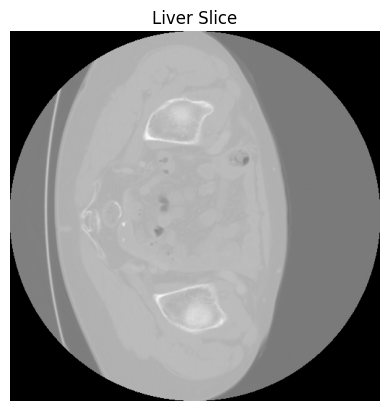

In [ ]:
nifti_file = nib.load("/content/liver_0.nii.gz")
image_data = nifti_file.get_fdata()
mid_slice = image_data.shape[2] // 4
plt.imshow(image_data[:, :, mid_slice], cmap='gray')
plt.title("Liver Slice")
plt.axis('off')
plt.show()

Pancreas- Main

In [ ]:
!pip install nibabel

In [ ]:
!gunzip -k /content/pancreas_001.nii.gz

In [ ]:
!gunzip -k /content/pancreas_379.nii.gz

In [ ]:
!gunzip -k /content/pancreas_001_label.nii.gz

In [ ]:
import nibabel as nib

# Load the .nii file
nifti_file = nib.load("/content/pancreas_001.nii")

# Get the image data as a NumPy array
image_data = nifti_file.get_fdata()

# Check shape and type
print("Shape:", image_data.shape)
print("Data type:", image_data.dtype)

Shape: (512, 512, 110)
Data type: float64


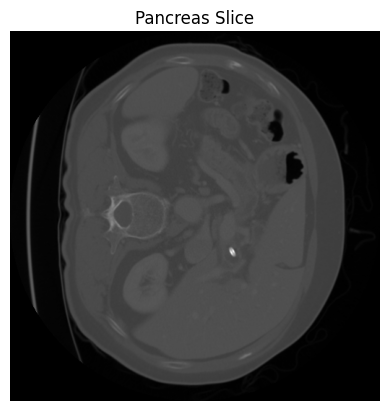

In [ ]:
import matplotlib.pyplot as plt

# Display a middle slice along the z-axis
mid_slice = image_data.shape[2] // 2
plt.imshow(image_data[:, :, mid_slice], cmap='gray')
plt.title("Pancreas Slice")
plt.axis('off')
plt.show()

In [ ]:
import numpy as np

In [94]:
image_path = "/content/pancreas_001.nii.gz"
label_path = "/content/pancreas_001_label.nii.gz"

image = nib.load(image_path).get_fdata()
label = nib.load(label_path).get_fdata()

print("Image shape:", image.shape)
print("Label shape:", label.shape)

Image shape: (512, 512, 110)
Label shape: (512, 512, 110)


In [95]:
#checking for tumor slices before further operationb
tumor_slices = [i for i in range(label.shape[2]) if np.any(label[:, :, i] > 1)]
print("Slices with tumor:", tumor_slices)

Slices with tumor: [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]


{
 "name": "Pancreas",
 "description": "Pancreas and cancer segmentation",
"reference": "Memorial Sloan Kettering Cancer Center ",
"licence":"CC-BY-SA 4.0",
"relase":"1.0 04/05/2018",
"tensorImageSize": "3D",
"modality": {
   "0": "CT"
 },
 "labels": {
   "0": "background",
   "1": "pancreas",
   "2": "cancer"
 },
 "numTraining": 281,
 "numTest": 139,



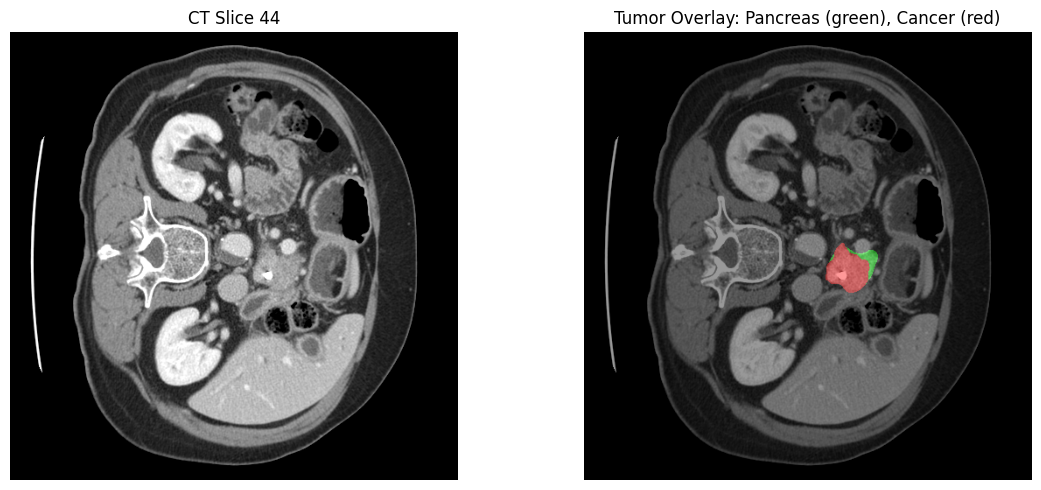

In [96]:
def window_image(img, WL=40, WW=400):
    img_min = WL - WW // 2
    img_max = WL + WW // 2
    windowed_img = np.clip(img, img_min, img_max)
    return (windowed_img - img_min) / (img_max - img_min)

# Pick a tumor slice
slice_idx = tumor_slices[len(tumor_slices) // 2]
#slice_idx = tumor_slices[42]

img_slice = window_image(image[:, :, slice_idx])
label_slice = label[:, :, slice_idx]

plt.figure(figsize=(12, 5))

# CT Slice
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.title(f"CT Slice {slice_idx}")
plt.axis('off')

# CT + Tumor (Cancer + Pancreas) Overlay
plt.subplot(1, 2, 2)
plt.imshow(img_slice, cmap='gray')

# Create RGB mask
rgb_mask = np.zeros((*label_slice.shape, 3))

# Assign colors: cancer (2) = red, pancreas (1) = green
rgb_mask[label_slice == 2] = [1, 0, 0]  # Red for cancer
rgb_mask[label_slice == 1] = [0, 1, 0]  # Green for pancreas

# Overlay RGB mask
plt.imshow(rgb_mask, alpha=0.4)

plt.title("Tumor Overlay: Pancreas (green), Cancer (red)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
!pip install scikit-image mahotas opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 61.9 MB/s eta 0:00:00


In [8]:
import numpy as np
import cv2
from skimage.filters import sobel
from skimage.feature import local_binary_pattern
import mahotas
import pandas as pd
import nibabel as nib
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt

In [ ]:
def get_vessel_mask_for_slice(img_slice, threshold=0.85):
    """Simple vessel approximation using intensity threshold."""
    return img_slice > threshold

def compute_features_for_pixel(args):
    y, x, img_slice, img_uint8, vessel_dist_map, radius = args
    patch_float = img_slice[y-radius:y+radius+1, x-radius:x+radius+1]
    patch_uint8 = img_uint8[y-radius:y+radius+1, x-radius:x+radius+1]

    # Haralick texture (mean of 13 features)
    if patch_uint8.shape[0] >= 2 and patch_uint8.shape[1] >= 2:
        haralick = mahotas.features.haralick(patch_uint8, return_mean=True)
    else:
        haralick = np.zeros(13)

    # LBP
    lbp_val = local_binary_pattern(patch_uint8, P=8, R=1, method='uniform')[radius, radius]

    # Gradient
    gradient_val = sobel(patch_float)[radius, radius]

    # Vessel distance
    vessel_dist = vessel_dist_map[y, x]

    return [
        img_slice[y, x], gradient_val, lbp_val, vessel_dist, x, y, *haralick
    ], int(label_slice[y, x])

def extract_features_parallel(img_slice, label_slice, vessel_mask, radius=2, use_bbox=False):
    img_uint8 = (img_slice * 255).astype(np.uint8)
    vessel_dist_map = cv2.distanceTransform((~vessel_mask).astype(np.uint8), cv2.DIST_L2, 5)

    h, w = img_slice.shape

    # Define region (optionally restrict to tumor + margin)
    if use_bbox:
        ys, xs = np.where(label_slice > 0)
        y_min = max(np.min(ys) - radius, radius)
        y_max = min(np.max(ys) + radius + 1, h - radius)
        x_min = max(np.min(xs) - radius, radius)
        x_max = min(np.max(xs) + radius + 1, w - radius)
    else:
        y_min, y_max = radius, h - radius
        x_min, x_max = radius, w - radius

    coords = [(y, x, img_slice, img_uint8, vessel_dist_map, radius)
              for y in range(y_min, y_max)
              for x in range(x_min, x_max)]

    # Parallel pixel-wise computation
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(compute_features_for_pixel, coords)

    # Split results
    features, labels = zip(*results)
    return np.array(features), np.array(labels)


In [ ]:
tumor_slices = [i for i in range(label.shape[2]) if np.any(label[:, :, i] > 0)]
if not tumor_slices:
    raise ValueError("No tumor slices found.")

slice_idx = tumor_slices[len(tumor_slices) // 2]
print("Using middle tumor slice:", slice_idx)

# ----------------------- Process the Slice -----------------------

img_slice = window_image(image[:, :, slice_idx])
label_slice = label[:, :, slice_idx]
vessel_mask = get_vessel_mask_for_slice(img_slice)

# Feature extraction (set use_bbox=True to crop to tumor with margin)
X, y = extract_features_parallel(img_slice, label_slice, vessel_mask, radius=2, use_bbox=False)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# ----------------------- Save to CSV -----------------------

columns = ['intensity', 'gradient', 'lbp', 'vessel_dist', 'x', 'y'] + [f'haralick_{i}' for i in range(13)]
df = pd.DataFrame(X, columns=columns)
df['label'] = y
df.to_csv("tumor_pixel_features.csv", index=False)

print("Saved per-pixel features for middle tumor slice to tumor_pixel_features.csv")

Using middle tumor slice: 47
Feature matrix shape: (258064, 19)
Labels shape: (258064,)
Saved per-pixel features for middle tumor slice to tumor_pixel_features.csv


In [ ]:
df['label'].value_counts()

label
0    255866
1      1250
2       948
Name: count, dtype: int64

In [ ]:
label = nib.load("pancreas_001_label.nii.gz").get_fdata()
print("Unique label values:", np.unique(label))

Unique label values: [0. 1. 2.]


In [9]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [230]:
data = pd.read_csv("tumor_pixel_features.csv")

# Feature columns (exclude 'x', 'y', 'label')
features = [col for col in data.columns if col not in ['x', 'y', 'label']]
X = data[features].values
y = data['label'].values  # Multi-class: 0 (background), 1 (pancreas), 2 (cancer)
coords = data[['x', 'y']].values #its float right now will be converted into int

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_model = make_pipeline(StandardScaler(), SVC(probability=True, kernel='rbf', decision_function_shape='ovr'))
svm_model.fit(X_train, y_train)
probs = svm_model.predict_proba(X)  # shape: (N, 3) for 3 classes

In [ ]:
# probs = svm_model.predict_proba(X)

# Example: Saving probabilities to a NumPy binary file (.npy)
np.save('probs.npy', probs)

# Example: Saving probabilities to a text file (.txt)
np.savetxt('probs.txt', probs)


In [ ]:
import matplotlib.pyplot as plt

def visualize_ca_evolution(initial_grid, steps_outputs):
    fig, axes = plt.subplots(1, len(steps_outputs)+1, figsize=(4*(len(steps_outputs)+1), 4))
    axes[0].imshow(initial_grid, cmap='hot')
    axes[0].set_title("Step 0 (Initial)")

    for i, g in enumerate(steps_outputs):
        axes[i+1].imshow(g, cmap='hot')
        axes[i+1].set_title(f"Step {i+1}")
    plt.tight_layout()
    plt.show()

In [232]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_neighbors_map(coords, probs, grid_shape):
    grid = np.zeros(grid_shape)
    for (x, y), p in zip(coords, probs):
        grid[int(y), int(x)] = p
    return grid

def create_const_mask(coords, labels, grid_shape):
    mask = np.zeros(grid_shape, dtype=bool)
    for (x, y), label_val in zip(coords, labels):
        mask[int(y), int(x)] = label_val in [1, 2]  # pancreas or cancer
    return mask

In [ ]:
def ca_update(grid, labels, c=2.0, alpha=0.5, beta=0.5, steps=5, return_steps=False):
    h, w = grid.shape
    const_mask = np.isin(labels, [1, 2])  # Pancreas and cancer = immutable

    outputs = [grid.copy()] if return_steps else None

    for t in range(steps):
        new_grid = np.copy(grid)

        for y in range(1, h - 1):
            for x in range(1, w - 1):
                if const_mask[y, x]:
                    continue  # Skip immutable cells

                neighborhood = grid[y - 1:y + 2, x - 1:x + 2]
                neighbor_mask = const_mask[y - 1:y + 2, x - 1:x + 2]

                # Compute average over mutable neighbors
                mutable_mask = ~neighbor_mask
                mutable_neighbors = neighborhood * mutable_mask
                num_mutable = np.sum(mutable_mask)

                if num_mutable == 0:
                    continue  # No mutable neighbors, skip update

                omega = np.sum(mutable_neighbors) / num_mutable

                s = np.sign(np.sum(mutable_neighbors) + beta)

                gamma = np.random.uniform(0, 1)
                perturb = 1 + (-np.log(gamma)) ** alpha

                # Fraction of mutable neighbors (soft constraint)
                cons_frac = np.mean(mutable_mask)

                denom = 1 + np.exp(-s)
                update = c * (1 / denom) * perturb * omega * cons_frac

                new_grid[y, x] = update

        grid = new_grid
        if return_steps:
            outputs.append(grid.copy())

    return outputs if return_steps else grid

In [238]:
probs=np.load('probs.npy')

In [239]:
cancer_probs = probs[:, 2]  # class index 2 = cancer
coords = np.round(coords).astype(int)
xmax = int(coords[:, 0].max()) + 1
ymax = int(coords[:, 1].max()) + 1
grid_shape = (ymax, xmax)

# Now this works:
grid = get_neighbors_map(coords, cancer_probs, grid_shape)
#const_mask = create_const_mask(coords, y, grid_shape)  # pancreas and cancer as immutable (those pixels that we already know are cancer )

In [241]:
np.save('grid.npy')

TypeError: save() missing 1 required positional argument: 'arr'

NameError: name 'const_mask' is not defined

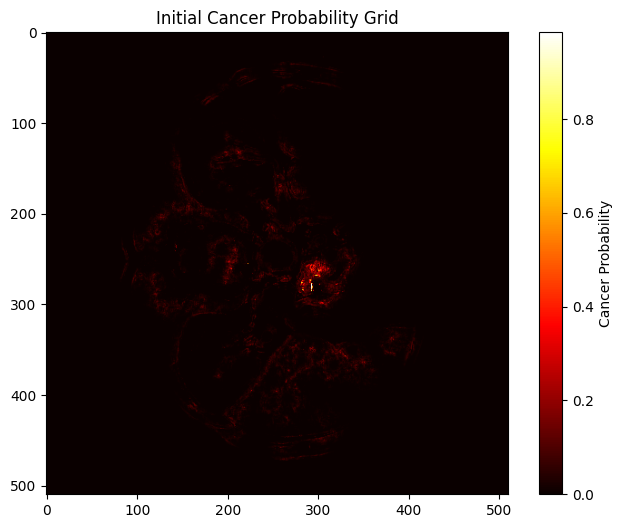

In [234]:
# # prompt: how to check initial prediction of cancer by svm visually

# import matplotlib.pyplot as plt

# # Assuming 'grid' and 'const_mask' are already defined as in your code

# # Visualize the initial prediction grid
# plt.figure(figsize=(8, 6))
# plt.imshow(grid, cmap='hot')  # Use a suitable colormap
# plt.colorbar(label='Cancer Probability')
# plt.title('Initial Cancer Probability Grid')

# # Overlay the constant mask (optional, helps to visualize immutable regions)
# plt.imshow(const_mask, cmap='gray', alpha=0.3)  # Overlay with transparency

# plt.show()


In [ ]:
label_grid = np.zeros((ymax, xmax), dtype=int)
for (x, y_coord), label_val in zip(coords, y):
    label_grid[int(y_coord), int(x)] = label_val

| Parameter | Role                | Effect                                    |
|-----------|---------------------|------------------------------------------|
| c         | Global scaling      | Boosts update strength. Try c = 3.0+     |
| alpha     | Perturbation sharpness | Lower = more random variability         |
| beta      | Bias in sign term   | Helps encourage positive updates         |
| steps     | Iterations          | More steps = more growth potential       |


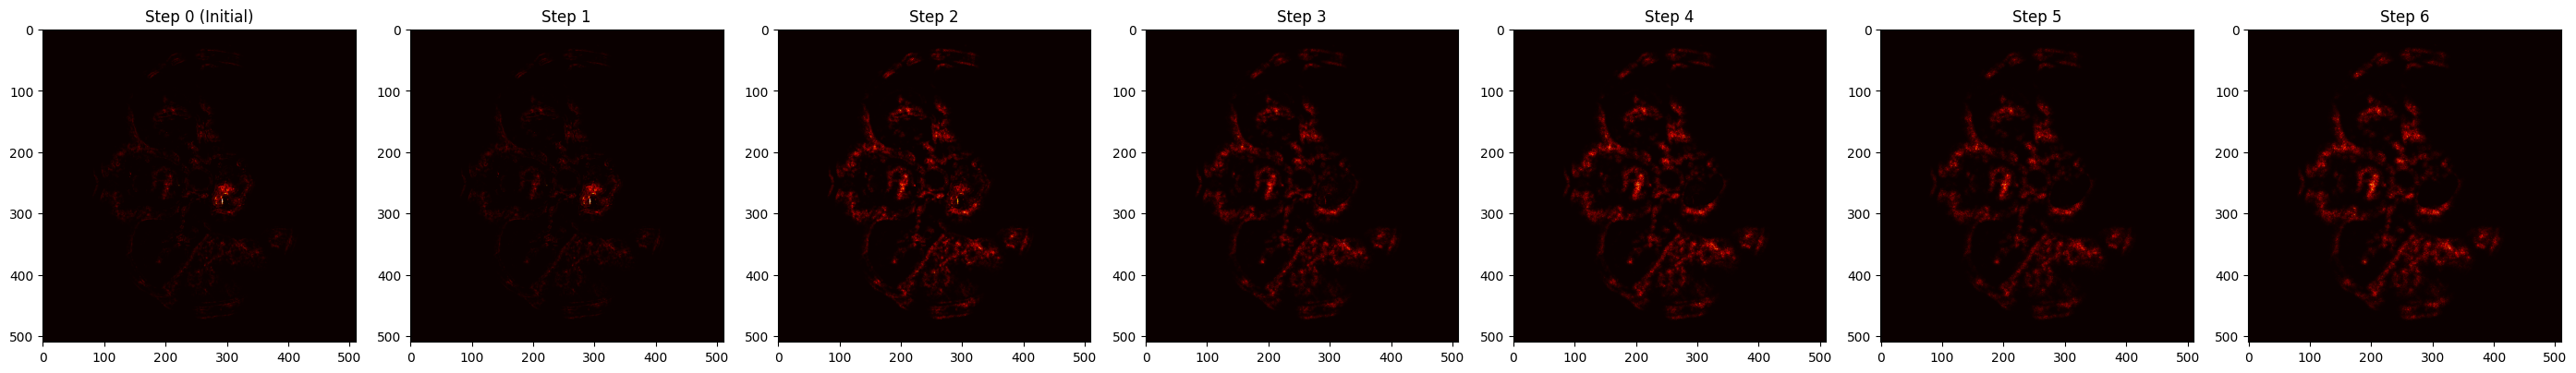

In [ ]:
step_outputs = ca_update(grid, label_grid, c=3, alpha=0.9, beta=0.5, steps=5, return_steps=True)
visualize_ca_evolution(grid, step_outputs)

In [ ]:
def plot_grid_distributions(step_outputs):
    steps = len(step_outputs)
    plt.figure(figsize=(15, 4))

    for i, grid in enumerate(step_outputs):
        plt.subplot(1, steps, i + 1)
        plt.hist(grid.flatten(), bins=50, range=(0, 1), color='purple', alpha=0.7)
        plt.title(f'Step {i}')
        plt.xlabel('Grid Value')
        plt.ylabel('Count')
        plt.grid(True)

    plt.tight_layout()
    plt.suptitle('Grid Value Distribution Over CA Steps', fontsize=16, y=1.05)
    plt.show()

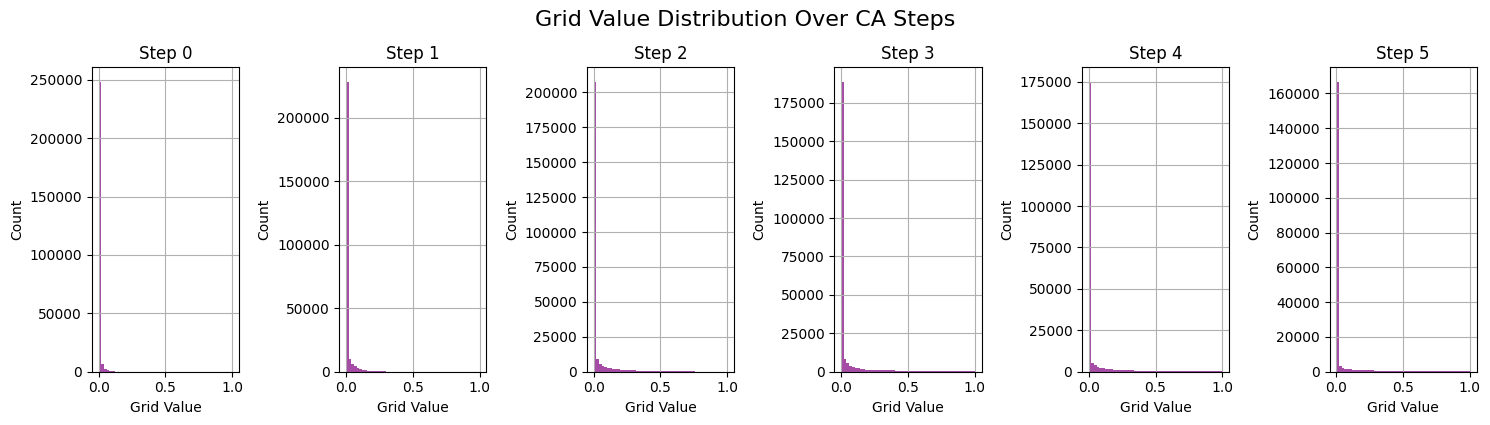

In [ ]:
plot_grid_distributions(step_outputs)

Running CA with c=1.2, alpha=0.9, beta=0.4


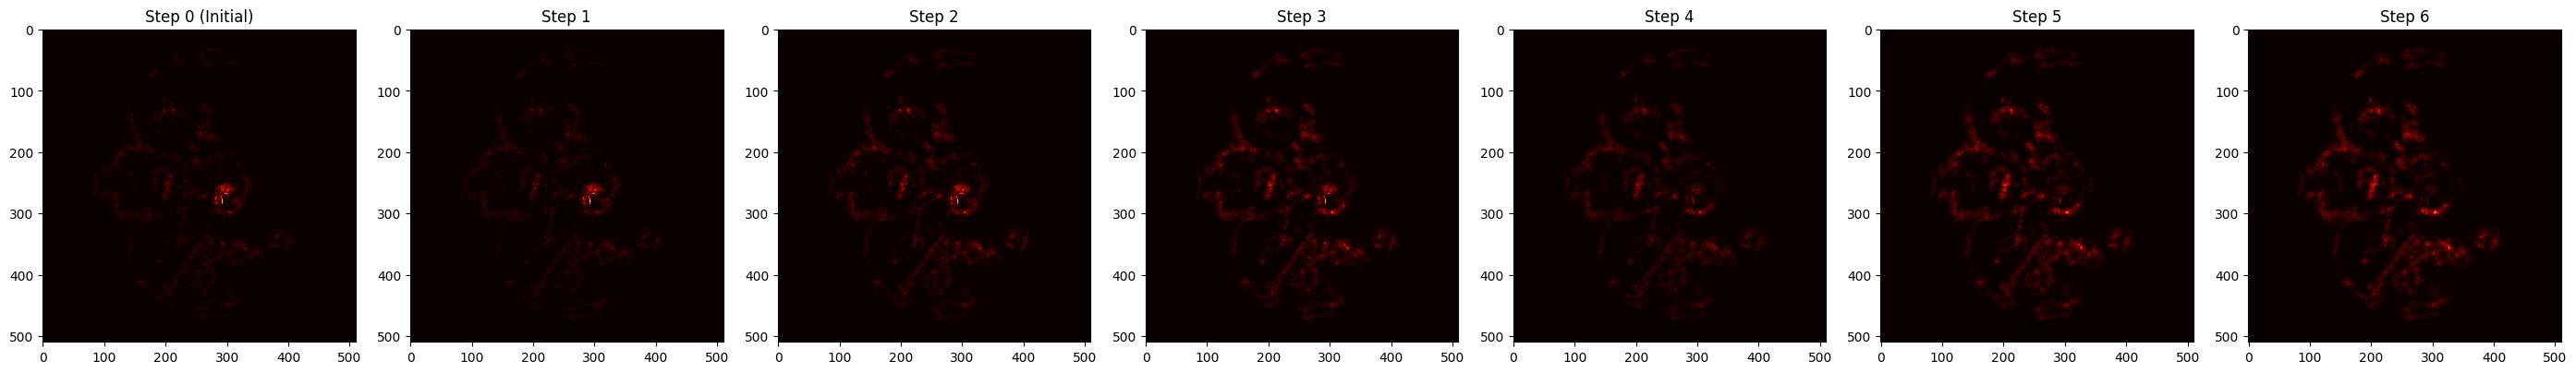

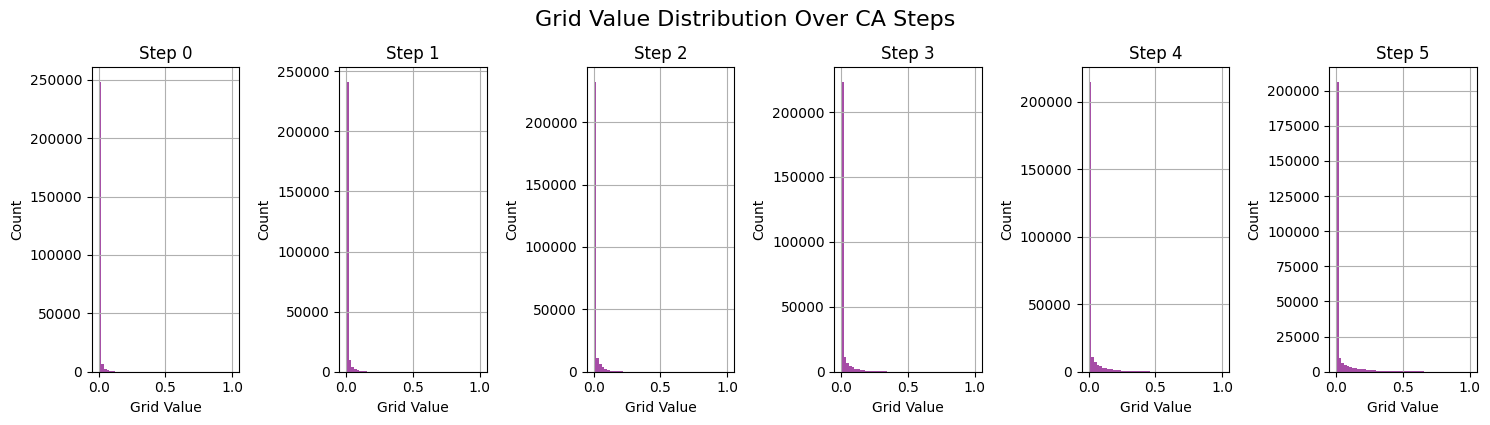

Running CA with c=1.2, alpha=0.9, beta=0.5


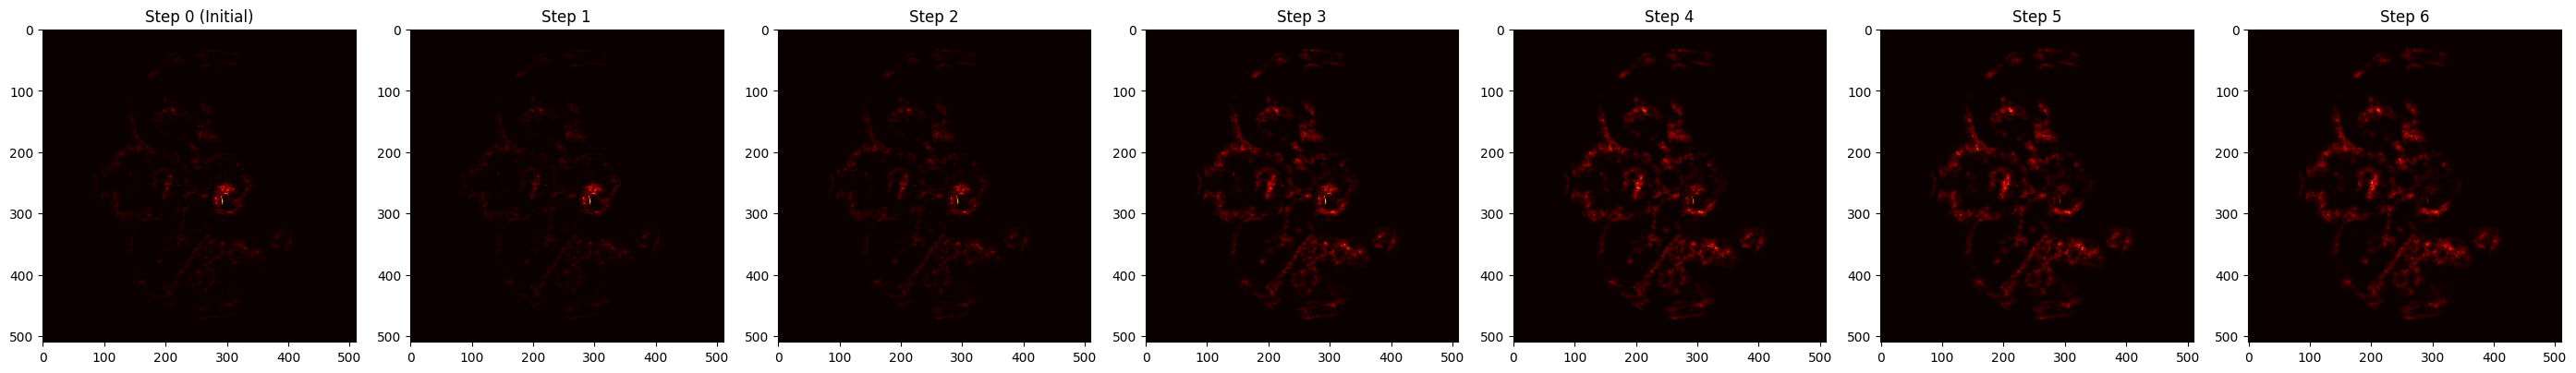

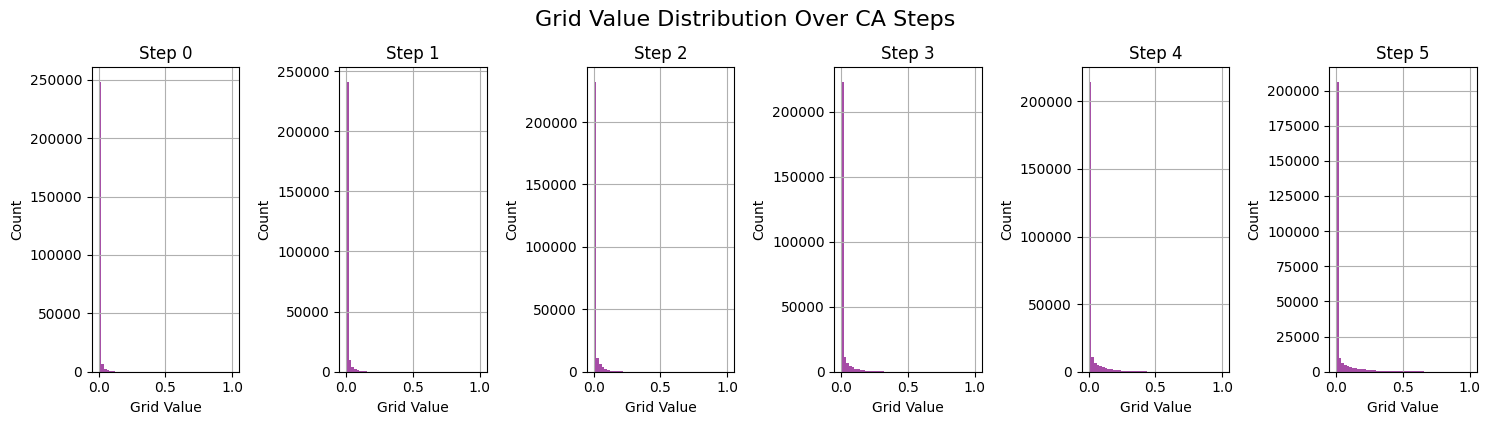

Running CA with c=1.2, alpha=1, beta=0.4


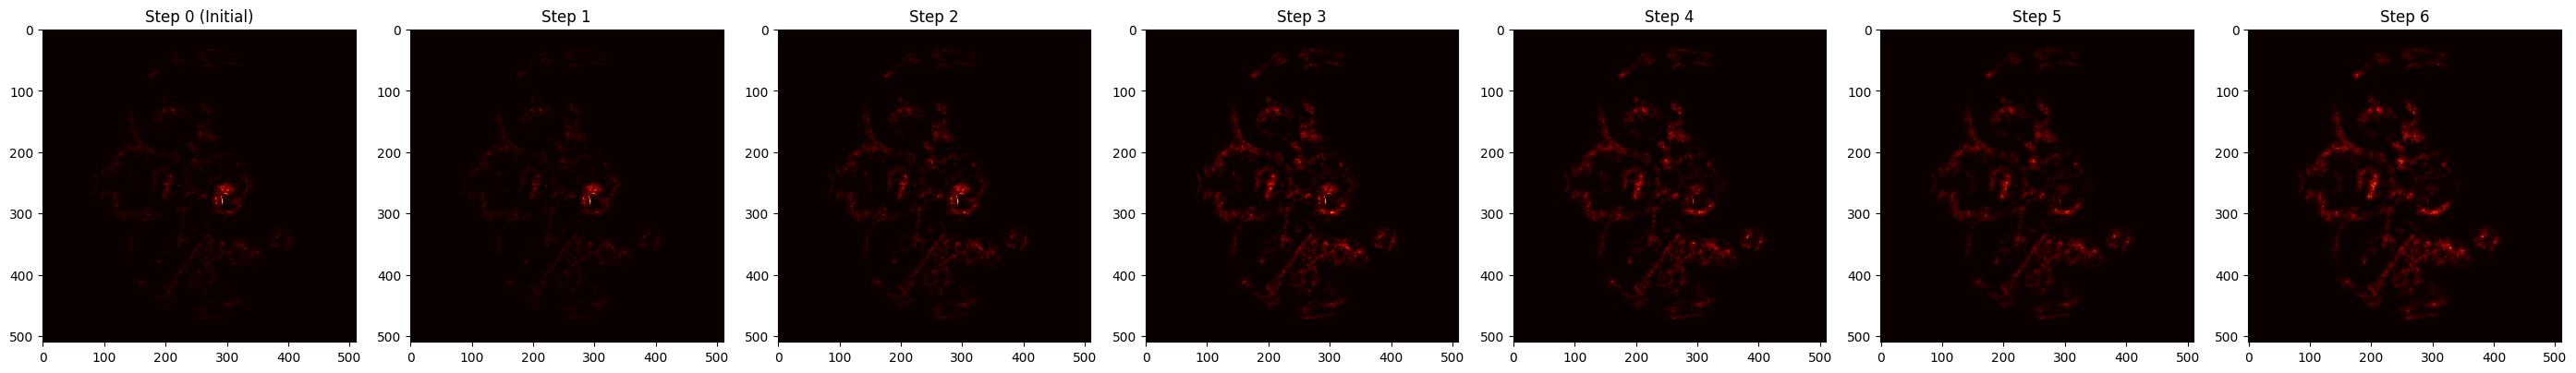

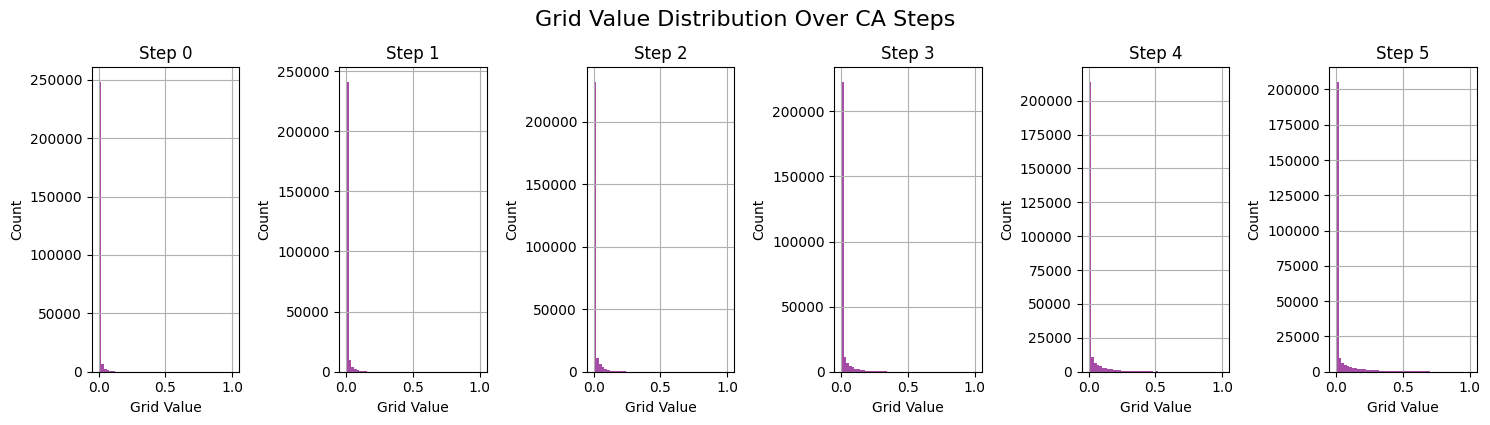

Running CA with c=1.2, alpha=1, beta=0.5


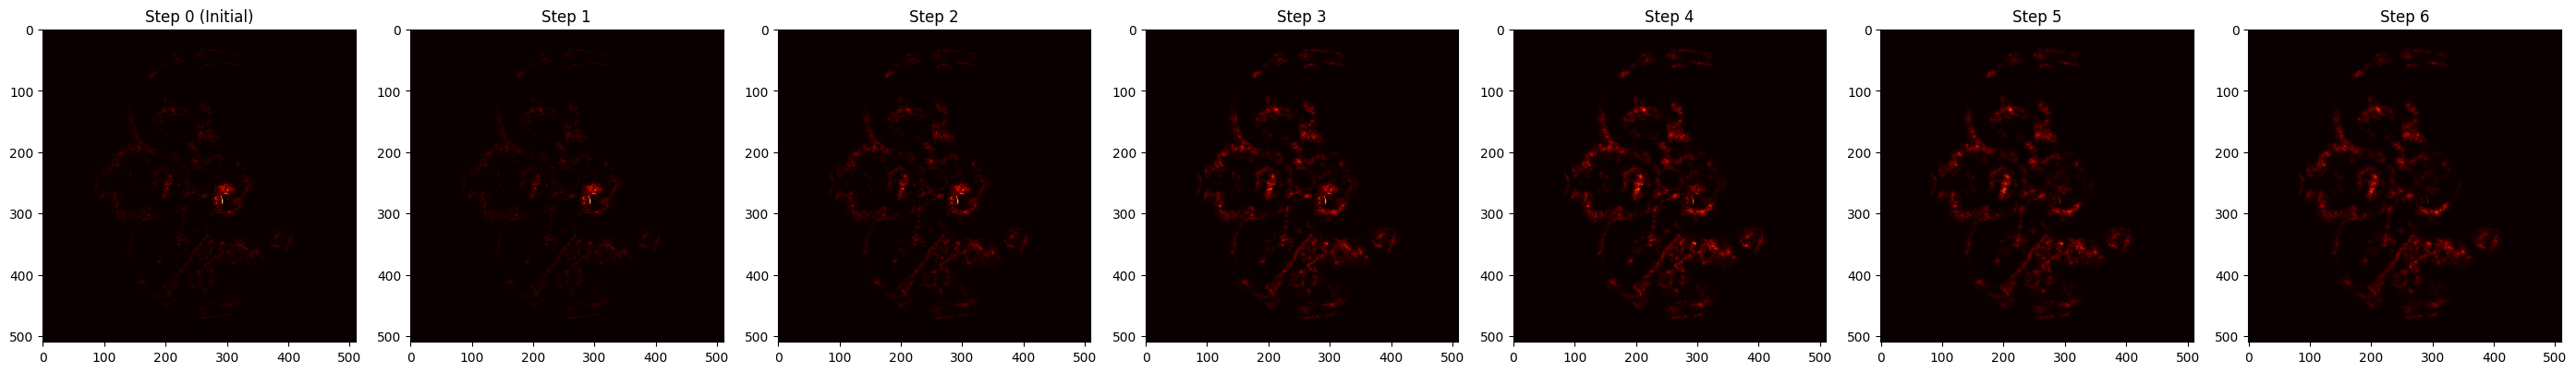

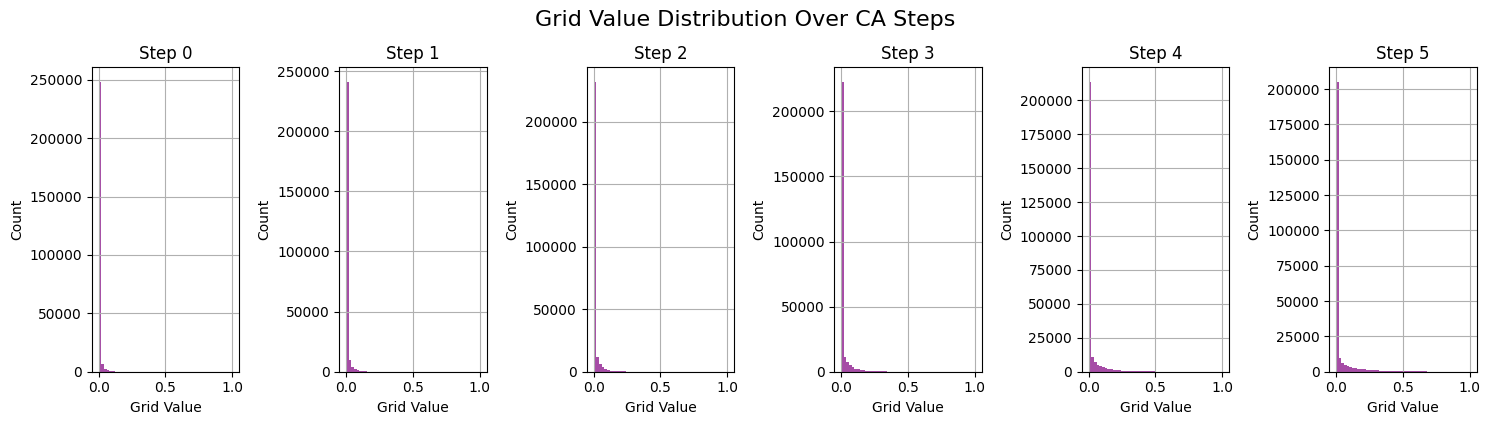

Running CA with c=1.2, alpha=2, beta=0.4


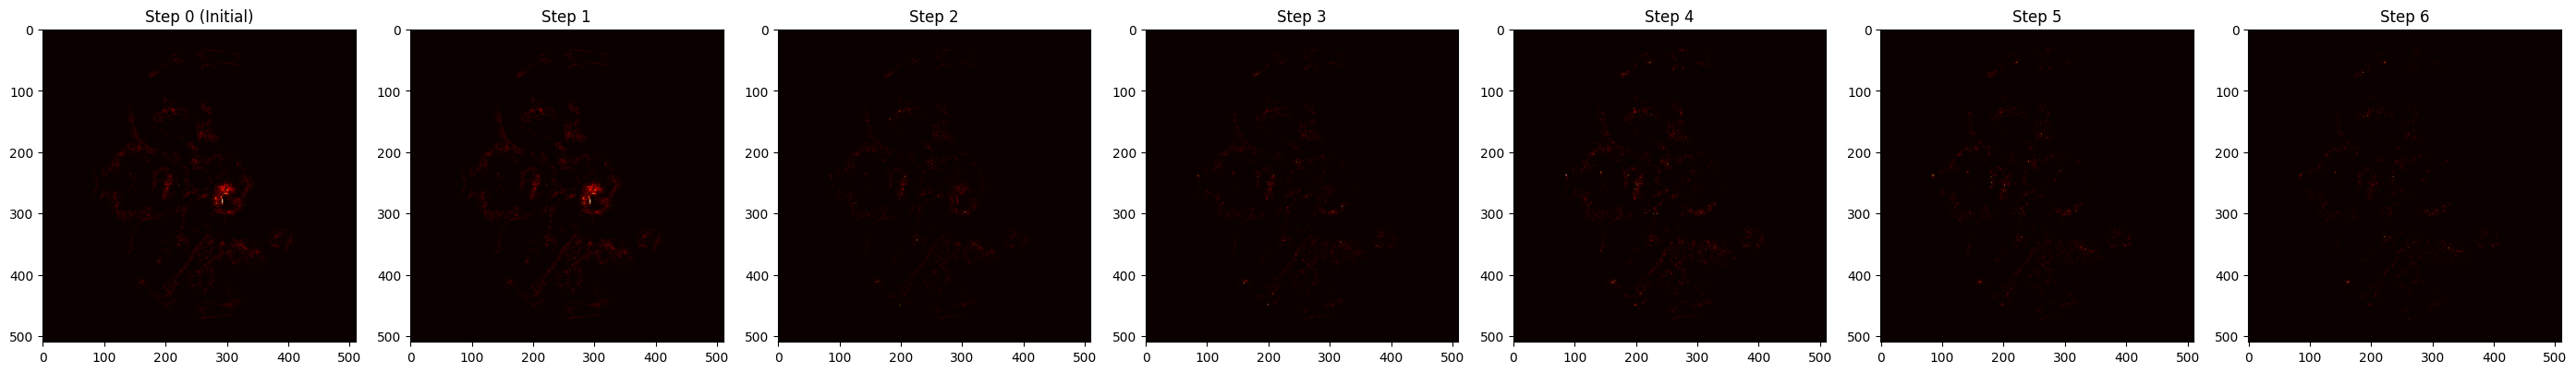

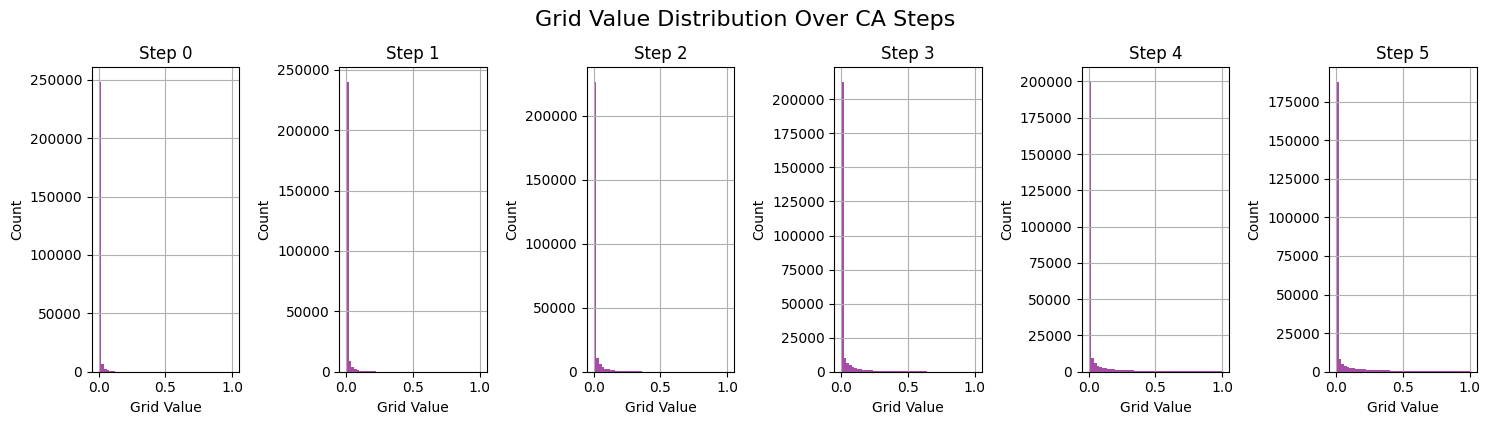

Running CA with c=1.2, alpha=2, beta=0.5


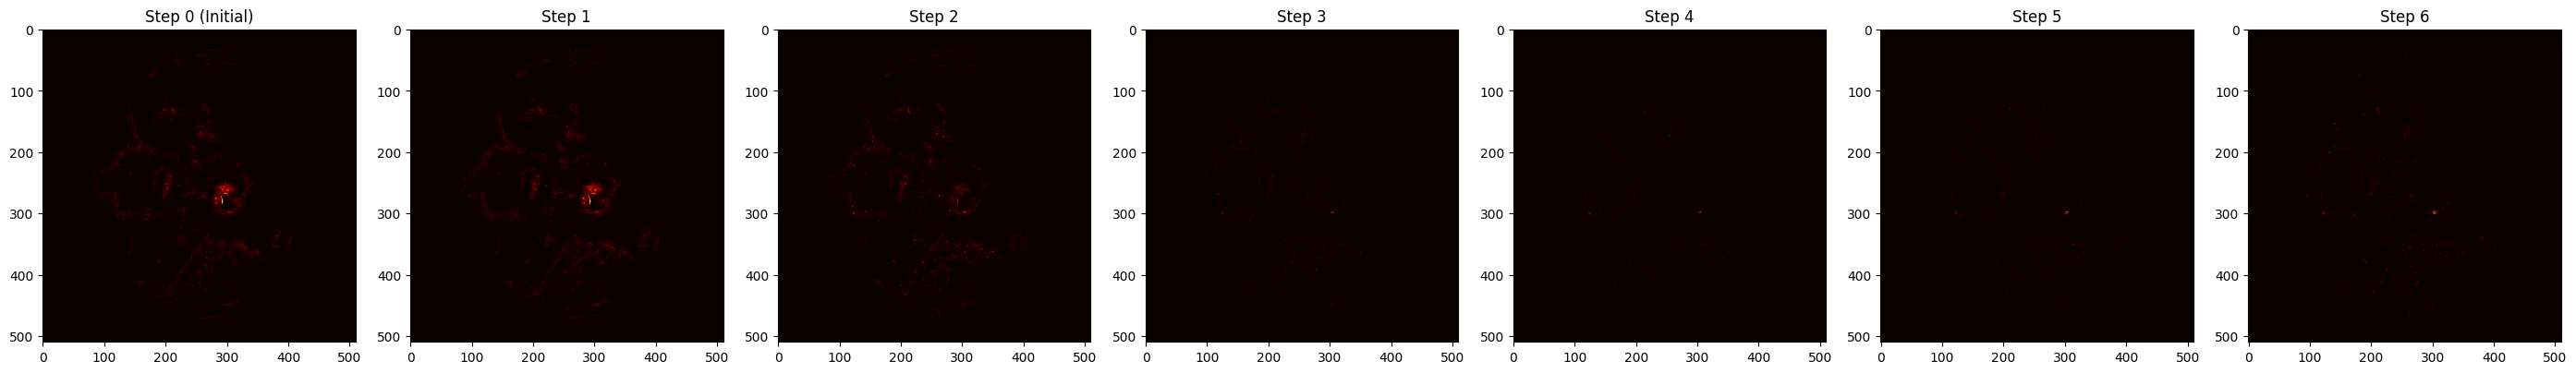

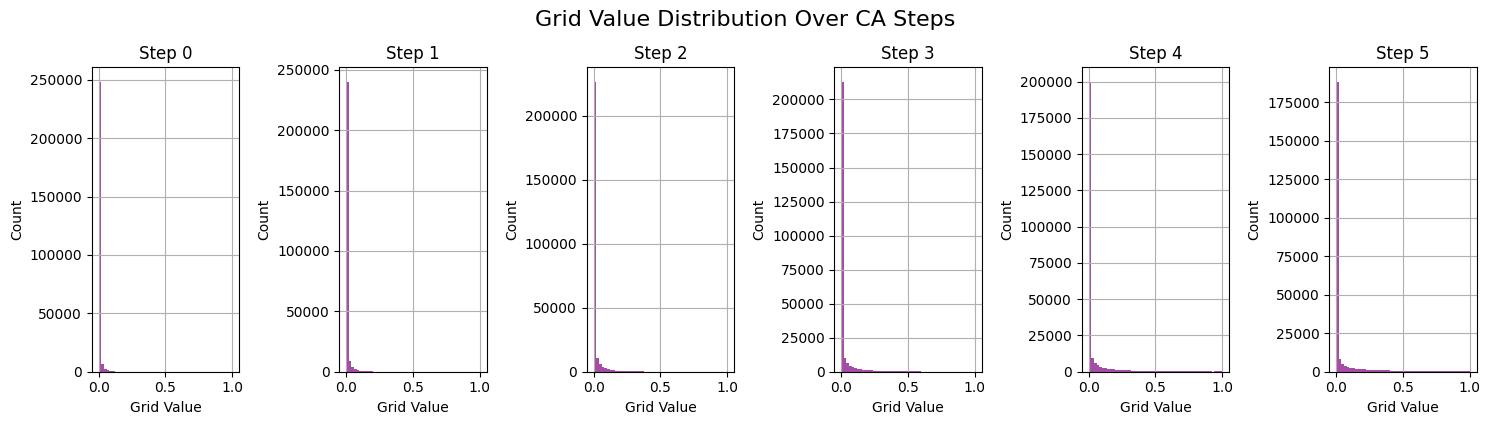

Running CA with c=1.2, alpha=1.5, beta=0.4


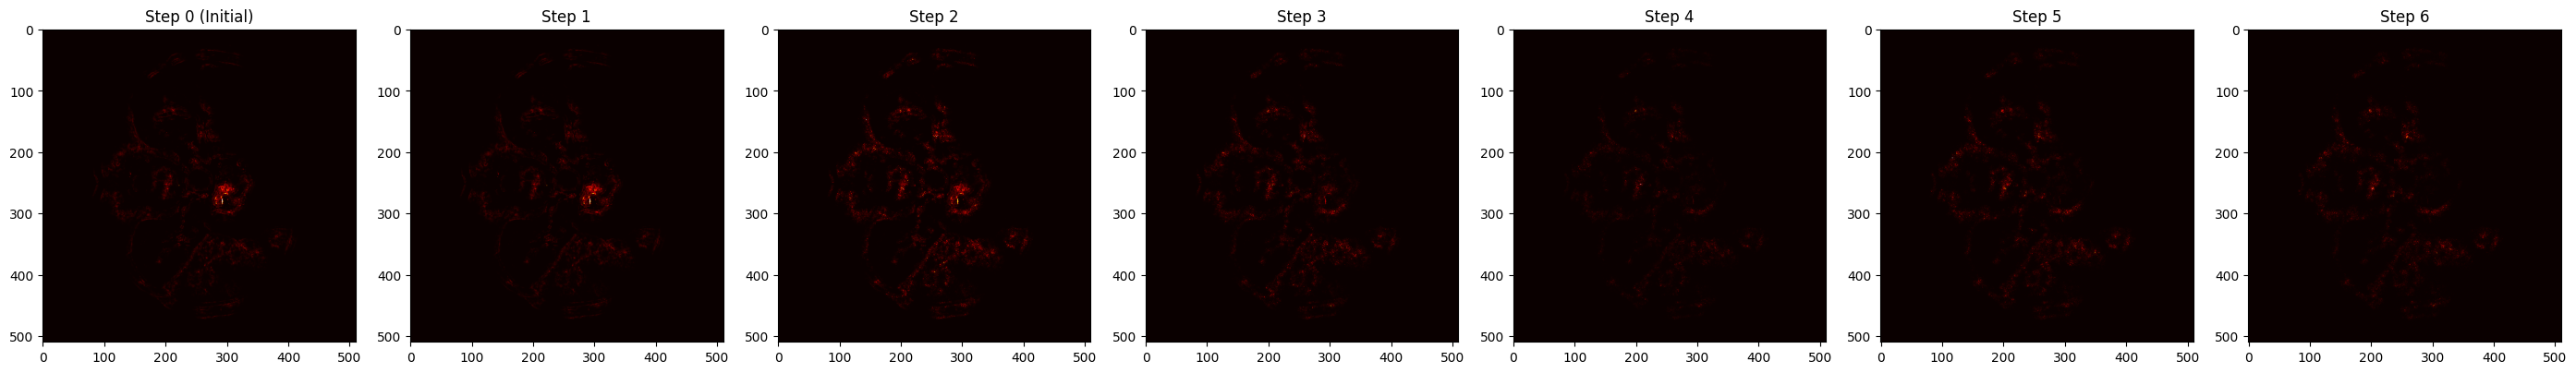

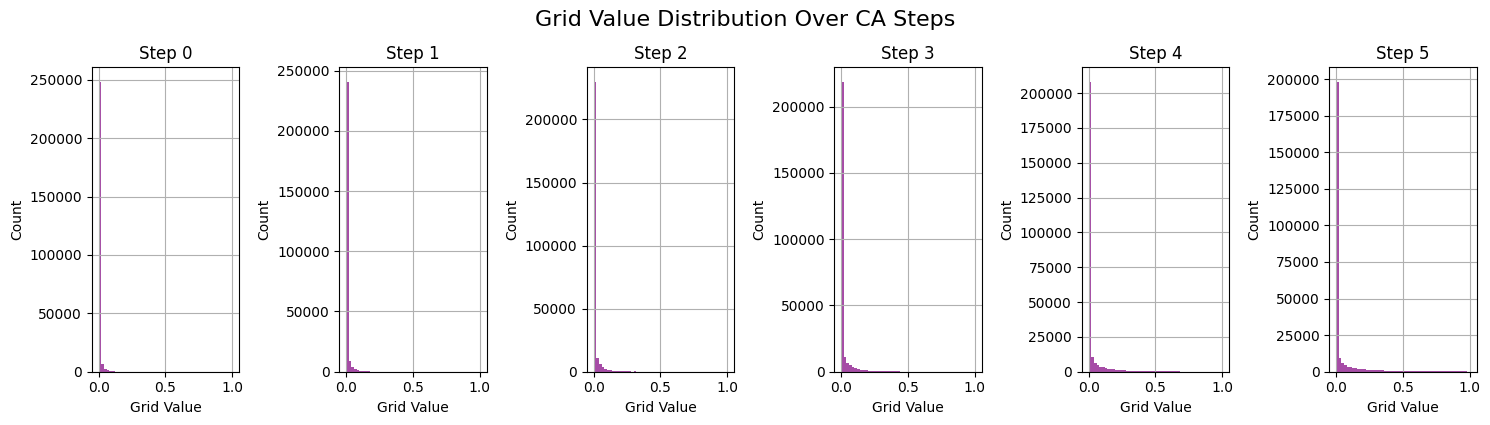

Running CA with c=1.2, alpha=1.5, beta=0.5


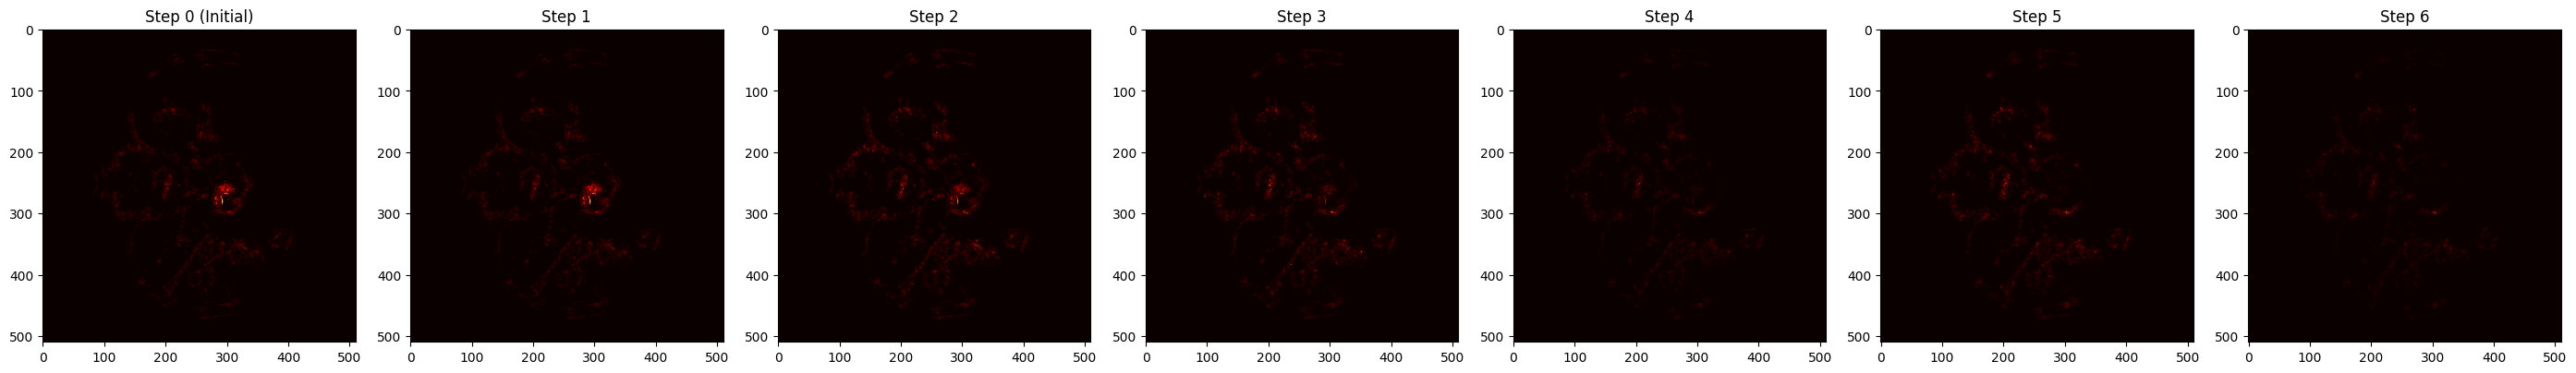

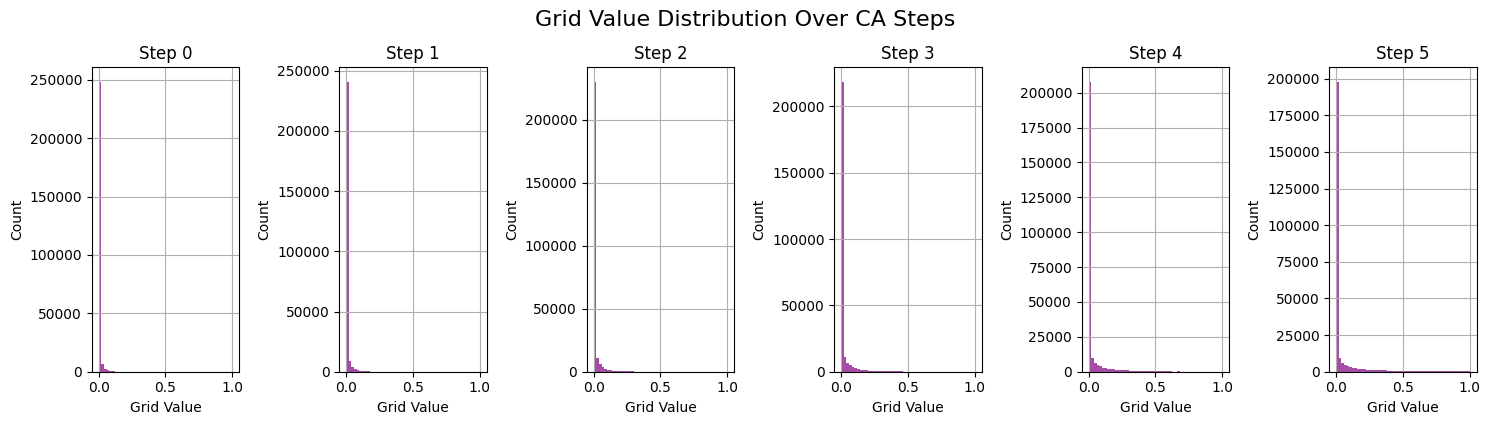

Running CA with c=2.0, alpha=0.9, beta=0.4


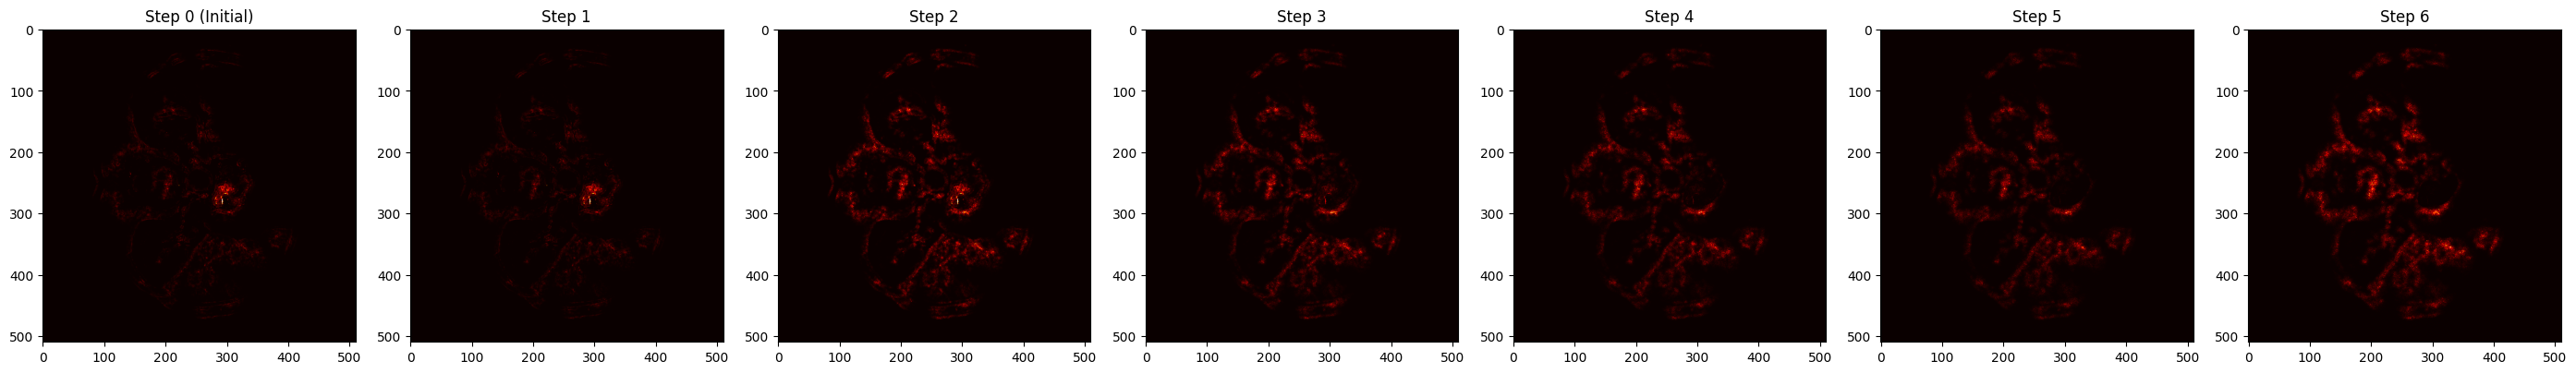

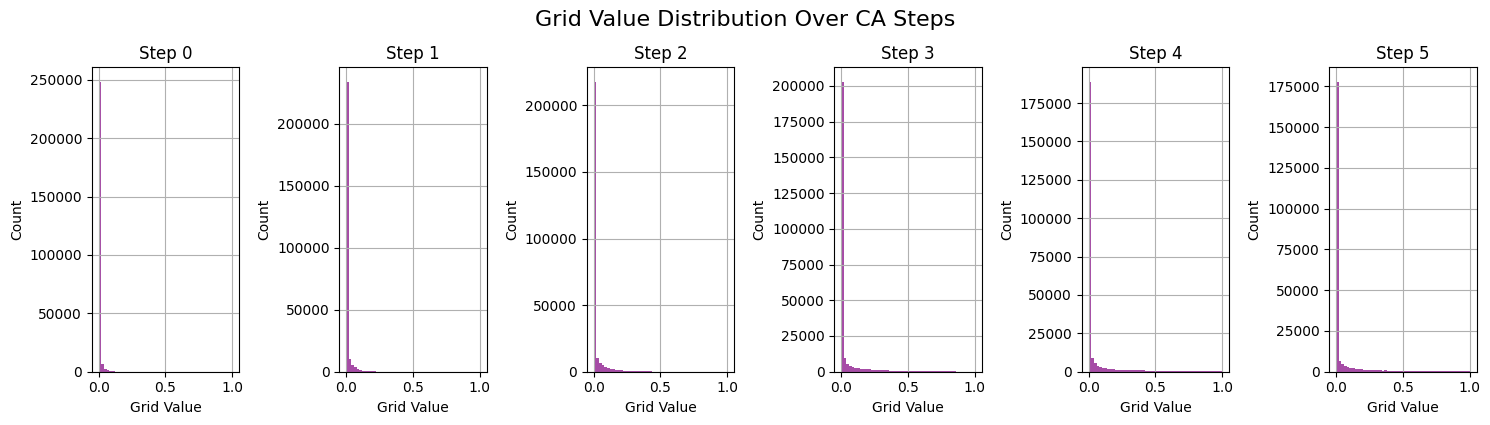

Running CA with c=2.0, alpha=0.9, beta=0.5


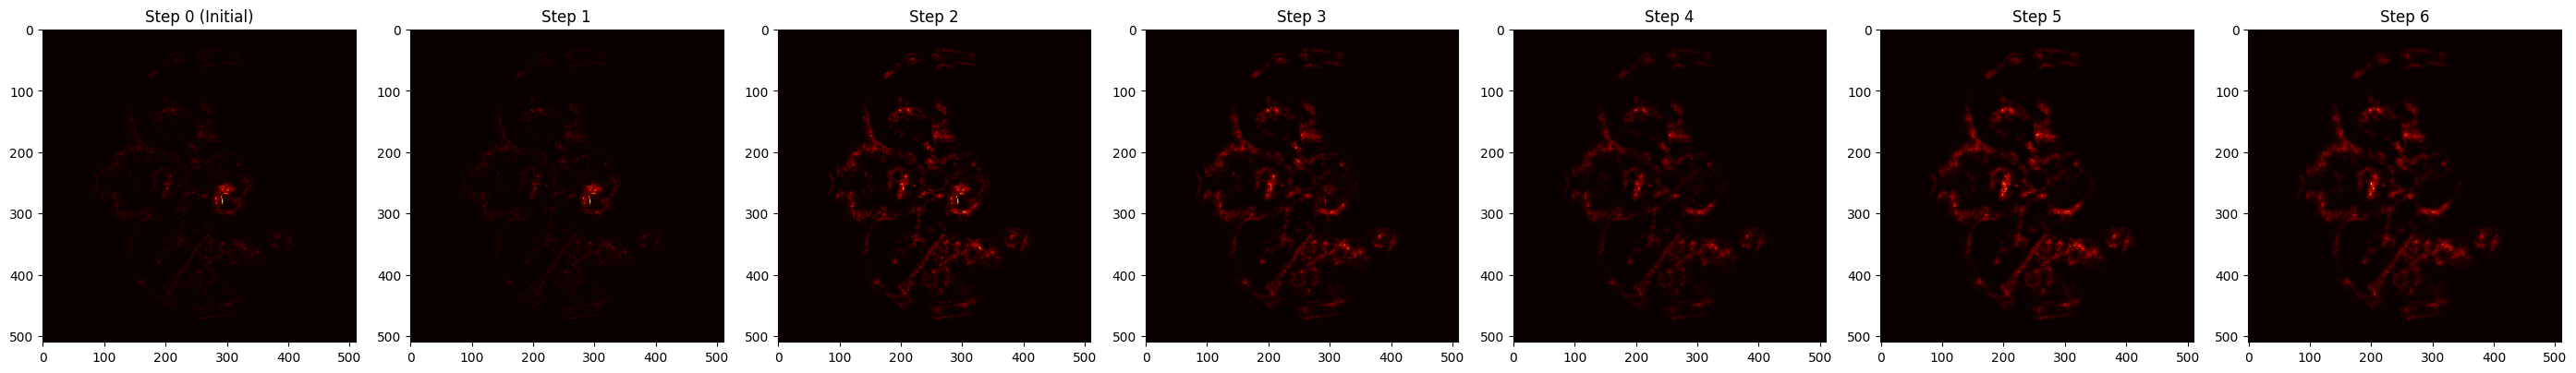

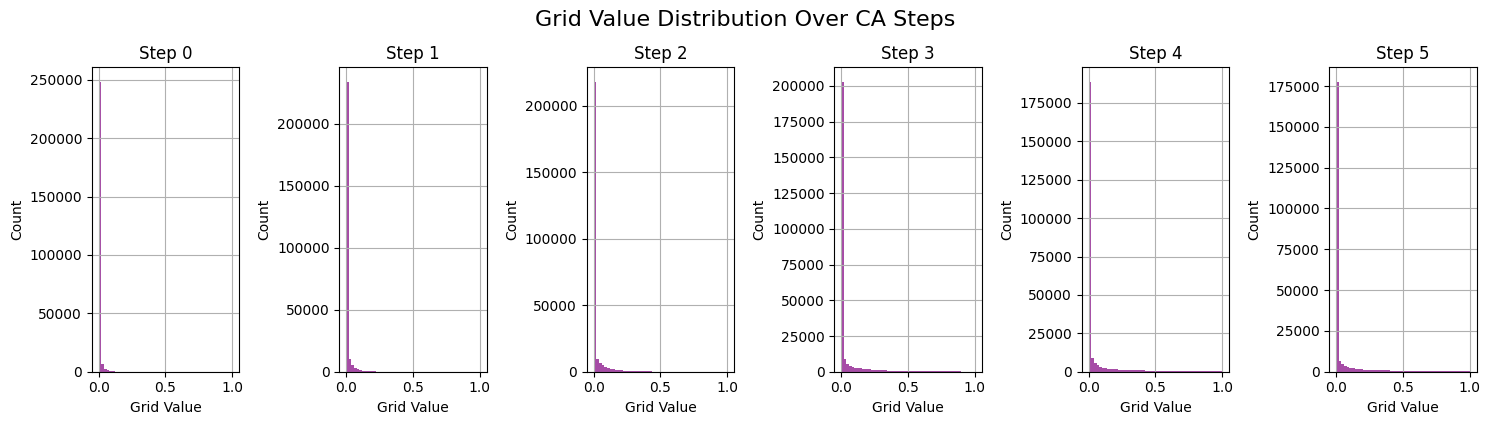

Running CA with c=2.0, alpha=1, beta=0.4


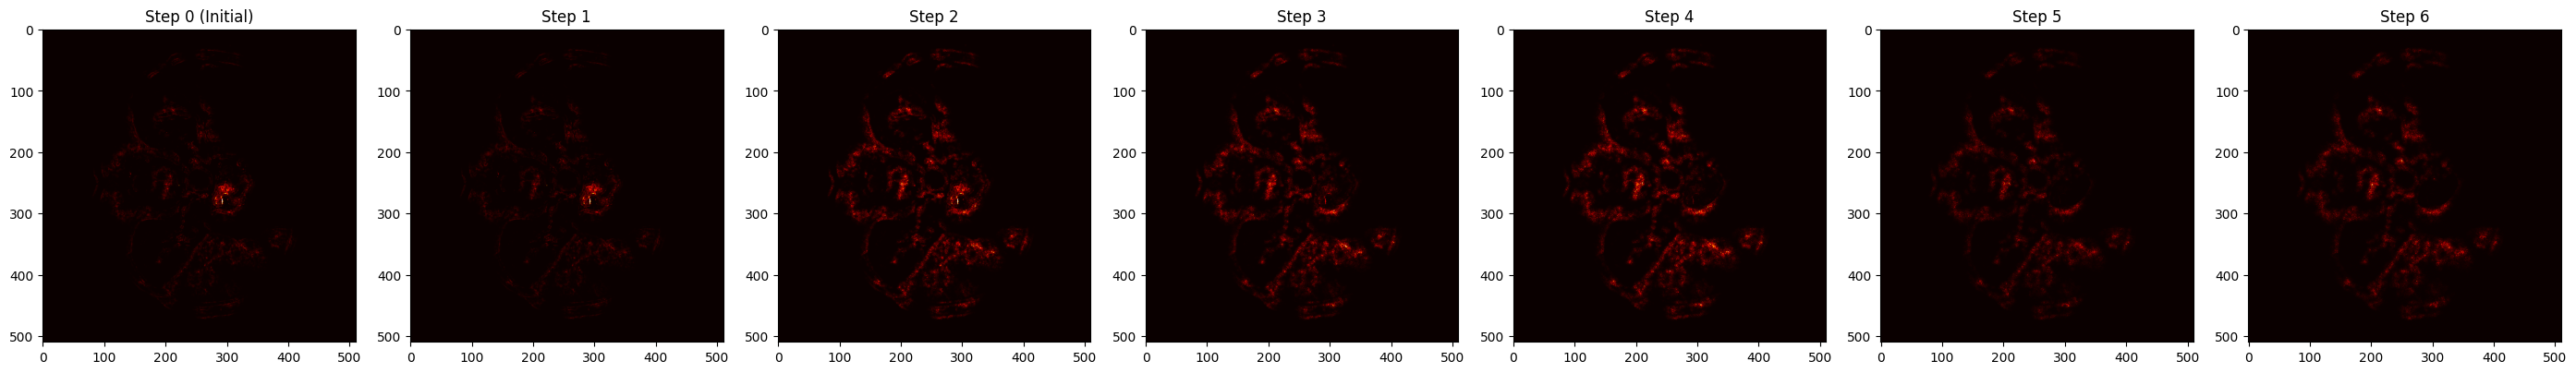

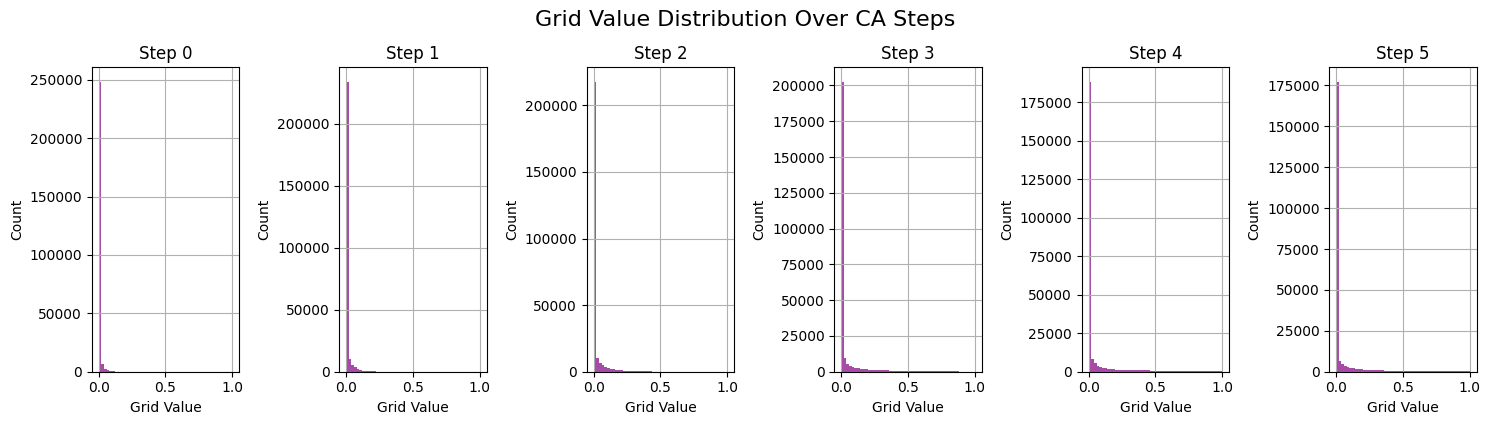

Running CA with c=2.0, alpha=1, beta=0.5


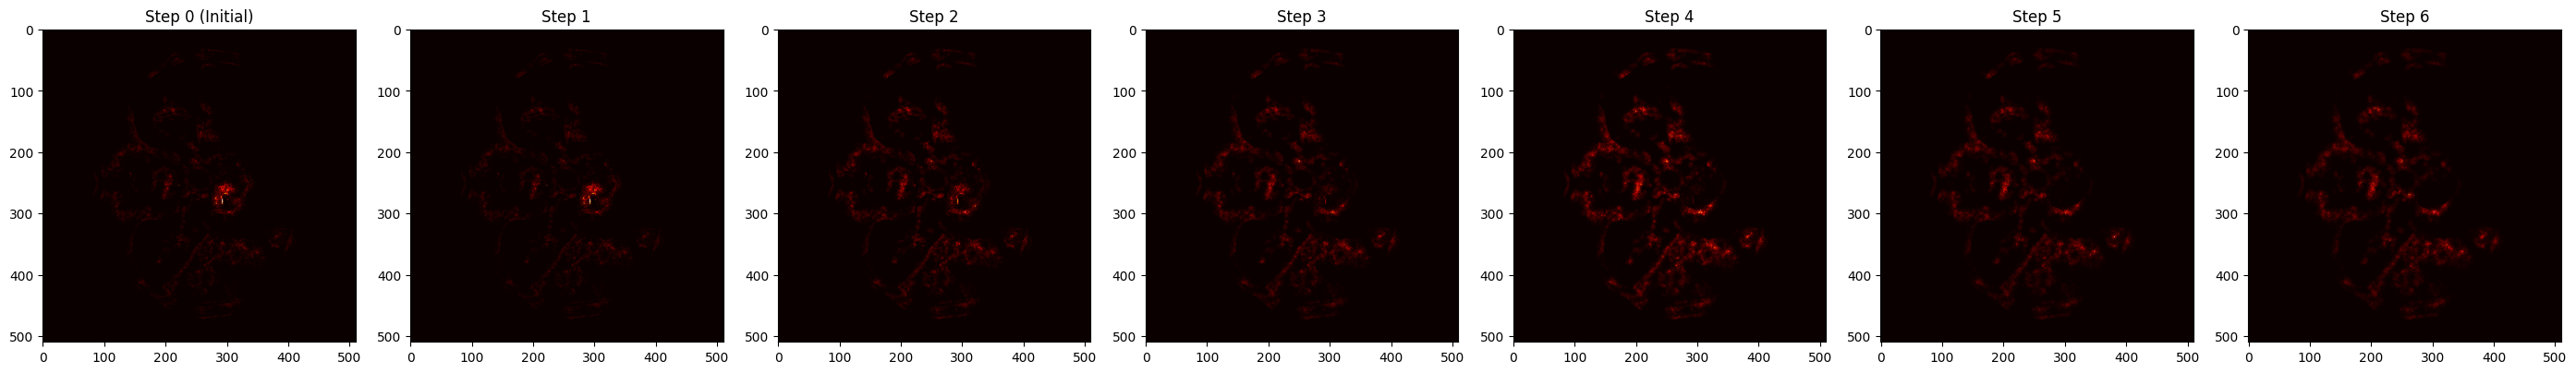

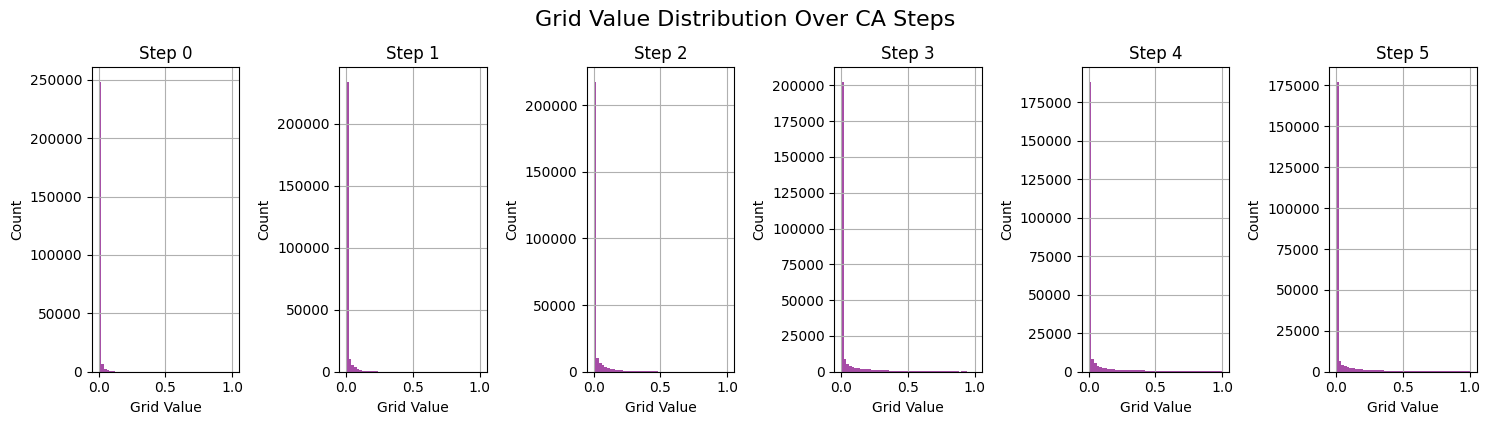

Running CA with c=2.0, alpha=2, beta=0.4


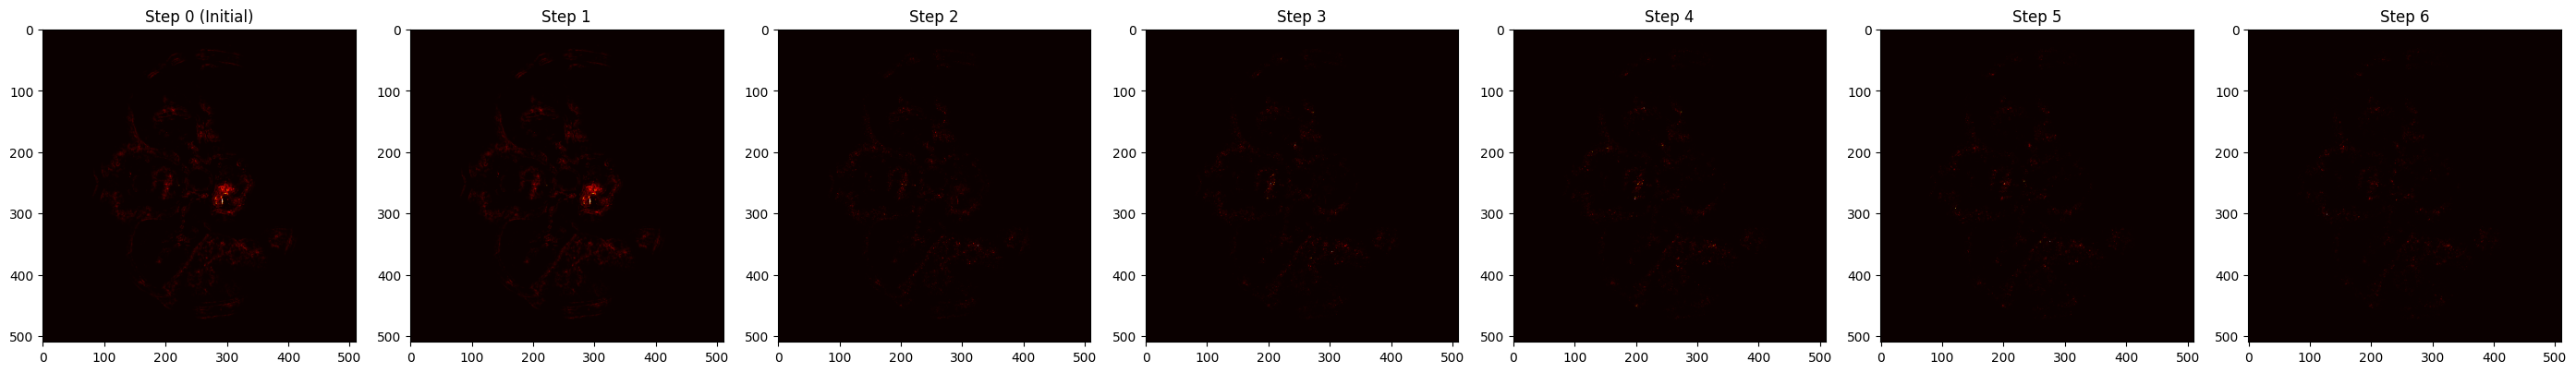

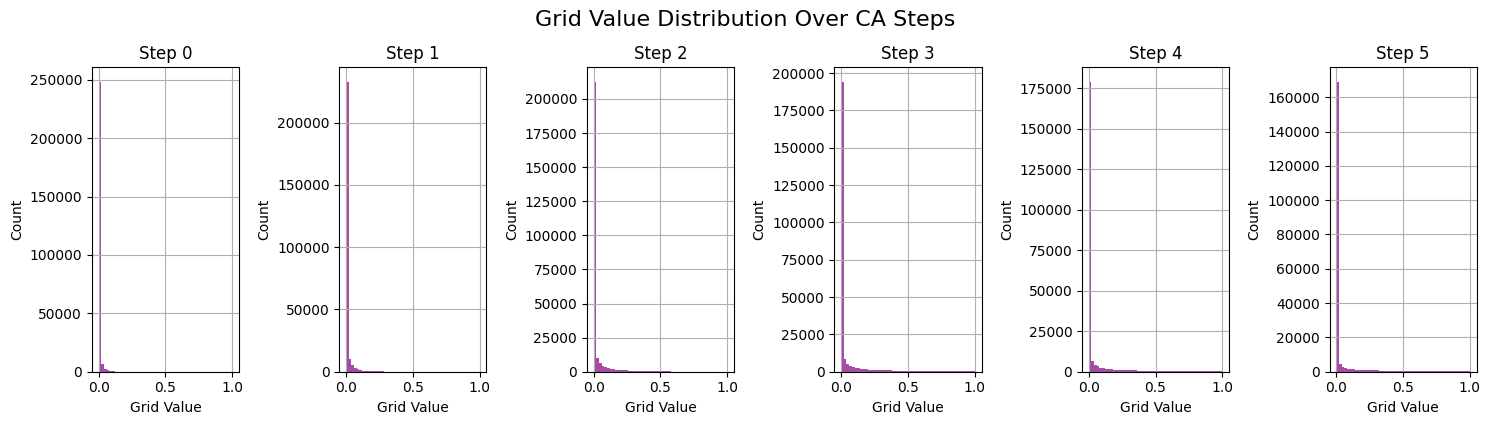

Running CA with c=2.0, alpha=2, beta=0.5


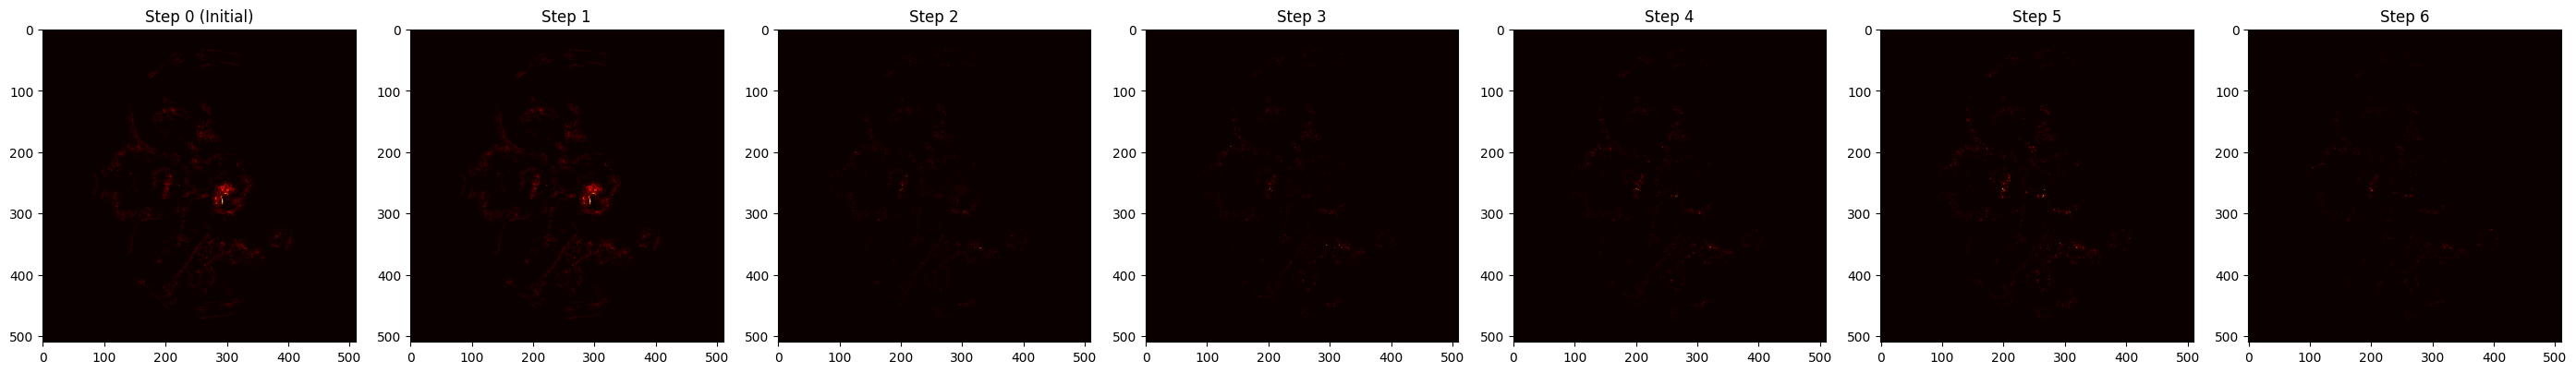

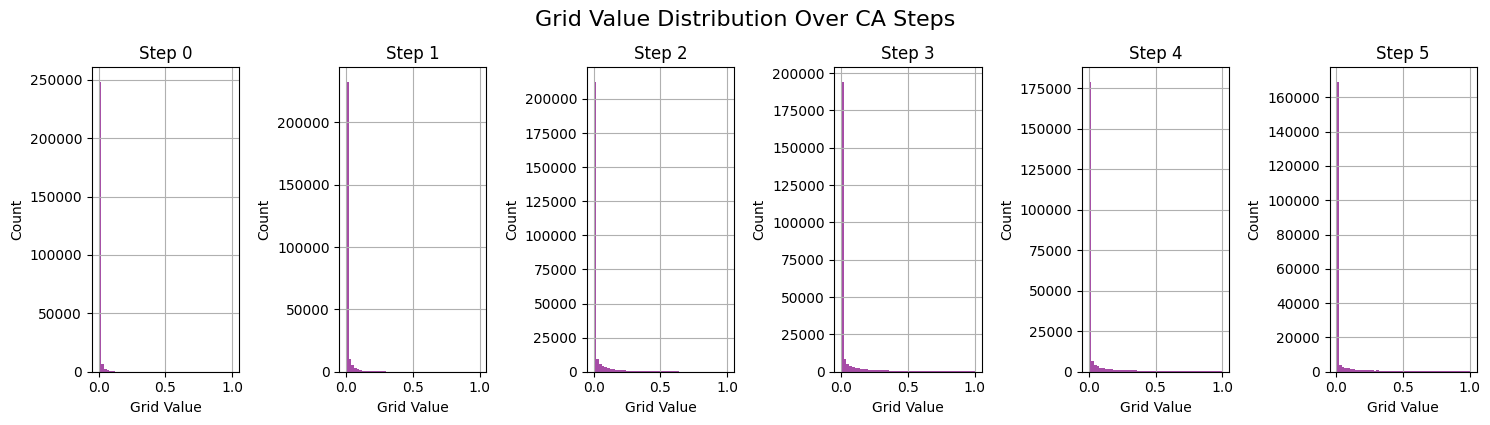

Running CA with c=2.0, alpha=1.5, beta=0.4


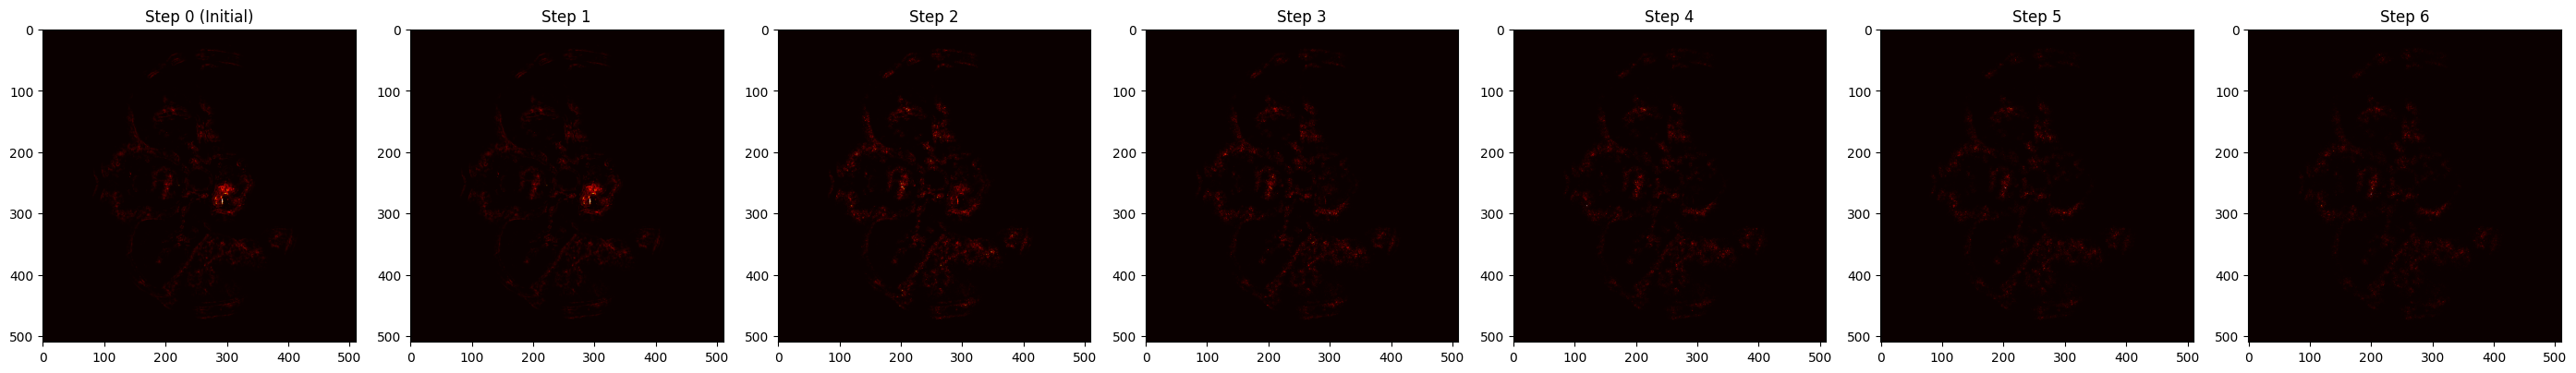

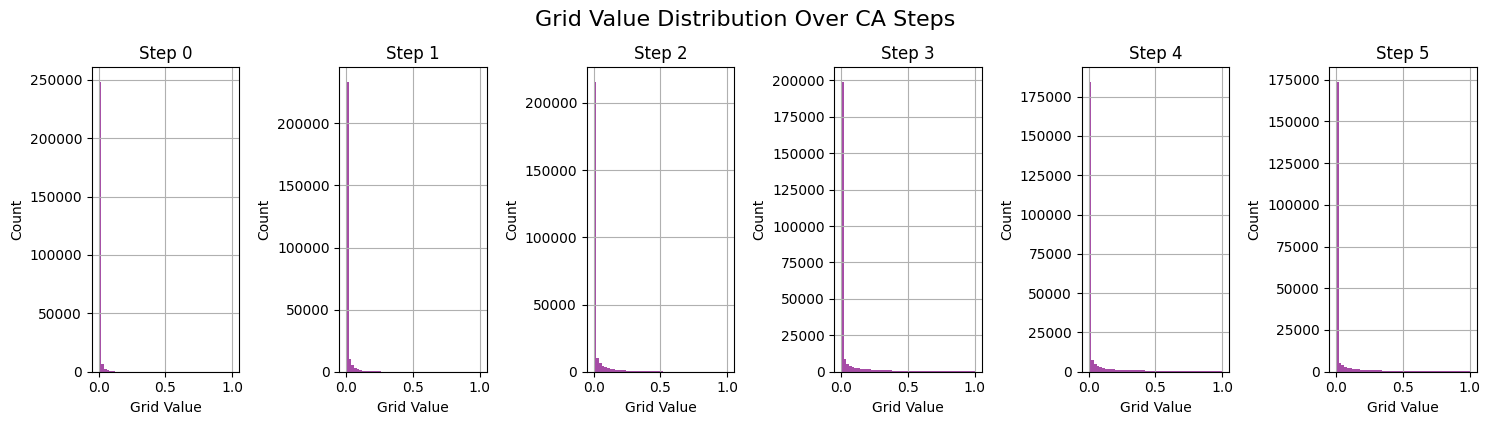

Running CA with c=2.0, alpha=1.5, beta=0.5


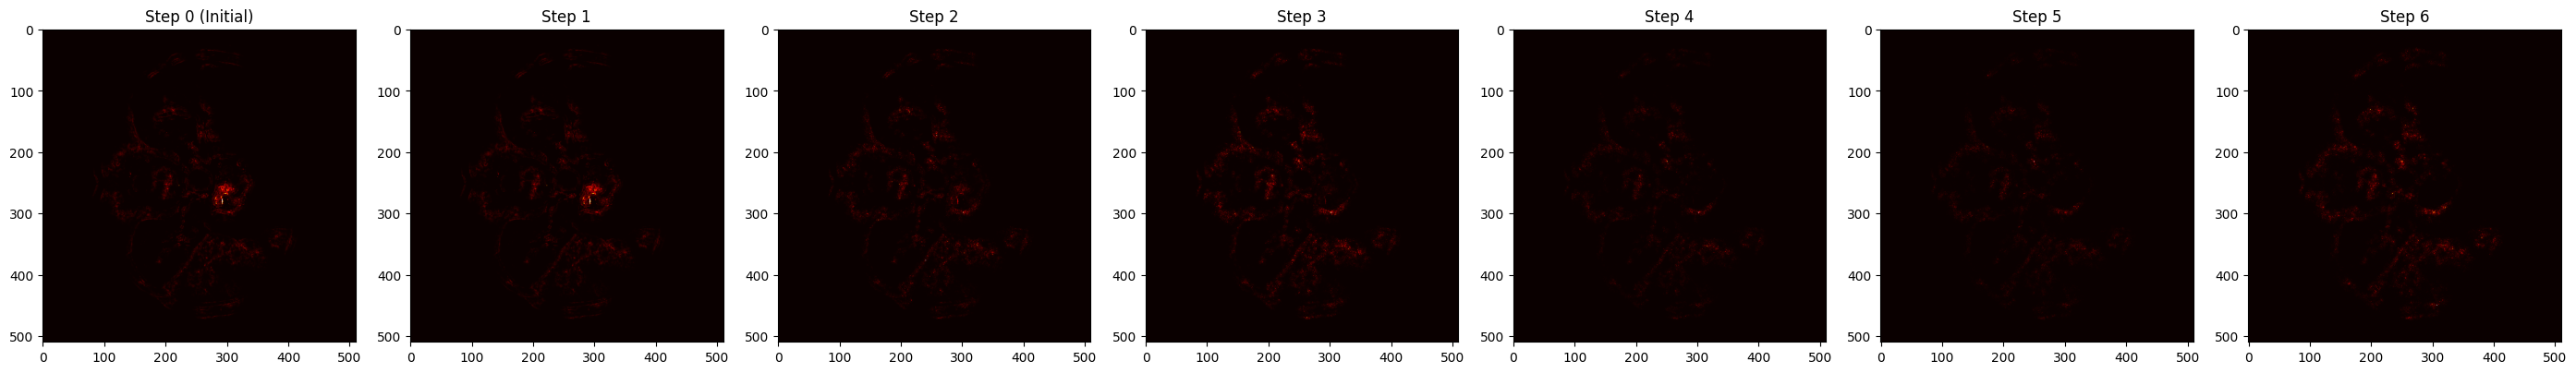

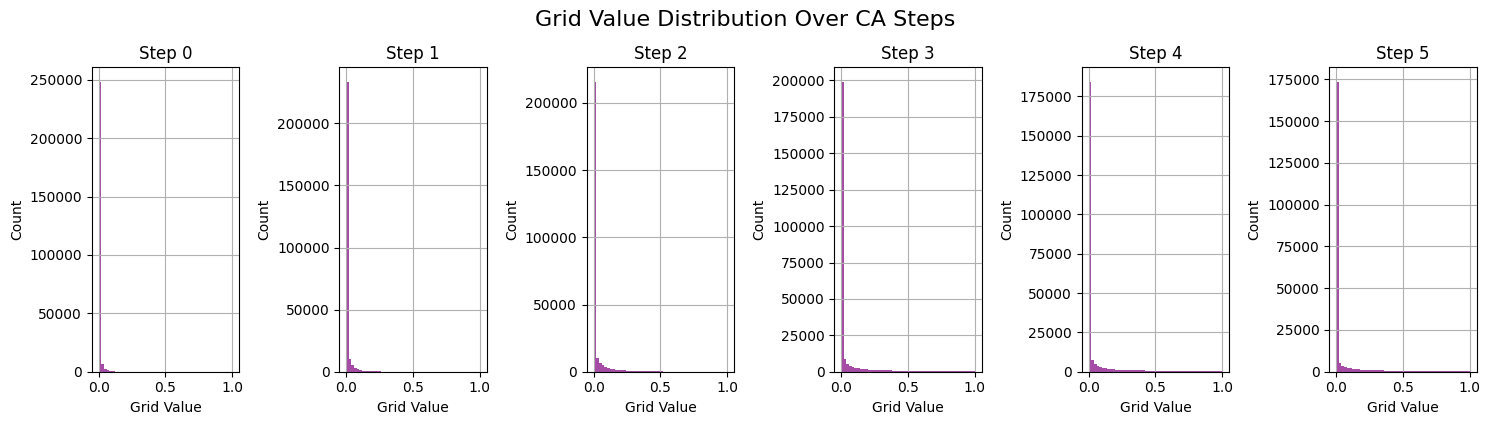

Running CA with c=3.0, alpha=0.9, beta=0.4


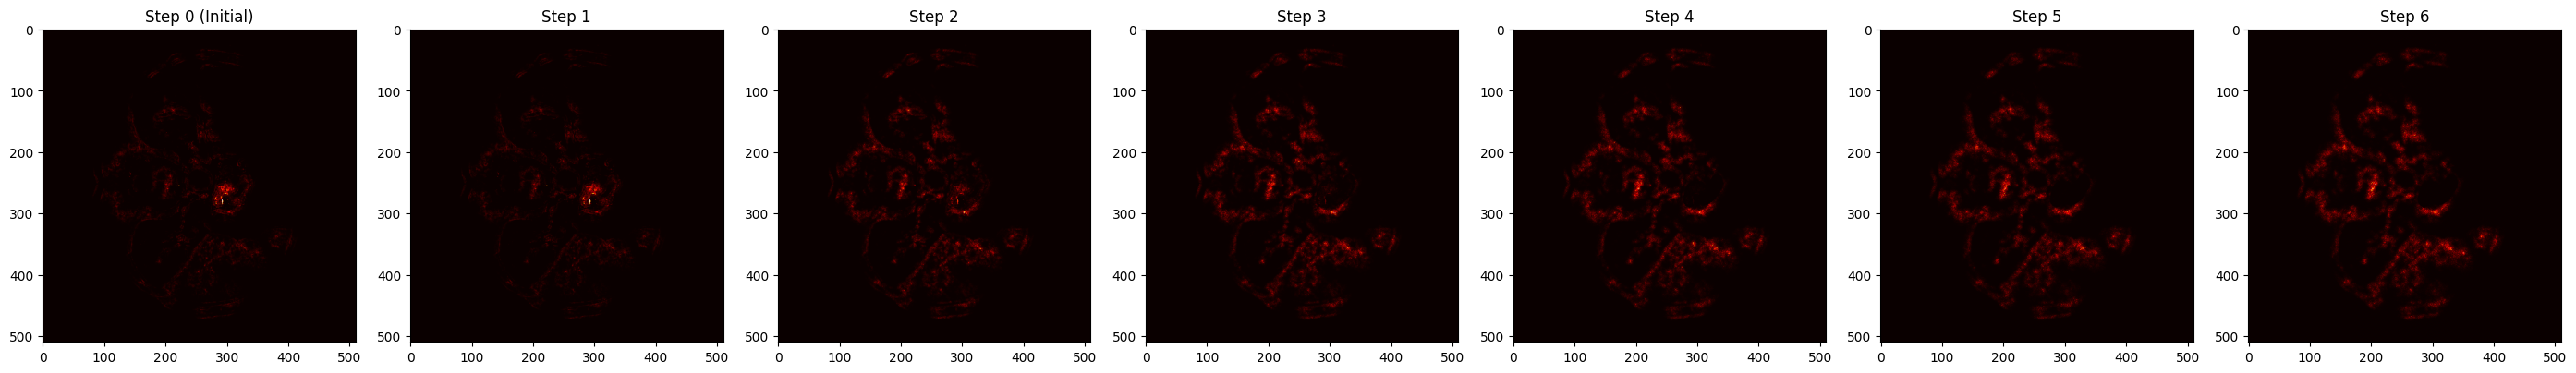

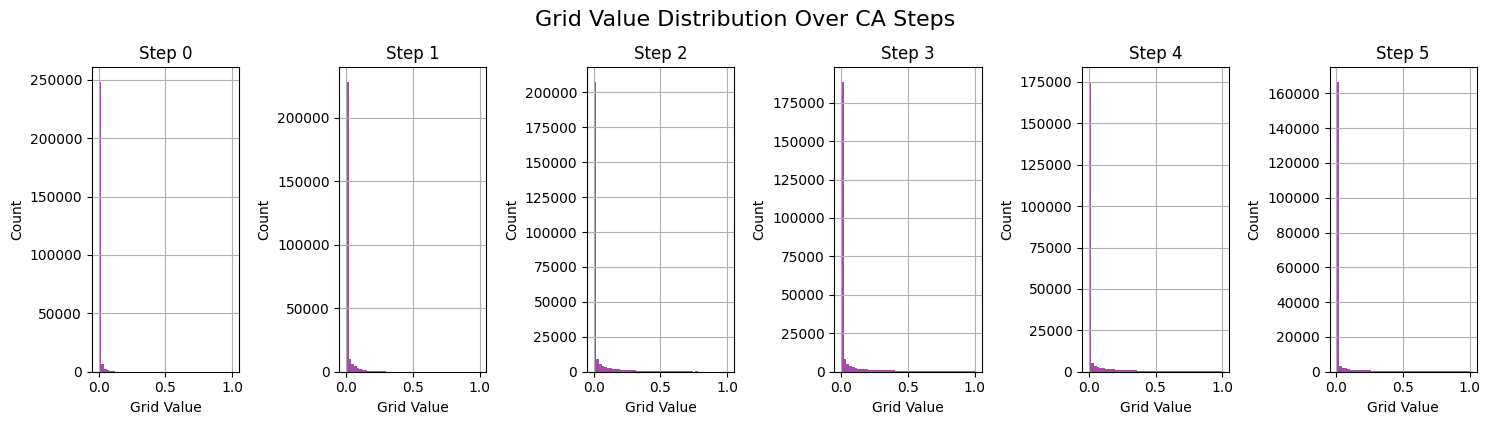

Running CA with c=3.0, alpha=0.9, beta=0.5


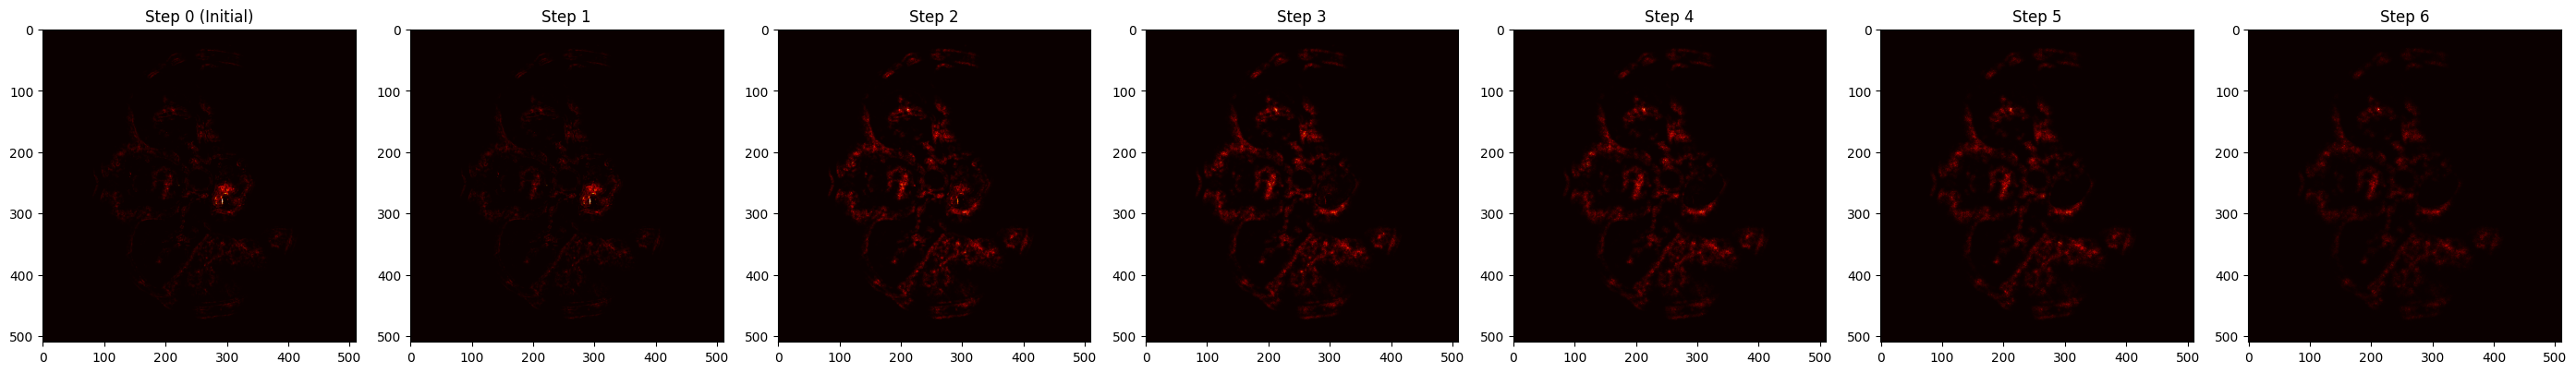

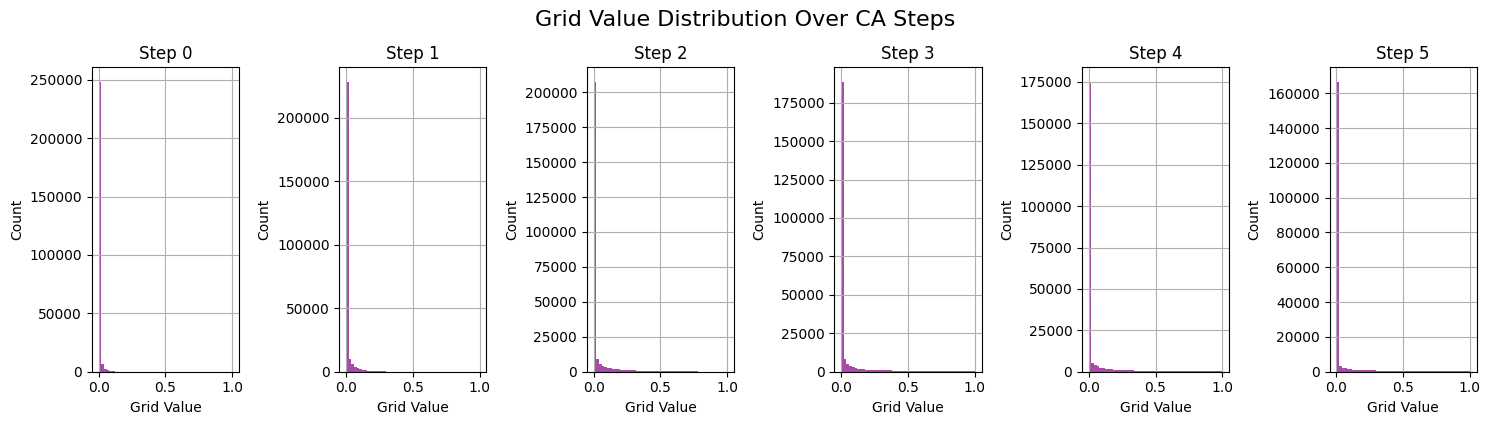

Running CA with c=3.0, alpha=1, beta=0.4


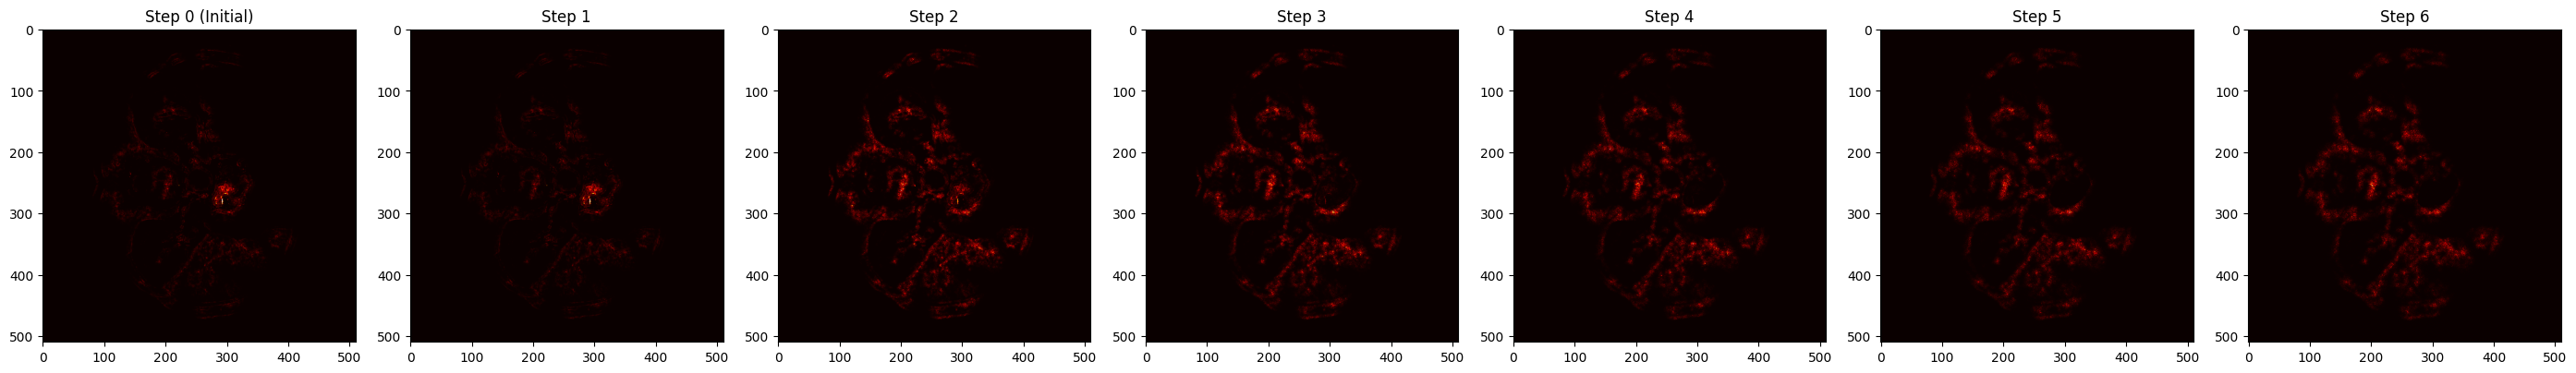

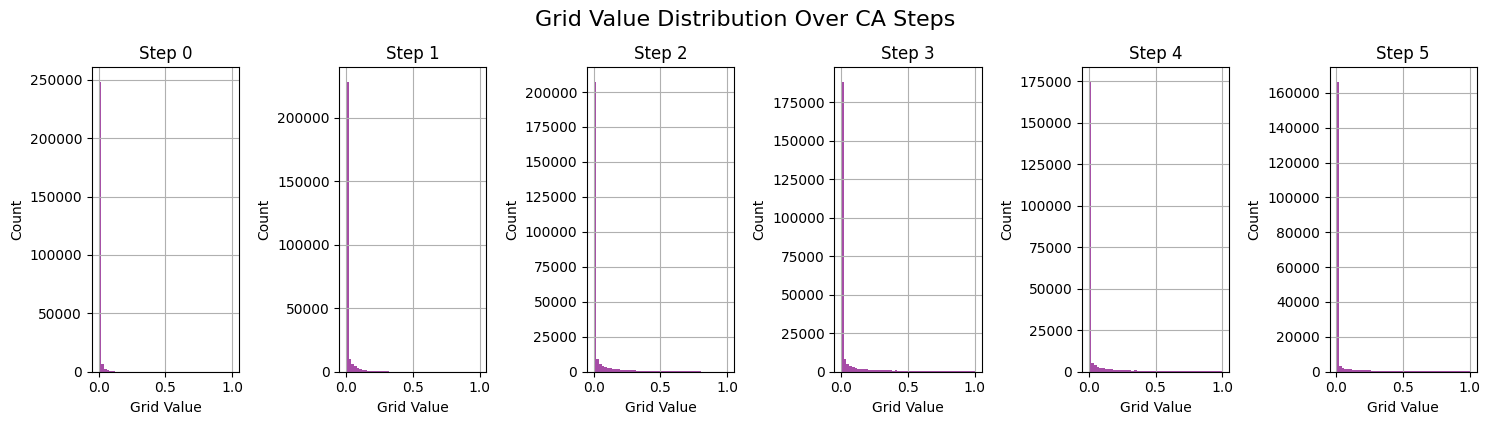

Running CA with c=3.0, alpha=1, beta=0.5


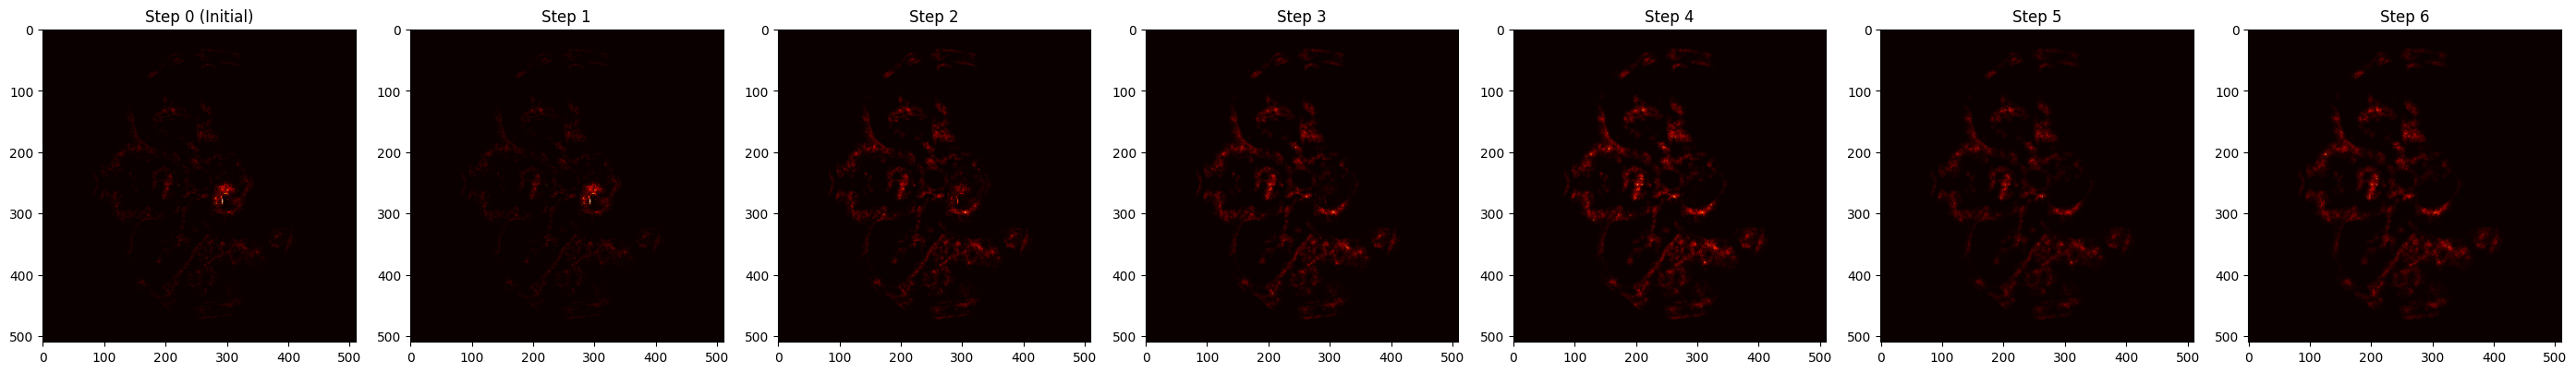

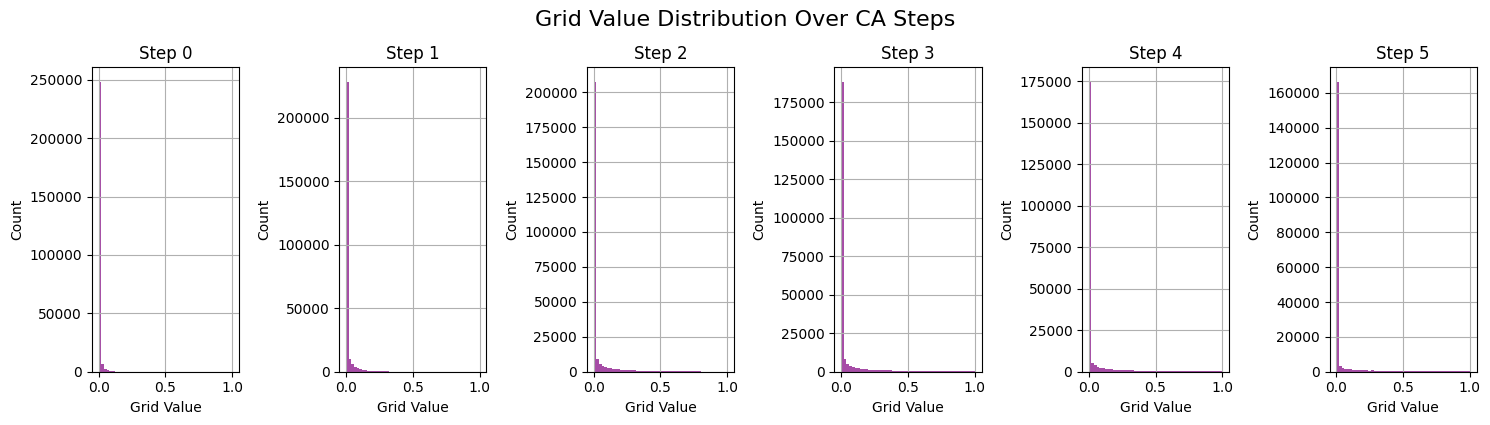

Running CA with c=3.0, alpha=2, beta=0.4


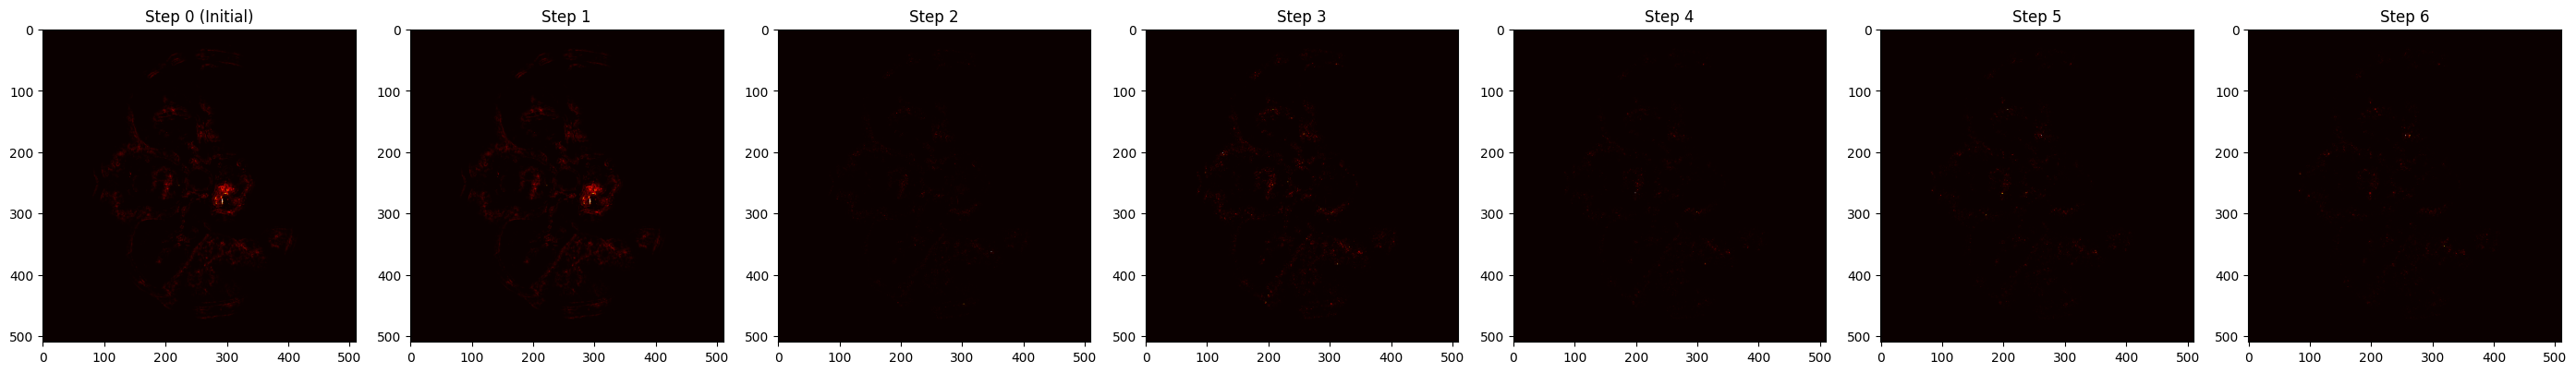

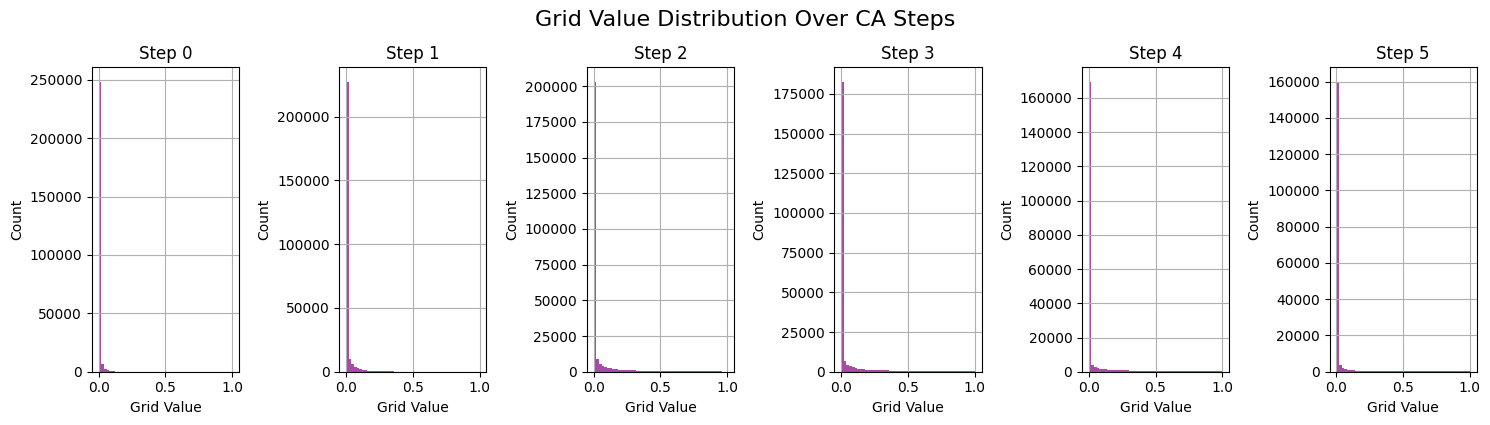

Running CA with c=3.0, alpha=2, beta=0.5


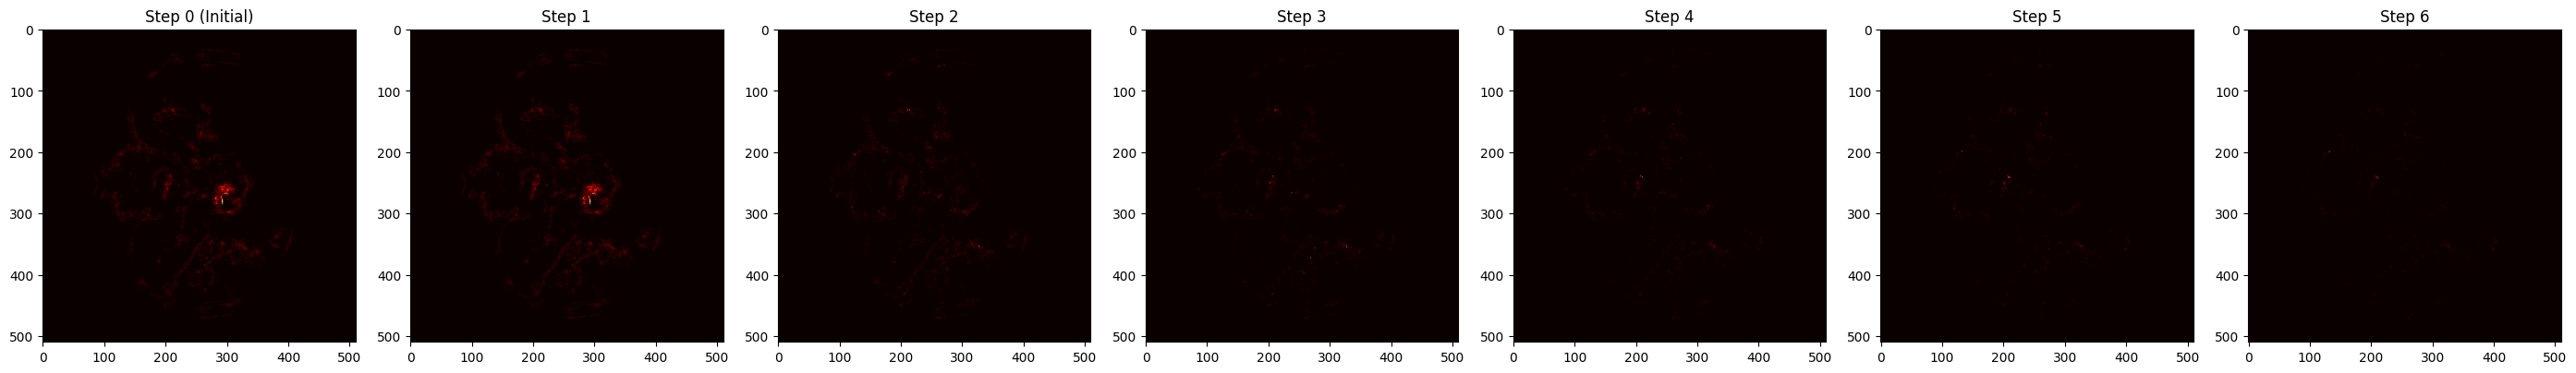

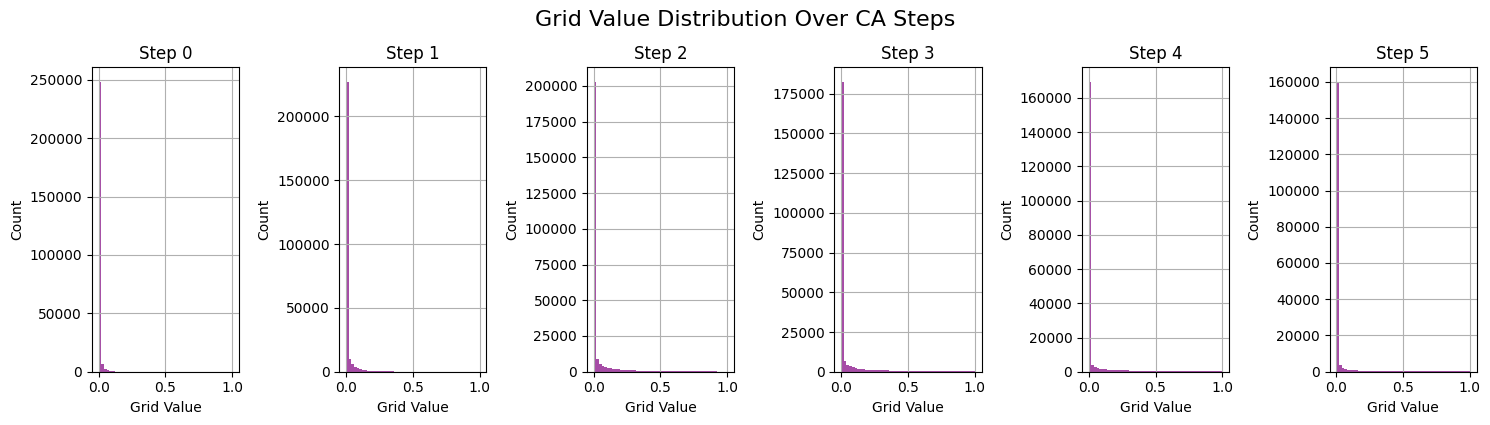

Running CA with c=3.0, alpha=1.5, beta=0.4


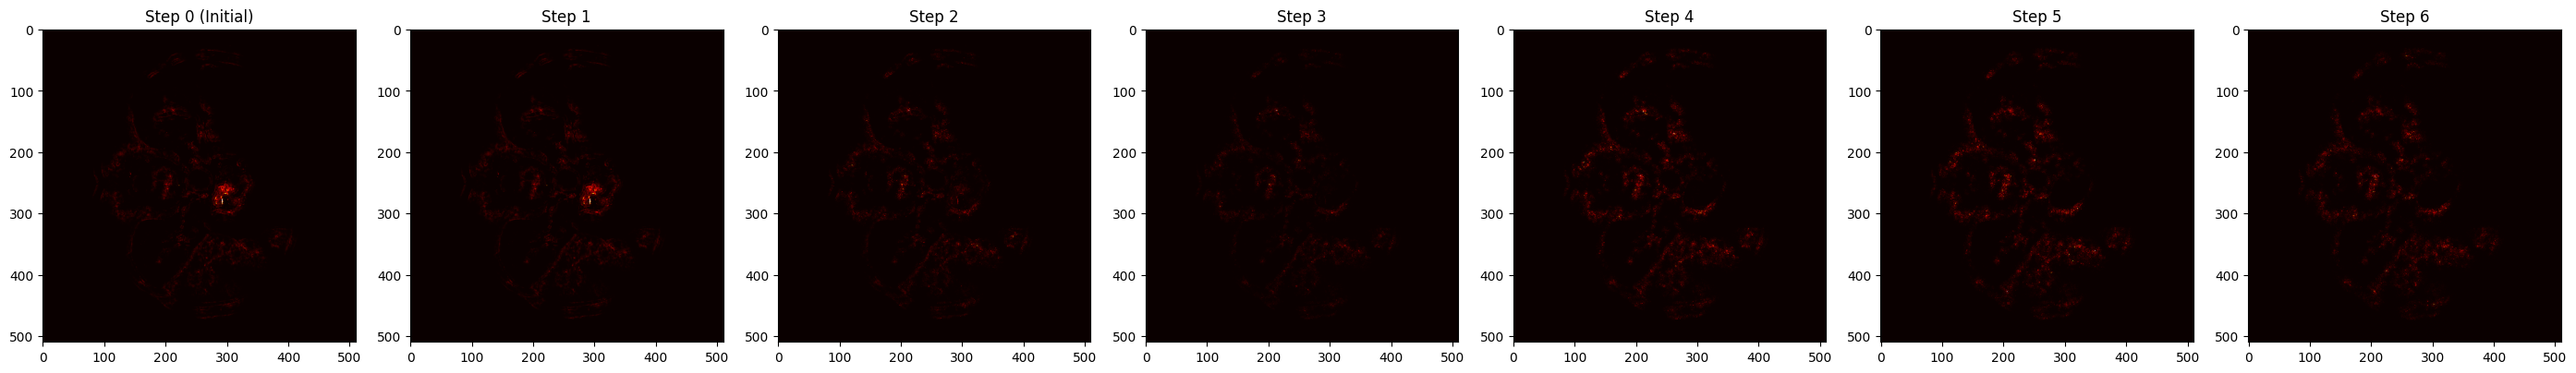

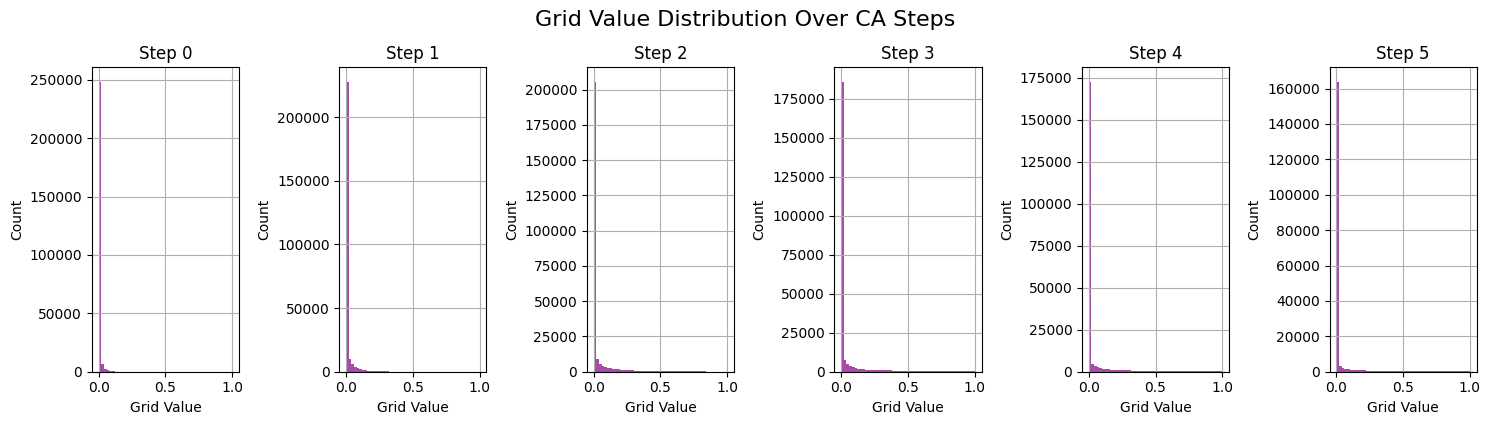

Running CA with c=3.0, alpha=1.5, beta=0.5


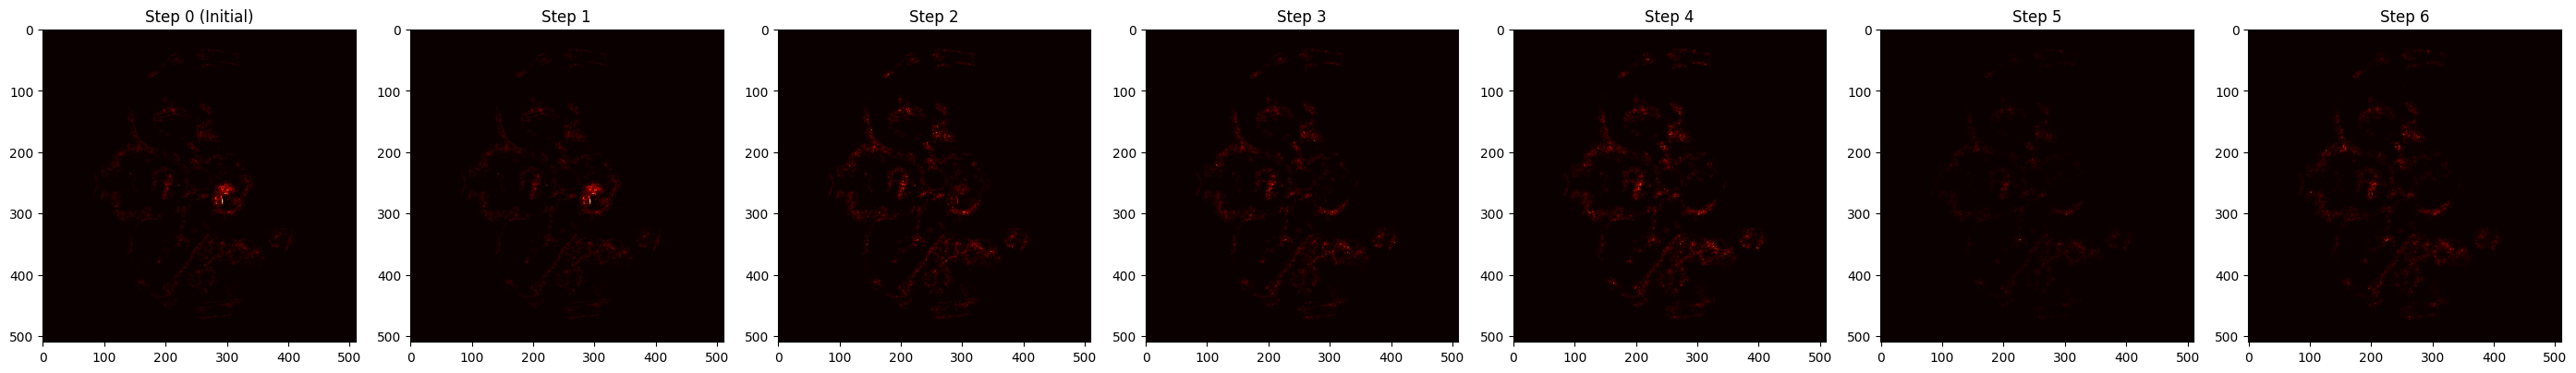

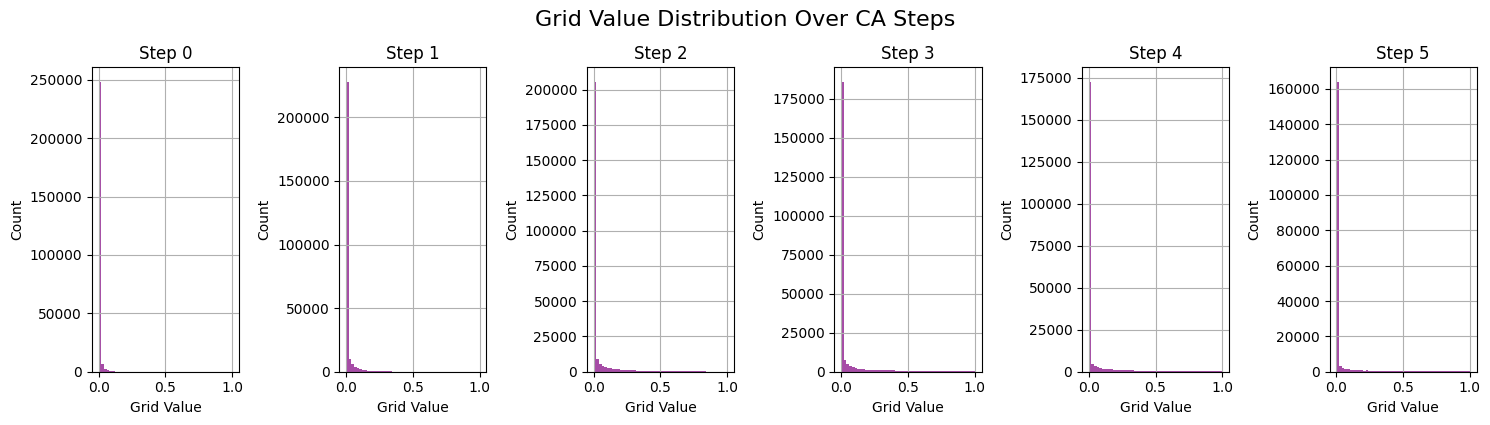

In [ ]:
# prompt: can we setup different parameter grid for c, alpha and beta and see how they are different plot visualize_ca_evolutiona and plot_grid_distributions for each combination in parameter grid

def run_ca_with_params(c, alpha, beta):
    step_outputs = ca_update(grid, label_grid, c=c, alpha=alpha, beta=beta, steps=5, return_steps=True)
    visualize_ca_evolution(grid, step_outputs)
    plot_grid_distributions(step_outputs)


# Define parameter grid
param_grid = {
    'c': [1.2, 2.0, 3.0],
    'alpha': [0.9, 1,2, 1.5],
    'beta': [0.4,0.5]
}

# Iterate over all combinations
for c in param_grid['c']:
    for alpha in param_grid['alpha']:
        for beta in param_grid['beta']:
            print(f"Running CA with c={c}, alpha={alpha}, beta={beta}")
            run_ca_with_params(c, alpha, beta)

Input: x

In [ ]:
new_grid = ca_update(grid, label_grid, c=1.2, alpha=0.9, beta=0.5, steps=5, return_steps=False)

In [ ]:
new_grid.shape

(510, 510)

In [ ]:
grid.shape

(510, 510)

In [ ]:
# import numpy as np

# def apply_transition_probs(label_grid, transition_matrix, seed=None):
#     """
#     Apply transition probabilities to a label grid.

#     Args:
#         label_grid: 2D numpy array of ints (labels: e.g., 0 = background, 1 = pancreas, 2 = cancer)
#         transition_matrix: 2D numpy array of shape (num_classes, num_classes) with transition probs.
#         seed: random seed for reproducibility.

#     Returns:
#         updated_grid: New label grid after applying transitions.
#         flipped_coords: List of (y, x) tuples where labels changed.
#     """
#     if seed is not None:
#         np.random.seed(seed)

#     h, w = label_grid.shape
#     updated_grid = label_grid.copy()
#     flipped_coords = []

#     for y in range(h):
#         for x in range(w):
#             current_label = label_grid[y, x]
#             probs = transition_matrix[current_label]
#             new_label = np.random.choice(len(probs), p=probs)
#             if new_label != current_label:
#                 updated_grid[y, x] = new_label
#                 flipped_coords.append((y, x))

#     return updated_grid, flipped_coords

In [ ]:
# prompt: save label_grid, grid and new_grid

import numpy as np

# Assuming label_grid, grid, and new_grid are already defined from the previous code

# Save label_grid as a NumPy binary file (.npy)
np.save('label_grid.npy', label_grid)

# Save grid as a NumPy binary file (.npy)
np.save('grid.npy', grid)

# Save new_grid as a NumPy binary file (.npy)
np.save('new_grid.npy', new_grid)

print("label_grid, grid, and new_grid saved successfully.")


label_grid, grid, and new_grid saved successfully.


In [ ]:
label_grid = np.load("/content/label_grid.npy")
grid = np.load("/content/grid.npy")

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

def visualize_label_grid_evolution(initial_label_grid, flip_history, steps, class_names=None):
    """
    Visualize the label grid over time based on flip history,
    with overlays highlighting flipped pixels in different colors depending on the flip type.
    """
    h, w = initial_label_grid.shape
    grids = [np.copy(initial_label_grid)]
    current_grid = np.copy(initial_label_grid)

    for step_flips in flip_history:
        for y, x, from_label, to_label in step_flips:
            current_grid[y, x] = to_label
        grids.append(np.copy(current_grid))

    # Define a high-contrast colormap
    colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red
    cmap = mcolors.ListedColormap(colors)
    bounds = [0, 1, 2, 3]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot
    fig, axes = plt.subplots(1, len(grids), figsize=(4 * len(grids), 4), constrained_layout=True)

    if len(grids) == 1:
        axes = [axes]  # Make sure axes is iterable when there's only one plot

    for i, grid in enumerate(grids):
        ax = axes[i]
        im = ax.imshow(grid, cmap=cmap, norm=norm)
        ax.set_title(f"Step {i}")
        ax.axis('off')

        # Overlay flipped pixels with different colors based on flip type
        if i > 0:
            flipped_1_to_2 = np.zeros_like(grid, dtype=bool)
            flipped_0_to_2 = np.zeros_like(grid, dtype=bool)
            flipped_2_to_1 = np.zeros_like(grid, dtype=bool)

            for y, x, from_label, to_label in flip_history[i - 1]:
                if from_label == 1 and to_label == 2:
                    flipped_1_to_2[y, x] = True
                elif from_label == 0 and to_label == 2:
                    flipped_0_to_2[y, x] = True
                elif from_label == 2 and to_label == 1:
                    flipped_2_to_1[y, x] = True

            # Add contours for each flip type
            ax.contour(flipped_1_to_2, levels=[0.5], colors='yellow', linewidths=0.8)
            ax.contour(flipped_0_to_2, levels=[0.5], colors='yellow', linewidths=0.8)
            ax.contour(flipped_2_to_1, levels=[0.5], colors='cyan', linewidths=0.8)

    # Colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', shrink=0.6, pad=0.05)
    if class_names:
        cbar.set_ticks([0, 1, 2])
        cbar.set_ticklabels(class_names)
    else:
        cbar.set_ticks([0, 1, 2])
        cbar.set_ticklabels(['Background', 'Pancreas', 'Cancer'])

    # Add custom legend for flip colors
    legend_handles = [
        Line2D([0], [0], color='yellow', lw=3, label="1 → 2"),
        Line2D([0], [0], color='magenta', lw=3, label="0 → 2"),
        Line2D([0], [0], color='cyan', lw=3, label="2 → 1")
    ]
    fig.legend(handles=legend_handles, loc='lower left', ncol=3, frameon=False, fontsize=10)

    plt.show()

In [ ]:
import numpy as np

def ca_update_with_markov_flips(
    grid, label_grid, transition_matrix, c=1.0, alpha=1.0, beta=1.0, steps=5, seed=None
):
    """
    Evolve a cancer probability grid using Cellular Automata.
    After each step, apply biologically constrained Markov-based label flips,
    including background → cancer transitions guided by CA probability and Markov limits.

    Parameters:
        grid (2D array): Initial cancer probability field
        label_grid (2D array): Known class labels (0 = background, 1 = pancreas, 2 = cancer)
        transition_matrix (3x3 array): Markov transition probabilities between classes
        c, alpha, beta: CA hyperparameters
        steps (int): Number of iterations
        seed (int): Random seed for reproducibility

    Returns:
        final_grid: CA-evolved probability grid
        final_label_grid: updated labels after Markov flips
        flip_history: list of flipped (y, x, from_label, to_label) at each step
    """
    if seed is not None:
        np.random.seed(seed)

    h, w = grid.shape
    flip_history = []

    const_mask = (label_grid != 0)  # Lock pancreas and cancer during CA

    for t in range(steps):
        new_grid = np.copy(grid)

        # === Step 1: CA Evolution ===
        for y in range(1, h - 1):
            for x in range(1, w - 1):
                if const_mask[y, x]:
                    continue

                neighborhood = grid[y - 1:y + 2, x - 1:x + 2]
                neighbor_mask = const_mask[y - 1:y + 2, x - 1:x + 2]
                mutable_neighbors = neighborhood * (~neighbor_mask)

                num_mutable = np.sum(~neighbor_mask)
                if num_mutable == 0:
                    continue

                omega = np.sum(mutable_neighbors) / num_mutable
                s = np.sign(np.sum(mutable_neighbors) + beta)
                gamma = np.random.uniform(0, 1)
                perturb = 1 + (-np.log(gamma)) ** alpha
                cons_prod = np.prod(~neighbor_mask.astype(int))
                denom = 1 + np.exp(-s) + 1e-6

                update = c * (1 / denom) * perturb * omega * cons_prod
                new_grid[y, x] = np.clip(update, 0, 1)

        # === Step 2: Markov Flips: Pancreas ⇄ Cancer ===
        flipped_coords = []
        valid_classes = [1, 2]

        for src_class in valid_classes:
            src_indices = np.argwhere(label_grid == src_class)
            if len(src_indices) == 0:
                continue

            for tgt_class in valid_classes:
                if src_class == tgt_class:
                    continue

                prob = transition_matrix[src_class, tgt_class]
                n_flip = int(prob * len(src_indices))
                if n_flip == 0:
                    continue

                weights = np.array([new_grid[y, x] for y, x in src_indices])
                weights = np.maximum(weights, 0)

                if np.count_nonzero(weights) < n_flip:
                    n_flip = np.count_nonzero(weights)
                    if n_flip == 0:
                        continue

                weights_sum = weights.sum()
                if weights_sum == 0:
                    continue
                weights /= weights_sum

                chosen_indices = src_indices[
                    np.random.choice(len(src_indices), size=n_flip, replace=False, p=weights)
                ]

                for y, x in chosen_indices:
                    label_grid[y, x] = tgt_class
                    flipped_coords.append((y, x, src_class, tgt_class))

        # === Step 3: Background → Cancer ===
        bg_indices = np.argwhere(label_grid == 0)
        p_bg_to_cancer = transition_matrix[0, 2]
        n_flip = int(p_bg_to_cancer * len(bg_indices))

        if n_flip > 0:
            weights = np.array([new_grid[y, x] for y, x in bg_indices])
            weights = np.maximum(weights, 0)

            non_zero_weights = np.count_nonzero(weights)
            if non_zero_weights < n_flip:
                n_flip = non_zero_weights

            weights_sum = weights.sum()
            if weights_sum > 0:
                weights /= weights_sum
                chosen_indices = bg_indices[
                    np.random.choice(len(bg_indices), size=n_flip, replace=False, p=weights)
                ]

                for y, x in chosen_indices:
                    label_grid[y, x] = 2  # Flip to cancer
                    flipped_coords.append((y, x, 0, 2))

        flip_history.append(flipped_coords)
        grid = new_grid

    return grid, label_grid, flip_history

In [ ]:
# Background = class 0, Pancreas = 1, Cancer = 2
transition_matrix = np.array([
    [0.90, 0.00, 0.10],  # Background: 2% may become cancer
    [0.00, 0.85, 0.15],  # Pancreas → Cancer
    [0.00, 0.20, 0.80],  # Cancer → Pancreas
])

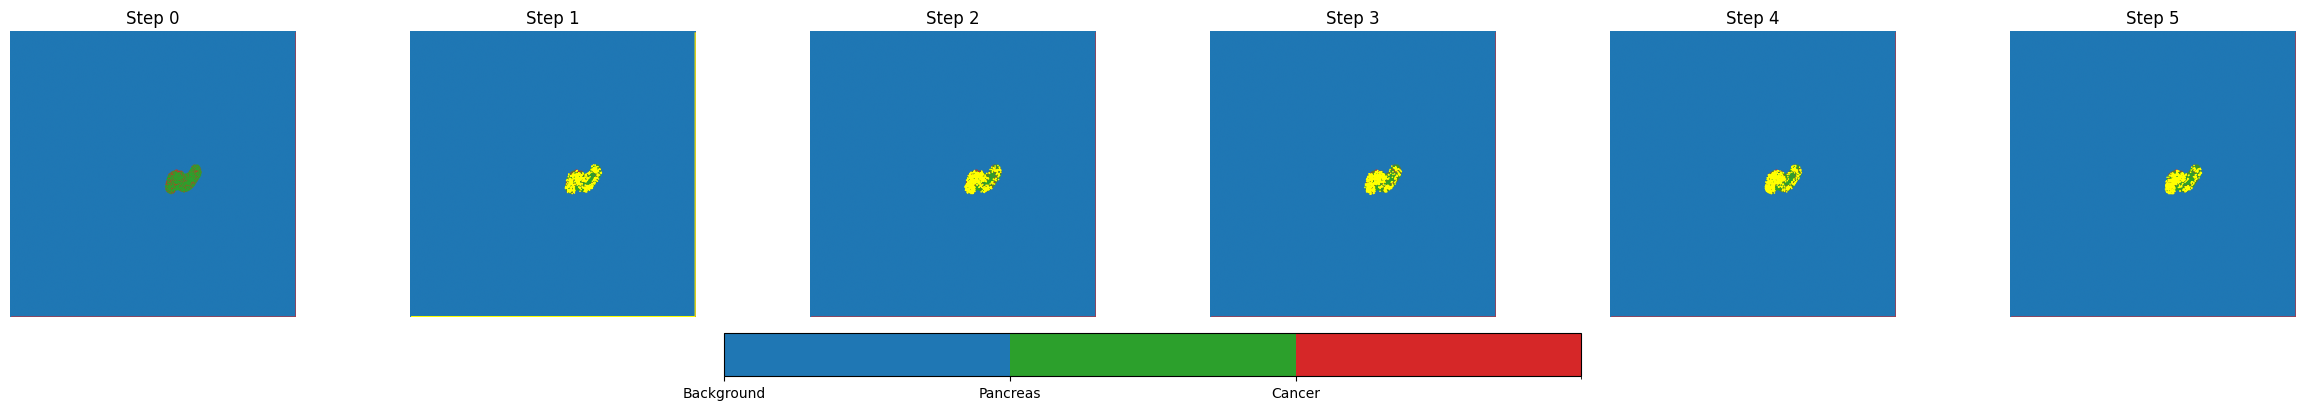

In [ ]:
final_grid, final_labels, flip_history = ca_update_with_markov_flips(
    grid, label_grid, transition_matrix,
    c=3, alpha=1.2, beta=0.5, steps=5, seed=42
)

visualize_label_grid_evolution(
    initial_label_grid=label_grid.copy(),
    flip_history=flip_history,
    steps=5,
    class_names=["Background", "Pancreas", "Cancer"]
)

In [ ]:
 flip_history

Using pixel2cancer

In [175]:
def compute_transition_matrices(label_grids, num_classes=3):
    """
    Compute transition matrices from a list of label grids over time.

    Args:
        label_grids (list of np.array): list of 2D label maps (T+1 steps)
        num_classes (int): number of label classes (default: 3)

    Returns:
        List of transition matrices (each shape: num_classes x num_classes)
    """
    transition_matrices = []

    for t in range(len(label_grids) - 1):
        grid_t = label_grids[t].flatten()
        grid_t1 = label_grids[t + 1].flatten()

        matrix = np.zeros((num_classes, num_classes), dtype=np.float32)

        for i in range(num_classes):
            indices_i = np.where(grid_t == i)[0]
            if len(indices_i) == 0:
                continue
            next_labels = grid_t1[indices_i]
            for j in range(num_classes):
                matrix[i, j] = np.sum(next_labels == j)

            # Normalize the transition probabilities for class i
            matrix[i, :] /= (np.clip(len(indices_i), 1, np.inf))  # Prevent division by zero

        transition_matrices.append(matrix)

    return transition_matrices

In [13]:
import nibabel as nib

# Replace with actual filenames
ct_img = nib.load("/content/pancreas_001.nii.gz")
label_img = nib.load("/content/pancreas_001_label.nii.gz")

ct_data = ct_img.get_fdata()         # shape: (H, W, D)
label_data = label_img.get_fdata()   # shape: (H, W, D)


In [14]:
tumor_slices = [i for i in range(label_data.shape[2]) if np.any(label_data[:, :, i] == 2)]
slice_idx = tumor_slices[len(tumor_slices) // 2]  # middle tumor slice

ct_hu_slice = ct_data[:, :, slice_idx]
label_slice = label_data[:, :, slice_idx]

In [15]:
def create_organ_map(ct_hu_slice):
    organ_map = np.zeros_like(ct_hu_slice, dtype=int)

    organ_map[(ct_hu_slice > -1000) & (ct_hu_slice <= -100)] = 1
    organ_map[(ct_hu_slice > -100) & (ct_hu_slice <= 100)] = 2
    organ_map[(ct_hu_slice > 100) & (ct_hu_slice <= 300)] = 3
    organ_map[(ct_hu_slice > 300)] = 4

    # Optional: vessels/barriers
    organ_map[(ct_hu_slice < -900) | (ct_hu_slice > 1000)] = 0
    return organ_map

In [16]:
organ_map = create_organ_map(ct_hu_slice)
organ_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
from scipy.ndimage import label, find_objects

def reduce_tumor_localized(label_slice, target_frac=0.1, seed=42):
    """
    Localized tumor reduction: Keeps a spatially coherent tumor region instead of random scatter.

    Args:
        label_slice (2D array): Label map with 0 (bg), 1 (pancreas), 2 (tumor)
        target_frac (float): Fraction of tumor pixels to keep
        seed (int): Random seed

    Returns:
        new_label (2D array): Modified label map with a small localized tumor
    """
    np.random.seed(seed)
    tumor_mask = (label_slice == 2)

    # Label tumor clusters
    labeled_tumors, num_clusters = label(tumor_mask)

    # Find slices for each cluster
    objects = find_objects(labeled_tumors)

    # Shuffle cluster indices to randomize
    cluster_indices = np.arange(1, num_clusters + 1)
    np.random.shuffle(cluster_indices)

    new_label = label_slice.copy()
    new_label[tumor_mask] = 1  # Reset tumor → pancreas

    total_tumor = np.sum(tumor_mask)
    target_tumor = int(total_tumor * target_frac)
    tumor_added = 0

    for idx in cluster_indices:
        if tumor_added >= target_tumor:
            break
        cluster_mask = (labeled_tumors == idx)
        coords = np.argwhere(cluster_mask)
        for y, x in coords:
            new_label[y, x] = 2
            tumor_added += 1
            if tumor_added >= target_tumor:
                break

    return new_label

In [18]:
label_reduced = reduce_tumor_localized(label_slice, target_frac=0.1)
initial_grid = np.zeros_like(label_reduced, dtype=int)

tumor_coords = np.argwhere(label_reduced == 2)
for y, x in tumor_coords:
    initial_grid[y, x] = np.random.randint(2, 5)  # start with lower growth

    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < label_slice.shape[0] and 0 <= nx < label_slice.shape[1]:
                if initial_grid[ny, nx] == 0 and label_reduced[ny, nx] == 1:
                    initial_grid[ny, nx] = 1

In [19]:
import numpy as np
from scipy.signal import convolve2d

def simulate_pixel2cancer(
    initial_grid,
    organ_map,
    steps=5,
    growth_prob=0.3,
    death_prob=0.2,
    pressure_threshold=2
):
    """
    Pixel2Cancer-style tumor growth simulator based on population dynamics.

    Args:
        initial_grid (2D np.array): Tumor population grid. 0 = no tumor, 1–10 = tumor state, -1 = dead cell.
        organ_map (2D np.array): Quantized tissue map (0 = vessel/boundary, 1–4 = tissue density).
        steps (int): Number of simulation iterations.
        growth_prob (float): Base probability for a tumor cell to grow (proliferate).
        death_prob (float): Probability of cell death if overpopulated.
        pressure_threshold (int): Neighbor pressure needed to invade resistant tissue.

    Returns:
        grids: list of tumor population grids (1 per time step)
    """
    grids = [initial_grid.copy()]
    current = initial_grid.copy()

    kernel = np.ones((3, 3), dtype=int)
    kernel[1, 1] = 0  # exclude center cell

    for _ in range(steps):
        neighbor_sum = convolve2d((current > 0).astype(int), kernel, mode='same', boundary='fill', fillvalue=0)
        next_grid = current.copy()

        # === Rule 1: Growth (self-proliferation)
        for y in range(current.shape[0]):
            for x in range(current.shape[1]):
                cell = current[y, x]
                if 0 < cell < 10:
                    prob = growth_prob * (cell + 1) / 10  # scaled growth prob
                    if np.random.rand() < prob:
                        next_grid[y, x] = min(cell + 1, 10)

        # === Rule 2: Invasion (push into neighbors)
        for y in range(1, current.shape[0] - 1):
            for x in range(1, current.shape[1] - 1):
                if current[y, x] > 0:
                    for dy in [-1, 0, 1]:
                        for dx in [-1, 0, 1]:
                            ny, nx = y + dy, x + dx
                            if dy == 0 and dx == 0:
                                continue
                            if organ_map[ny, nx] > 0 and current[ny, nx] == 0:
                                pressure = np.sum(current[y - 1:y + 2, x - 1:x + 2] == 10)
                                if pressure >= pressure_threshold:
                                    next_grid[ny, nx] = 1  # new tumor cell

        # === Rule 3: Death (if overcrowded)
        crowded = (current == 10) & (neighbor_sum >= 8)
        for y, x in zip(*np.where(crowded)):
            if np.random.rand() < death_prob:
                next_grid[y, x] = -1  # dead cell

        current = next_grid
        grids.append(current.copy())

    return grids

In [20]:
grids = simulate_pixel2cancer(
    initial_grid=initial_grid,
    organ_map=organ_map,
    steps=300,
    growth_prob=0.5,         # increased
    death_prob=0.0,          # disabled early on
    pressure_threshold=1     # relaxed to encourage invasion
)

In [193]:
len(grids)

301

In [194]:
label_grids = []
for grid in grids:
    label_map = np.zeros_like(grid)
    label_map[(grid > 0) & (grid < 11)] = 2  # tumor
    label_map[(label_slice == 1) & (label_map == 0)] = 1  #pancreas
    label_grids.append(label_map)

In [242]:
# prompt: save label_grids

import numpy as np
# Assuming label_grids is already defined from the previous code

# Save label_grids as a NumPy binary file (.npy)
np.save('label_grids.npy', np.array(label_grids))

print("label_grids saved successfully.")


label_grids saved successfully.


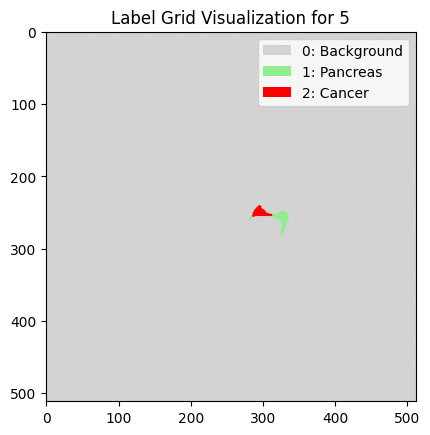

In [127]:
# prompt: plot label_grids[10] with legend 0:background, 1:pancreas, 2:cancer , similar to this code
# import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap  # Import ListedColormap
# import matplotlib.patches as mpatches
# # Assuming 'label_reduced' is a 2D numpy array
# # and you want to visualize it with the specified legend
# # Define custom colors for the classes
# colors = ['lightgray', 'lightgreen', 'red']  # Customize colors as needed
# cmap = ListedColormap(colors)
# plt.imshow(label_reduced, cmap=cmap, vmin=0, vmax=2)  # Adjust vmin and vmax as needed
# plt.title("Label Reduced Visualization")
# # Create legend handles
# legend_elements = [
#     mpatches.Patch(facecolor=colors[0], label='0: Background'),
#     mpatches.Patch(facecolor=colors[1], label='1: Pancreas'),
#     mpatches.Patch(facecolor=colors[2], label='2: Cancer')
# ]
# plt.legend(handles=legend_elements)
# plt.show()

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Assuming label_grids is defined and contains the label grids you want to plot

# Define custom colors for the classes
colors = ['lightgray', 'lightgreen', 'red']  # Customize colors as needed
cmap = ListedColormap(colors)
i=5
# Plot the 10th label grid (index 9)
plt.imshow(label_grids[i-1], cmap=cmap, vmin=0, vmax=2)  # Adjust vmin and vmax as needed

plt.title(f"Label Grid Visualization for {i}")

# Create legend handles
legend_elements = [
    mpatches.Patch(facecolor=colors[0], label='0: Background'),
    mpatches.Patch(facecolor=colors[1], label='1: Pancreas'),
    mpatches.Patch(facecolor=colors[2], label='2: Cancer')
]
plt.legend(handles=legend_elements)
plt.show()


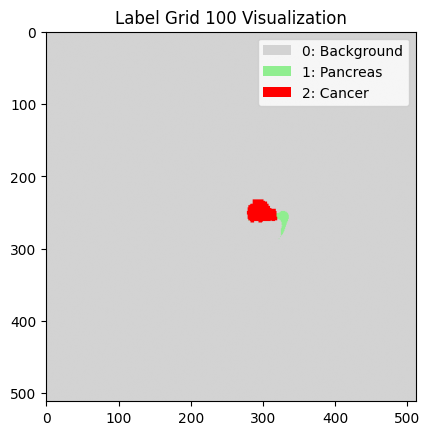

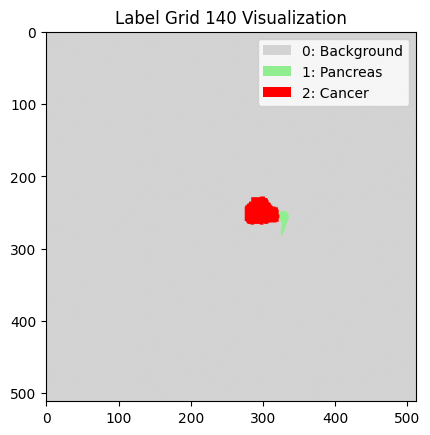

In [129]:
# prompt: similarly for label_grids[5] and label_grids[15]

import matplotlib.pyplot as plt
# Assuming label_grids is defined and contains the label grids you want to plot

# Define custom colors for the classes
colors = ['lightgray', 'lightgreen', 'red']  # Customize colors as needed
cmap = ListedColormap(colors)
i=100
# Plot the 5th label grid (index 4)
plt.imshow(label_grids[i-1], cmap=cmap, vmin=0, vmax=2)  # Adjust vmin and vmax as needed

plt.title(f"Label Grid {i} Visualization")

# Create legend handles
legend_elements = [
    mpatches.Patch(facecolor=colors[0], label='0: Background'),
    mpatches.Patch(facecolor=colors[1], label='1: Pancreas'),
    mpatches.Patch(facecolor=colors[2], label='2: Cancer')
]
plt.legend(handles=legend_elements)
plt.show()


j=140
plt.imshow(label_grids[j-1], cmap=cmap, vmin=0, vmax=2)  # Adjust vmin and vmax as needed

plt.title(f"Label Grid {j} Visualization")

# Create legend handles
legend_elements = [
    mpatches.Patch(facecolor=colors[0], label='0: Background'),
    mpatches.Patch(facecolor=colors[1], label='1: Pancreas'),
    mpatches.Patch(facecolor=colors[2], label='2: Cancer')
]
plt.legend(handles=legend_elements)
plt.show()


In [ ]:
# import numpy as np
# from scipy.signal import convolve2d

# def simulate_bio_conway(label_grid, steps=5, allow_regression=False):
#     """
#     Conway-style CA with 3-class biological state evolution.

#     Args:
#         label_grid (np.array): Initial label map with values 0 (bg), 1 (pancreas), 2 (cancer)
#         steps (int): Number of evolution steps
#         allow_regression (bool): If True, cancer can regress to pancreas when isolated

#     Returns:
#         label_grids: list of label maps over time
#     """
#     label_grids = [label_grid.copy()]
#     current = label_grid.copy()

#     # Define 3x3 neighborhood kernel
#     kernel = np.ones((3, 3), dtype=int)
#     kernel[1, 1] = 0  # exclude center pixel

#     for _ in range(steps):
#         pancreas_neighbors = convolve2d((current == 1).astype(int), kernel, mode='same', boundary='fill', fillvalue=0)
#         cancer_neighbors   = convolve2d((current == 2).astype(int), kernel, mode='same', boundary='fill', fillvalue=0)

#         next_grid = current.copy()

#         # Rule 1: Background → Pancreas
#         mask = (current == 0) & (pancreas_neighbors >= 3)
#         next_grid[mask] = 1

#         # Rule 2: Pancreas → Cancer
#         mask = (current == 1) & (cancer_neighbors >= 3)
#         next_grid[mask] = 2

#         # Rule 3 (Optional): Cancer → Pancreas (regression)
#         if allow_regression:
#             mask = (current == 2) & (cancer_neighbors < 2)
#             next_grid[mask] = 1

#         current = next_grid
#         label_grids.append(current.copy())

#     return label_grids

In [ ]:
#label_grids = simulate_bio_conway(label_grid, steps=30, allow_regression=False)

In [37]:
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

In [200]:
len(label_grids)

301

In [ ]:
# transitions = compute_transition_matrices(label_grids)
# transitions

In [244]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Lambda

###############################
# Utility Functions
###############################

def rowwise_softmax(x):
    """
    Enforce that each row of the 3x3 matrix (flattened as 9) forms a probability distribution.
    x has shape (batch, 9); reshape to (-1, 3, 3), apply softmax on last axis, then flatten.
    """
    x = tf.reshape(x, (-1, 3, 3))
    x = tf.nn.softmax(x, axis=-1)
    x = tf.reshape(x, (-1, 9))
    return x

def compute_transition_matrix(label_grid1, label_grid2, num_classes=3):
    """
    Compute the transition matrix from label_grid1 to label_grid2.
    Each (i,j) entry counts the number of pixels transitioning from state i to state j.
    Then normalize each row to get a probability distribution.
    """
    T = np.zeros((num_classes, num_classes))
    h, w = label_grid1.shape
    for y in range(h):
        for x in range(w):
            i = int(label_grid1[y, x])
            j = int(label_grid2[y, x])
            T[i, j] += 1
    # Normalize rows: if a row sum is zero, add a tiny epsilon
    row_sums = T.sum(axis=1, keepdims=True)
    T = T / (row_sums + 1e-6)
    return T

def compute_transitions_from_label_grids(label_grids):
    """
    Given a sequence of label grids, compute the transition matrix for each consecutive pair.
    Returns a list of transition matrices (each of shape (3,3)).
    """
    transitions = []
    for i in range(len(label_grids) - 1):
        T = compute_transition_matrix(label_grids[i], label_grids[i+1])
        transitions.append(T)
    return transitions

def prepare_training_data(transitions, timesteps=3):
    """
    Given a list of transition matrices, flatten each into a 9-element vector.
    Then, create sequences of length `timesteps` as input and the following transition as the output.

    X.shape will be (num_samples, timesteps, 9) and y.shape will be (num_samples, 9)
    """
    flat_transitions = [T.flatten() for T in transitions]
    X, y = [], []
    for i in range(len(flat_transitions) - timesteps):
        X.append(np.array(flat_transitions[i:i+timesteps]))
        y.append(flat_transitions[i+timesteps])
    X = np.array(X)
    y = np.array(y)
    return X, y

###############################
# Example: Generate Training Data
###############################

# Assume you have your simulated label grids from your simulation code.
# For instance:
# grids = simulate_pixel2cancer(initial_grid, organ_map, steps=300, growth_prob=0.5, death_prob=0.0, pressure_threshold=1)
# label_grids = []
# for grid in grids:
#     label_map = np.zeros_like(grid)
#     label_map[(grid > 0) & (grid < 11)] = 2  # tumor
#     label_map[(label_slice == 1) & (label_map == 0)] = 1  # pancreas
#     label_grids.append(label_map)
#
# For demonstration, let's assume label_grids is already available:
# label_grids = [...]  # list of numpy arrays, each with shape (H, W)

# Compute ground-truth transitions from label grids:
transitions = compute_transitions_from_label_grids(label_grids)

# Prepare training data from these transitions:
timesteps = 3
X_train, y_train = prepare_training_data(transitions, timesteps=timesteps)
print("X_train shape:", X_train.shape)  # Expected: (num_samples, 3, 9)
print("y_train shape:", y_train.shape)  # Expected: (num_samples, 9)

###############################
# Build the LSTM Model
###############################

n_features = 9  # Each transition matrix is flattened to a 9-element vector

lstm_model = Sequential()
lstm_model.add(Input(shape=(timesteps, n_features)))
lstm_model.add(LSTM(64, activation='relu'))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(n_features))
lstm_model.add(Lambda(rowwise_softmax))  # Ensure output rows sum to 1 (for a 3x3 matrix)
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

###############################
# Train the LSTM Model
###############################

lstm_model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2)


Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.1426 - val_loss: 0.1457
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1187 - val_loss: 0.1246
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0996 - val_loss: 0.1024
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0823 - val_loss: 0.0792
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0667 - val_loss: 0.0585
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0551 - val_loss: 0.0481
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0474 - val_loss: 0.0459
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0472 - val_loss: 0.0457
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0422 - val_loss: 0.0456
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0397 - val_loss: 0.0442
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0405 - val_loss: 0.0418
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0385 - val_l

In [203]:
X.shape

(299, 9)

In [245]:
# def ca_update_with_markov_flips_dynamic(
#     grid, label_grid, lstm_model, transition_history,
#     c=1.4, alpha=0.7, beta=1, steps=100, seed=42
# ):
#     if seed is not None:
#         np.random.seed(seed)

#     h, w = grid.shape
#     flip_history = []

#     # e.g., from label_slice (the GT mask before simulation)
#     const_mask = np.zeros_like(label_grid, dtype=bool)  # allow all updates

#     for t in range(steps):
#         new_grid = np.copy(grid)

#         # --- Predict next transition matrix using LSTM
#         last_matrix_flat = transition_history[-1].flatten().reshape((1, 1, 9))
#         predicted_matrix_flat = lstm_model.predict(last_matrix_flat)[0]
#         transition_matrix = predicted_matrix_flat.reshape((3, 3))
#         transition_matrix = transition_matrix / (transition_matrix.sum(axis=1, keepdims=True) + 1e-6)

#         # === Step 1: CA Evolution ===
#         for y in range(1, h - 1):
#             for x in range(1, w - 1):
#                 if const_mask[y, x]:
#                     continue
#                 neighborhood = grid[y - 1:y + 2, x - 1:x + 2]
#                 neighbor_mask = const_mask[y - 1:y + 2, x - 1:x + 2]
#                 mutable_neighbors = neighborhood * (~neighbor_mask)
#                 num_mutable = np.sum(~neighbor_mask)
#                 if num_mutable == 0:
#                     continue
#                 omega = np.sum(mutable_neighbors) / num_mutable
#                 s = np.sign(np.sum(mutable_neighbors) + beta)
#                 gamma = np.random.uniform(0, 1)
#                 perturb = 1 + (-np.log(gamma)) ** alpha
#                 cons_prod = np.prod(~neighbor_mask.astype(int))
#                 denom = 1 + np.exp(-s) + 1e-6
#                 update = c * (1 / denom) * perturb * omega * cons_prod
#                 new_grid[y, x] = np.clip(update, 0, 1)

#         # === Step 2: Markov-guided pancreas <-> cancer flipping ===
#         flipped_coords = []
#         for src_class in [1, 2]:
#             src_indices = np.argwhere(label_grid == src_class)
#             for tgt_class in [1, 2]:
#                 if tgt_class == src_class:
#                     continue
#                 prob = transition_matrix[src_class, tgt_class]
#                 n_flip = int(prob * len(src_indices))

#         if n_flip == 0 or len(src_indices) == 0:
#             continue

#         # ✅ Direction-aware weight logic
#         if src_class == 2 and tgt_class == 1:
#             # Cancer → Pancreas: inverse cancer probability
#             weights = 1.0 - np.array([new_grid[y, x] for y, x in src_indices])
#         else:
#             # Pancreas → Cancer: use direct cancer probability
#             weights = np.array([new_grid[y, x] for y, x in src_indices])

#         weights = np.maximum(weights, 0)
#         if np.count_nonzero(weights) < n_flip:
#             n_flip = np.count_nonzero(weights)
#         if weights.sum() == 0 or n_flip == 0:
#             continue

#         weights = weights.astype(np.float64)
#         weights /= weights.sum()

#         chosen = src_indices[np.random.choice(len(src_indices), size=n_flip, replace=False, p=weights)]
#         for y, x in chosen:
#             label_grid[y, x] = tgt_class
#             flipped_coords.append((y, x, src_class, tgt_class))

#         # === Step 3: Background -> Cancer ===
#         bg_indices = np.argwhere(label_grid == 0)
#         p_bg_to_cancer = transition_matrix[0, 2]
#         n_flip = int(p_bg_to_cancer * len(bg_indices))
#         weights = np.array([new_grid[y, x] for y, x in bg_indices])
#         weights = np.maximum(weights, 0)
#         if np.count_nonzero(weights) < n_flip: n_flip = np.count_nonzero(weights)
#         if weights.sum() > 0 and n_flip > 0:
#             weights /= weights.sum()
#             chosen = bg_indices[np.random.choice(len(bg_indices), size=n_flip, replace=False, p=weights)]
#             for y, x in chosen:
#                 label_grid[y, x] = 2
#                 flipped_coords.append((y, x, 0, 2))

#         flip_history.append(flipped_coords)
#         grid = new_grid.copy()  # ✅ ensures real update


#         # Append current matrix to transition history for next step
#         transition_history.append(transition_matrix)

#     return grid, label_grid, flip_history, transition_history

In [246]:
label_grid_ca = label_reduced.copy()                     # pancreas + trimmed tumor

In [221]:
grid_ca=np.load("grid.npy")

In [247]:
initial_transition_matrix = transitions[0]  # use the first known matrix
transition_history = [initial_transition_matrix]

grid_new_100, label_grid_new_100, flip_history, transition_history = ca_update_with_markov_flips_dynamic(
    grid=grid_ca,
    label_grid=label_grid_ca.copy(),
    lstm_model=model,
    transition_history=transition_history,
    steps=100
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

In [249]:
count_changed = 0
total = 0

for i in range(1, len(label_grids)):
    prev = label_grids[i-1]
    curr = label_grids[i]
    changed = (prev != curr).sum()
    count_changed += changed
    total += prev.size

print(f"Percentage of pixels that change between frames: {100 * count_changed / total:.4f}%")

Percentage of pixels that change between frames: 0.0047%


In [ ]:
#transitions

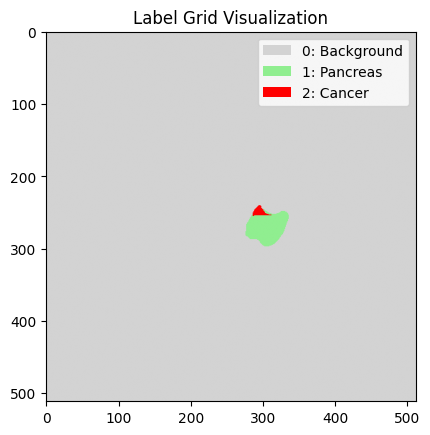

In [258]:
# prompt: plot label_grid generated from the previous step , legend it 0:background, 1:pancreas, 2:cancer

import matplotlib.pyplot as plt
# Assuming label_grid is defined from previous code

# Define custom colors for the classes
colors = ['lightgray', 'lightgreen', 'red']  # Customize colors as needed
cmap = ListedColormap(colors)

# Plot the label grid
plt.imshow(label_grid_new_100, cmap=cmap, vmin=0, vmax=2)

plt.title(f"Label Grid Visualization")

# Create legend handles
legend_elements = [
    mpatches.Patch(facecolor=colors[0], label='0: Background'),
    mpatches.Patch(facecolor=colors[1], label='1: Pancreas'),
    mpatches.Patch(facecolor=colors[2], label='2: Cancer')
]
plt.legend(handles=legend_elements)
plt.show()

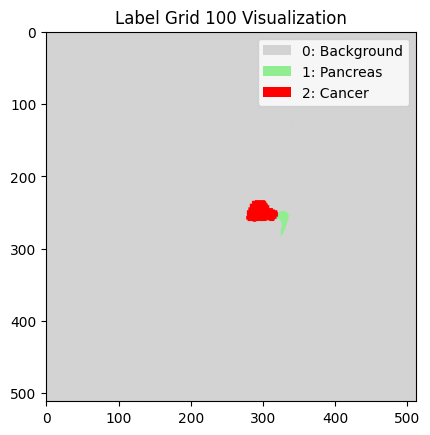

In [259]:
# prompt: plot label_grids[99] using colors = ['lightgray', 'lightgreen', 'red']  # Customize colors as needed
# cmap = ListedColormap(colors)

import matplotlib.pyplot as plt
# Assuming label_grids is defined and contains the label grids you want to plot

# Define custom colors for the classes
colors = ['lightgray', 'lightgreen', 'red']  # Customize colors as needed
cmap = ListedColormap(colors)

# Plot the 100th label grid (index 99)
plt.imshow(label_grids[99], cmap=cmap, vmin=0, vmax=2)  # Adjust vmin and vmax as needed

plt.title(f"Label Grid 100 Visualization")

# Create legend handles
legend_elements = [
    mpatches.Patch(facecolor=colors[0], label='0: Background'),
    mpatches.Patch(facecolor=colors[1], label='1: Pancreas'),
    mpatches.Patch(facecolor=colors[2], label='2: Cancer')
]
plt.legend(handles=legend_elements)
plt.show()

In [161]:
def dice_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    return 2.0 * intersection / (mask1.sum() + mask2.sum() + 1e-6)

# Binary masks for label 1 (pancreas) and label 2 (cancer)
pancreas_mask_1 = (label_grid_new_100 == 1)
pancreas_mask_2 = (label_grids[99] == 1)

cancer_mask_1 = (label_grid_new_100 == 2)
cancer_mask_2 = (label_grids[99] == 2)

dice_pancreas = dice_score(pancreas_mask_1, pancreas_mask_2)
dice_cancer = dice_score(cancer_mask_1, cancer_mask_2)

print(f"Pancreas Dice Similarity: {dice_pancreas:.4f}")
print(f"Cancer Dice Similarity: {dice_cancer:.4f}")

Pancreas Dice Similarity: 0.2549
Cancer Dice Similarity: 0.3082


In [162]:
def jaccard_index(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / (union + 1e-6)

jaccard_pancreas = jaccard_index(pancreas_mask_1, pancreas_mask_2)
jaccard_cancer = jaccard_index(cancer_mask_1, cancer_mask_2)

print(f"Pancreas Jaccard Index: {jaccard_pancreas:.4f}")
print(f"Cancer Jaccard Index: {jaccard_cancer:.4f}")

Pancreas Jaccard Index: 0.1461
Cancer Jaccard Index: 0.1822


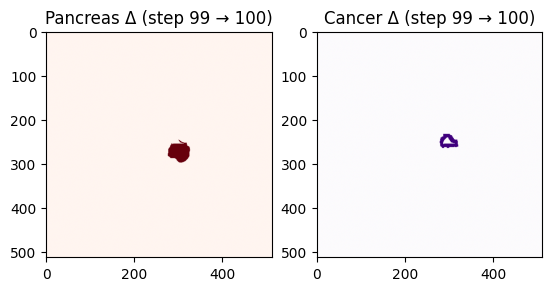

In [163]:
import matplotlib.pyplot as plt

diff_pancreas = (label_grid_new_100 == 1) ^ (label_grids[99] == 1)
diff_cancer = (label_grid_new_100 == 2) ^ (label_grids[99] == 2)

plt.subplot(1, 2, 1)
plt.title("Pancreas Δ (step 99 → 100)")
plt.imshow(diff_pancreas, cmap='Reds')

plt.subplot(1, 2, 2)
plt.title("Cancer Δ (step 99 → 100)")
plt.imshow(diff_cancer, cmap='Purples')

plt.show()

Rough-work for lstm (markov modelling below this)

In [55]:
# steps=10

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# def visualize_transition(grid_history, label_history, steps):
#     """
#     Visualizes the transitions of the grid and label grid over time as an animation.

#     Args:
#         grid_history (list): List of grids at each time step.
#         label_history (list): List of label grids at each time step.
#         steps (int): Number of simulation steps.
#     """
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#     # Initialize images for the grid and label grid
#     grid_img = ax[0].imshow(grid_history[0], cmap='viridis', animated=True)
#     label_img = ax[1].imshow(label_history[0], cmap='jet', animated=True)

#     ax[0].set_title('Tumor Grid')
#     ax[1].set_title('Label Grid')

#     # Update function for the animation
#     def update(frame):
#         # Update the images for each step
#         grid_img.set_data(grid_history[frame])
#         label_img.set_data(label_history[frame])

#         ax[0].set_title(f'Tumor Grid at Step {frame}')
#         ax[1].set_title(f'Label Grid at Step {frame}')
#         return grid_img, label_img

#     # Create the animation
#     ani = animation.FuncAnimation(fig, update, frames=steps, interval=500, blit=True)

#     plt.tight_layout()
#     plt.show()

# # Collecting the history of grids and labels during the simulation
# grid_history = [grid]  # Initialize with the first grid
# label_history = [label_grid]  # Initialize with the first label grid

# # Run the simulation and collect the grid and label data at each step
# for step in range(steps):
#     # Run 1 step of the CA update function
#     grid, label_grid, flip_history, transition_history = ca_update_with_markov_flips_dynamic(
#         grid=grid_ca,
#         label_grid=label_grid_ca,
#         lstm_model=model,
#         transition_history=transition_history,
#         steps=1  # Only update for 1 step at a time
#     )

#     grid_history.append(grid)  # Store the new grid
#     label_history.append(label_grid)  # Store the new label grid

# # Now, visualize the transition
# visualize_transition(grid_history, label_history, steps)

In [ ]:
# print(np.min(ct_hu_slice), np.max(ct_hu_slice))

-1024.0 3010.0


In [ ]:
# print("Unique organ levels:", np.unique(organ_map))

Unique organ levels: [0 1 2 3 4]


In [ ]:
# label_history

In [ ]:
# grid_history

In [59]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import matplotlib.patches as mpatches
# import numpy as np

# def animate_label_history(label_history, interval=500):
#     """
#     Animate label grids with proper color coding and legends:
#     0: Background, 1: Pancreas, 2: Cancer

#     Args:
#         label_history (list of np.array): List of label grids over time.
#         interval (int): Time between frames in milliseconds.
#     """
#     # Define colors: 0 → white, 1 → orange, 2 → red
#     from matplotlib.colors import ListedColormap
#     cmap = ListedColormap(["white", "orange", "red"])

#     fig, ax = plt.subplots(figsize=(6, 6))
#     im = ax.imshow(label_history[0], cmap=cmap, vmin=0, vmax=2)

#     # Add legend manually
#     legend_patches = [
#         mpatches.Patch(color='white', label='Background (0)'),
#         mpatches.Patch(color='orange', label='Pancreas (1)'),
#         mpatches.Patch(color='red', label='Cancer (2)')
#     ]
#     ax.legend(handles=legend_patches, loc='upper right')
#     ax.set_title("Label Grid Evolution")

#     def update(frame):
#         im.set_data(label_history[frame])
#         ax.set_title(f"Label Grid - Step {frame}")
#         return [im]

#     ani = animation.FuncAnimation(fig, update, frames=len(label_history), interval=interval, blit=True)
#     plt.tight_layout()
#     plt.show()

In [ ]:
# animate_label_history(label_history)

In [ ]:
# # prompt: plot labeled_grid_ca

# import matplotlib.pyplot as plt

# def visualize_label_grid_ca(label_grid_ca):
#     plt.imshow(label_grid_ca, cmap='viridis')
#     plt.title('Label Grid CA')
#     plt.colorbar(label='Label Value')
#     plt.show()

# visualize_label_grid_ca(label_grid_ca)


In [66]:
# from scipy.ndimage import label, find_objects

# def reduce_tumor_localized(label_slice, target_frac=0.1, seed=42):
#     """
#     Localized tumor reduction: Keeps a spatially coherent tumor region instead of random scatter.

#     Args:
#         label_slice (2D array): Label map with 0 (bg), 1 (pancreas), 2 (tumor)
#         target_frac (float): Fraction of tumor pixels to keep
#         seed (int): Random seed

#     Returns:
#         new_label (2D array): Modified label map with a small localized tumor
#     """
#     np.random.seed(seed)
#     tumor_mask = (label_slice == 2)

#     # Label tumor clusters
#     labeled_tumors, num_clusters = label(tumor_mask)

#     # Find slices for each cluster
#     objects = find_objects(labeled_tumors)

#     # Shuffle cluster indices to randomize
#     cluster_indices = np.arange(1, num_clusters + 1)
#     np.random.shuffle(cluster_indices)

#     new_label = label_slice.copy()
#     new_label[tumor_mask] = 1  # Reset tumor → pancreas

#     total_tumor = np.sum(tumor_mask)
#     target_tumor = int(total_tumor * target_frac)
#     tumor_added = 0

#     for idx in cluster_indices:
#         if tumor_added >= target_tumor:
#             break
#         cluster_mask = (labeled_tumors == idx)
#         coords = np.argwhere(cluster_mask)
#         for y, x in coords:
#             new_label[y, x] = 2
#             tumor_added += 1
#             if tumor_added >= target_tumor:
#                 break

#     return new_label

In [112]:
# label_reduced_temp = reduce_tumor_localized(label_slice, target_frac=0.1)

In [ ]:


# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# from matplotlib.colors import ListedColormap

# # Assuming label_reduced_temp is defined from the previous code

# # Define custom colors for the classes
# colors = ['lightgray', 'lightgreen', 'red']  # Customize colors as needed
# cmap = ListedColormap(colors)

# # Plot the label grid
# plt.imshow(label_reduced_temp, cmap=cmap, vmin=0, vmax=2)

# plt.title("Label Grid Visualization")

# # Create legend handles
# legend_elements = [
#     mpatches.Patch(facecolor=colors[0], label='0: Background'),
#     mpatches.Patch(facecolor=colors[1], label='1: Pancreas'),
#     mpatches.Patch(facecolor=colors[2], label='2: Cancer')
# ]
# plt.legend(handles=legend_elements)
# plt.show()


MARKOV Modelling

In [251]:
# prompt: find how many cells changed from label_grids[0] and label_grids[100] and compute transition probability matrix between  the three states

import numpy as np
# Load the saved label grids
label_grids = np.load('/content/label_grids.npy')

# Calculate the number of changed cells between label_grids[0] and label_grids[100]
changed_cells = np.sum(label_grids[0] != label_grids[99])
print(f"Number of cells changed between label_grids[0] and label_grids[100]: {changed_cells}")

# Compute the transition probability matrix between the three states (0, 1, 2)
def compute_transition_matrix(grid1, grid2, num_classes=3):
    matrix = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            matrix[i, j] = np.sum((grid1 == i) & (grid2 == j))
    row_sums = matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    return matrix / row_sums


transition_matrix_0_to_100 = compute_transition_matrix(label_grids[0], label_grids[99])
print("Transition matrix between label_grids[0] and label_grids[100]:\n", transition_matrix_0_to_100)


Number of cells changed between label_grids[0] and label_grids[100]: 751
Transition matrix between label_grids[0] and label_grids[100]:
 [[0.99739247 0.         0.00260753]
 [0.         0.80779944 0.19220056]
 [0.         0.         1.        ]]


In [253]:

import numpy as np

# Load the saved label grids
label_grids = np.load('/content/label_grids.npy')

# Load the transition matrix
transition_matrix = np.array([[0.99739247, 0.        , 0.00260753],
                              [0.        , 0.80779944, 0.19220056],
                              [0.        , 0.        , 1.        ]])

def apply_transition_probs(label_grid, transition_matrix, seed=None):
    """Applies transition probabilities to a label grid."""
    if seed is not None:
        np.random.seed(seed)
    h, w = label_grid.shape
    updated_grid = label_grid.copy()
    for y in range(h):
        for x in range(w):
            current_label = label_grid[y, x]
            probs = transition_matrix[int(current_label)]
            new_label = np.random.choice(len(probs), p=probs)
            updated_grid[y, x] = new_label
    return updated_grid

# Apply the transition matrix to label_grids[100] to get the 200th step
label_grid_200 = apply_transition_probs(label_grids[99], transition_matrix)

# Now label_grid_200 contains the label grid at the 200th step
# You can further process or visualize it


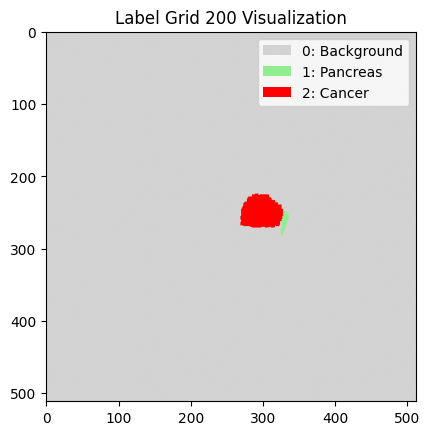

In [255]:
import matplotlib.pyplot as plt

# Define custom colors for the classes
colors = ['lightgray', 'lightgreen', 'red']  # Customize colors as needed
cmap = ListedColormap(colors)

# Plot the 200th label grid (index 199)
plt.imshow(label_grids[199], cmap=cmap, vmin=0, vmax=2)  # Adjust vmin and vmax as needed

plt.title(f"Label Grid 200 Visualization")

# Create legend handles
legend_elements = [
    mpatches.Patch(facecolor=colors[0], label='0: Background'),
    mpatches.Patch(facecolor=colors[1], label='1: Pancreas'),
    mpatches.Patch(facecolor=colors[2], label='2: Cancer')
]
plt.legend(handles=legend_elements)
plt.show()

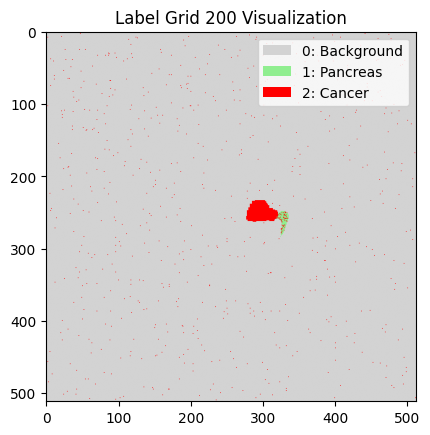

In [254]:
import matplotlib.pyplot as plt
# Assuming label_grid_200 is defined from previous code

# Define custom colors for the classes
colors = ['lightgray', 'lightgreen', 'red']  # Customize colors as needed
cmap = ListedColormap(colors)

# Plot the label grid
plt.imshow(label_grid_200, cmap=cmap, vmin=0, vmax=2)

plt.title(f"Label Grid 200 Visualization")

# Create legend handles
legend_elements = [
    mpatches.Patch(facecolor=colors[0], label='0: Background'),
    mpatches.Patch(facecolor=colors[1], label='1: Pancreas'),
    mpatches.Patch(facecolor=colors[2], label='2: Cancer')
]
plt.legend(handles=legend_elements)
plt.show()


In [256]:
# prompt: find spatial similarity between label_grid_200 and label_grids[199] for cancer cells - jaccard and Dice

import numpy as np
def jaccard_index(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / (union + 1e-6)

def dice_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    return 2.0 * intersection / (mask1.sum() + mask2.sum() + 1e-6)

# Cancer masks
cancer_mask_200 = (label_grid_200 == 2)
cancer_mask_199 = (label_grids[199] == 2)

# Calculate Jaccard and Dice for cancer
jaccard_cancer = jaccard_index(cancer_mask_200, cancer_mask_199)
dice_cancer = dice_score(cancer_mask_200, cancer_mask_199)

print(f"Jaccard similarity for cancer cells: {jaccard_cancer}")
print(f"Dice similarity for cancer cells: {dice_cancer}")

Jaccard similarity for cancer cells: 0.34021665526736067
Dice similarity for cancer cells: 0.5077039655196505


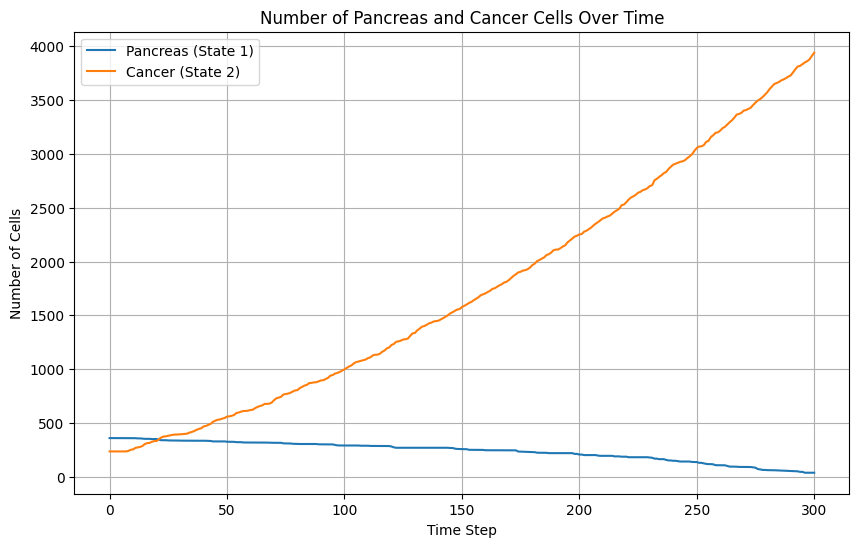

In [262]:
# prompt: plot how number of state 1 (pancreas) and state 2 (cancer) change in label_grids over the full length of time steps

import numpy as np
import matplotlib.pyplot as plt

# Assuming label_grids is loaded from 'label_grids.npy'
label_grids = np.load('/content/label_grids.npy')

# Extract state counts over time
time_steps = range(len(label_grids))
state1_counts = [np.sum(grid == 1) for grid in label_grids]  # Pancreas (state 1)
state2_counts = [np.sum(grid == 2) for grid in label_grids]  # Cancer (state 2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps, state1_counts, label='Pancreas (State 1)')
plt.plot(time_steps, state2_counts, label='Cancer (State 2)')
plt.xlabel('Time Step')
plt.ylabel('Number of Cells')
plt.title('Number of Pancreas and Cancer Cells Over Time')
plt.legend()
plt.grid(True)
plt.show()

LSTM

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load data
data = pd.read_csv("tumor_pixel_features.csv")

# Feature columns (exclude 'x', 'y', 'label')
features = [col for col in data.columns if col not in ['x', 'y', 'label']]
X = data[features].values
y = data['label'].values  # Multi-class: 0 (background), 1 (pancreas), 2 (cancer)
coords = data[['x', 'y']].values    # Coordinates are floats, later will be converted to int

# # Split and train SVM
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# svm_model = make_pipeline(StandardScaler(), SVC(probability=True, kernel='rbf', decision_function_shape='ovr'))
# svm_model.fit(X_train, y_train)
# probs = svm_model.predict_proba(X)  # shape: (N, 3) for 3 classes

probs=np.load('/content/probs.npy')

# Determine the grid dimensions.
# Here we assume the x coordinate corresponds to column index and y to row index.
coords_int = np.round(coords).astype(int)
xmax = int(coords_int[:, 0].max()) + 1
ymax = int(coords_int[:, 1].max()) + 1
grid_shape = (ymax, xmax)

def make_probability_grid(coords, probs, grid_shape, class_index=2):
    """
    Create a 2D grid with shape grid_shape where each cell value
    is the probability for the specified class_index.

    If multiple data points fall in the same grid cell, compute the average.
    """
    grid = np.zeros(grid_shape, dtype=float)
    count = np.zeros(grid_shape, dtype=float)

    for (x, y), p in zip(coords, probs):
        # Use the integer coordinates as the grid indices.
        xi, yi = int(x), int(y)
        grid[yi, xi] += p[class_index]  # if you want cancer probability, use p[2]
        count[yi, xi] += 1

    # Average the values in cells that have multiple entries.
    # Avoid dividing by zero.
    nonzero = count > 0
    grid[nonzero] = grid[nonzero] / count[nonzero]
    return grid

# Create a cancer probability grid: each cell holds the probability of cancer.
cancer_grid = make_probability_grid(coords_int, probs, grid_shape, class_index=2)

# (Optional) Similarly, you can create grids for background and pancreas:
background_grid = make_probability_grid(coords_int, probs, grid_shape, class_index=0)
pancreas_grid = make_probability_grid(coords_int, probs, grid_shape, class_index=1)

# Inspect shapes and possibly visualize:
print("Grid shape:", grid_shape)
print("Cancer grid sample:")
print(cancer_grid)

Grid shape: (510, 510)
Cancer grid sample:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.49194632e-08 ... 5.73414042e-08
  5.73718528e-08 5.74023101e-08]
 ...
 [0.00000000e+00 0.00000000e+00 5.49688920e-08 ... 5.69718108e-08
  5.69899780e-08 5.70081604e-08]
 [0.00000000e+00 0.00000000e+00 5.49897146e-08 ... 5.69958191e-08
  5.70140058e-08 5.70322073e-08]
 [0.00000000e+00 0.00000000e+00 5.50107159e-08 ... 5.70198532e-08
  5.70380592e-08 5.70562784e-08]]


In [3]:
import numpy as np
import tensorflow as tf

def compute_desired_counts(total, prob_vector):
    """
    Given a total number of candidate cells and a probability vector (e.g. [0.2, 0.2, 0.6]),
    compute the desired count of cells for each target state so that the counts sum to total.
    """
    desired = np.floor(total * prob_vector).astype(int)
    remainder = total - np.sum(desired)
    # Distribute remainder based on highest fractional parts.
    fractional = total * prob_vector - desired
    if remainder > 0:
        add_indices = np.argsort(-fractional)[:remainder]
        for idx in add_indices:
            desired[idx] += 1
    return desired

def ca_update_with_markov_flips_dynamic(
    grid, label_grid, lstm_model, transition_history,
    c=1.4, alpha=0.7, beta=1, steps=100, seed=42
):
    """
    Performs a CA update wherein:
      1. A continuous new_grid is computed by CA evolution.
      2. The LSTM predicts a transition matrix that provides ratios of how many cells
         from each source state should be assigned to each target state.
      3. For each source state (0, 1, 2), we update label_grid such that—for that row’s
         probabilities—all candidate cells are reassigned in the exact ratios.

    The new_grid values (in [0, 1]) are used as weights to rank candidate cells:
      - For transitions where higher new_grid is favorable (e.g. to cancer), we use the raw value.
      - For transitions where lower new_grid is favorable (e.g. cancer → pancreas), we use 1.0-new_grid.
    """
    if seed is not None:
        np.random.seed(seed)

    h, w = grid.shape
    flip_history = []  # Record changes if desired

    # For now, allow updates in all regions.
    const_mask = np.zeros_like(label_grid, dtype=bool)

    for t in range(steps):
        new_grid = np.copy(grid)

        # --- Step 0: Predict next transition matrix using LSTM ---
        last_matrix_flat = transition_history[-1].flatten().reshape((1, 1, 9))
        predicted_matrix_flat = lstm_model.predict(last_matrix_flat)[0]
        transition_matrix = predicted_matrix_flat.reshape((3, 3))
        transition_matrix = transition_matrix / (transition_matrix.sum(axis=1, keepdims=True) + 1e-6)

        # --- Step 1: CA Evolution (Continuous update) ---
        for y in range(1, h - 1):
            for x in range(1, w - 1):
                if const_mask[y, x]:
                    continue
                neighborhood = grid[y - 1:y + 2, x - 1:x + 2]
                neighbor_mask = const_mask[y - 1:y + 2, x - 1:x + 2]
                mutable_neighbors = neighborhood * (~neighbor_mask)
                num_mutable = np.sum(~neighbor_mask)
                if num_mutable == 0:
                    continue
                omega = np.sum(mutable_neighbors) / num_mutable
                s = np.sign(np.sum(mutable_neighbors) + beta)
                gamma = np.random.uniform(0, 1)
                perturb = 1 + (-np.log(gamma)) ** alpha
                cons_prod = np.prod(~neighbor_mask.astype(int))
                denom = 1 + np.exp(-s) + 1e-6
                update = c * (1 / denom) * perturb * omega * cons_prod
                new_grid[y, x] = np.clip(update, 0, 1)

        # --- Step 2: Ratio-Based Label Update ---
        # For each source state, update label_grid so that the new labels follow the ratios in the corresponding row.
        for src_class in [0, 1, 2]:
            # Get all candidate indices for the source state.
            indices = np.argwhere(label_grid == src_class)
            if len(indices) == 0:
                continue
            total = len(indices)
            # The desired outcome counts for source state src_class
            # For example, if transition_matrix[src_class] = [0.2, 0.2, 0.6],
            # then exactly 20% of these cells should remain src_class,
            # 20% should flip to 1, and 60% should flip to 2.
            desired_counts = compute_desired_counts(total, transition_matrix[src_class])
            # desired_counts is an array [n_stay, n_to_1, n_to_2] for src_class=0, for instance.
            # For clarity, let:
            # desired_counts[0] = number to be labeled 0,
            # desired_counts[1] = number to be labeled 1,
            # desired_counts[2] = number to be labeled 2.

            # We will reassign cells for targets different from src_class.
            # Start with the full candidate pool.
            candidate_pool = indices.copy()  # shape (N, 2)
            # Process each target state (0,1,2) except src_class.
            for tgt_class in [0, 1, 2]:
                if tgt_class == src_class:
                    continue
                desired = desired_counts[tgt_class]
                if desired <= 0 or len(candidate_pool) == 0:
                    continue
                # Define weight function based on the transition:
                # You can adjust these as per the dynamics you want.
                # Example choices:
                if src_class == 0:
                    # For background, assume:
                    #   To become 1 (pancreas): lower cancer likelihood is preferred.
                    #   To become 2 (cancer): higher cancer likelihood is preferred.
                    if tgt_class == 1:
                        weights = np.array([1.0 - new_grid[y, x] for y, x in candidate_pool])
                    elif tgt_class == 2:
                        weights = np.array([new_grid[y, x] for y, x in candidate_pool])
                elif src_class == 1:
                    # For pancreas:
                    #   To become 2 (cancer): higher cancer likelihood.
                    #   To become 0 (background): lower cancer likelihood.
                    if tgt_class == 2:
                        weights = np.array([new_grid[y, x] for y, x in candidate_pool])
                    elif tgt_class == 0:
                        weights = np.array([1.0 - new_grid[y, x] for y, x in candidate_pool])
                elif src_class == 2:
                    # For cancer:
                    #   To become 1 (pancreas): lower cancer likelihood.
                    #   To become 0 (background): could be defined similarly.
                    if tgt_class == 1:
                        weights = np.array([1.0 - new_grid[y, x] for y, x in candidate_pool])
                    elif tgt_class == 0:
                        weights = np.array([1.0 - new_grid[y, x] for y, x in candidate_pool])

                # Ensure nonnegative weights; if all are zero, fallback to uniform.
                weights = np.maximum(weights, 0)
                if weights.sum() == 0:
                    weights = np.ones_like(weights)
                else:
                    weights = weights.astype(np.float64) / weights.sum()

                # If fewer candidates remain than desired, adjust.
                if len(candidate_pool) < desired:
                    desired = len(candidate_pool)
                # Randomly select 'desired' candidates based on the computed weights.
                chosen_indices = np.random.choice(len(candidate_pool), size=desired, replace=False, p=weights)
                chosen_cells = candidate_pool[chosen_indices]
                # Update the label for these chosen cells.
                for y, x in chosen_cells:
                    label_grid[y, x] = tgt_class
                # Record the changes if needed.
                flip_history.extend([(y, x, src_class, tgt_class) for y, x in chosen_cells])
                # Remove the chosen cells from the candidate pool to avoid reassigning them.
                candidate_pool = np.delete(candidate_pool, chosen_indices, axis=0)
            # The cells that remain in candidate_pool keep their original src_class.

        # --- End of Ratio-Based Update ---

        # Update grid for the next iteration with the current new_grid.
        grid = new_grid.copy()
        # Append current transition_matrix to the history.
        transition_history.append(transition_matrix)

    return grid, label_grid, flip_history, transition_history


In [5]:
label_grids=np.load('/content/grid.npy')

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",   # Monitor the validation loss.
    patience=10,          # If no improvement after 10 epochs, stop training.
    restore_best_weights=True  # Optionally, restore model weights from the epoch with the best value of the monitored quantity.
)

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Lambda
from tensorflow.keras import backend as K

###############################
# Utility Functions
###############################

def rowwise_softmax(x):
    """
    Enforce that each row of the 3x3 matrix (flattened as 9) forms a probability distribution.
    x has shape (batch, 9); reshape to (-1, 3, 3), apply softmax on last axis, then flatten.
    """
    x = tf.reshape(x, (-1, 3, 3))
    x = tf.nn.softmax(x, axis=-1)
    x = tf.reshape(x, (-1, 9))
    return x

def compute_transition_matrix(label_grid1, label_grid2, num_classes=3):
    """
    Compute the transition matrix from label_grid1 to label_grid2.
    Each (i,j) entry counts the number of pixels transitioning from state i to state j.
    Then normalize each row to get a probability distribution.
    """
    T = np.zeros((num_classes, num_classes))
    # Expecting label_grid1 and label_grid2 to be 2D arrays.
    h, w = label_grid1.shape
    for y in range(h):
        for x in range(w):
            i = int(label_grid1[y, x])
            j = int(label_grid2[y, x])
            T[i, j] += 1
    # Normalize rows (add a tiny epsilon to avoid division by zero)
    row_sums = T.sum(axis=1, keepdims=True)
    T = T / (row_sums + 1e-6)
    return T

def compute_transitions_from_label_grids(label_grids, desired_shape=None):
    """
    Given a sequence of label grids, compute the transition matrix for each consecutive pair.
    If any grid is not 2D and 'desired_shape' is provided (tuple of (H, W)),
    each grid is reshaped to that shape if the total number of elements matches.
    Grids that do not match the expected number of elements are skipped.
    Returns a list of transition matrices (each of shape (3,3)).
    """
    processed_grids = []
    for i, grid in enumerate(label_grids):
        # If the grid is already 2D, accept it.
        if grid.ndim == 2:
            processed_grids.append(grid)
        else:
            # If the grid is not 2D, try to reshape if desired_shape is provided.
            if desired_shape is None:
                raise ValueError(f"Label grid at index {i} is not 2D and no desired_shape was provided. Shape: {grid.shape}")
            else:
                if grid.size != desired_shape[0] * desired_shape[1]:
                    print(f"Warning: Skipping grid {i} because its size ({grid.size}) does not match desired shape {desired_shape} (required {desired_shape[0]*desired_shape[1]} elements).")
                    continue  # Skip this grid
                else:
                    print(f"Reshaping grid {i} from shape {grid.shape} to {desired_shape}")
                    processed_grids.append(np.reshape(grid, desired_shape))

    transitions = []
    # Compute transition matrices using consecutive processed grids.
    for i in range(len(processed_grids) - 1):
        T = compute_transition_matrix(processed_grids[i], processed_grids[i+1])
        transitions.append(T)
    return transitions

def prepare_training_data(transitions, timesteps=3):
    """
    Given a list of transition matrices, flatten each into a 9-element vector.
    Then, create sequences of length `timesteps` as input and the following transition as the output.

    X.shape will be (num_samples, timesteps, 9) and y.shape will be (num_samples, 9)
    """
    flat_transitions = [T.flatten() for T in transitions]
    X, y = [], []
    for i in range(len(flat_transitions) - timesteps):
        X.append(np.array(flat_transitions[i:i+timesteps]))
        y.append(flat_transitions[i+timesteps])
    X = np.array(X)
    y = np.array(y)
    return X, y

###############################
# Example: Generate Training Data
###############################

# In your simulation script, you are generating label_grids.
# For example:
# grids = simulate_pixel2cancer(initial_grid, organ_map, steps=300, growth_prob=0.5, death_prob=0.0, pressure_threshold=1)
# label_grids = []
# for grid in grids:
#     label_map = np.zeros_like(grid)
#     label_map[(grid > 0) & (grid < 11)] = 2  # tumor
#     label_map[(label_slice == 1) & (label_map == 0)] = 1  # pancreas
#     label_grids.append(label_map)
#
# For demonstration purposes, we assume that label_grids is already available.
# IMPORTANT: You must set desired_shape so that it matches the size of your grids.
# Since you are receiving grids of size 510, choose a shape that factors to 510.
# One possible factorization is 15 x 34, since 15 * 34 = 510.
desired_shape = (15, 34)  # Adjust this if needed

# Compute ground-truth transitions from label_grids:
transitions = compute_transitions_from_label_grids(label_grids, desired_shape=desired_shape)

# Prepare training data from these transitions:
timesteps = 3
X_train, y_train = prepare_training_data(transitions, timesteps=timesteps)
print("X_train shape:", X_train.shape)  # Expected: (num_samples, 3, 9)
print("y_train shape:", y_train.shape)  # Expected: (num_samples, 9)

if X_train.size == 0 or y_train.size == 0:
    raise ValueError("No training data generated. Check your simulation and desired_shape settings.")

###############################
# Build the LSTM Model
###############################

def kl_divergence_loss(y_true, y_pred):
    # Clip values to avoid division by zero or log(0)
    y_true = K.clip(y_true, 1e-6, 1.0)
    y_pred = K.clip(y_pred, 1e-6, 1.0)
    loss = K.sum(y_true * K.log(y_true / y_pred), axis=-1)
    return K.mean(loss)

n_features = 9  # Each transition matrix is flattened to a 9-element vector

lstm_model = Sequential()
lstm_model.add(Input(shape=(timesteps, n_features)))
lstm_model.add(LSTM(64, activation='relu'))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(n_features))
lstm_model.add(Lambda(rowwise_softmax))  # Enforce that output is a valid probability distribution (flattened 3x3 matrix)
lstm_model.compile(optimizer='adam', loss=kl_divergence_loss)

lstm_model.summary()

###############################
# Train the LSTM Model
###############################

lstm_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop]
)

Reshaping grid 0 from shape (510,) to (15, 34)
Reshaping grid 1 from shape (510,) to (15, 34)
Reshaping grid 2 from shape (510,) to (15, 34)
Reshaping grid 3 from shape (510,) to (15, 34)
Reshaping grid 4 from shape (510,) to (15, 34)
Reshaping grid 5 from shape (510,) to (15, 34)
Reshaping grid 6 from shape (510,) to (15, 34)
Reshaping grid 7 from shape (510,) to (15, 34)
Reshaping grid 8 from shape (510,) to (15, 34)
Reshaping grid 9 from shape (510,) to (15, 34)
Reshaping grid 10 from shape (510,) to (15, 34)
Reshaping grid 11 from shape (510,) to (15, 34)
Reshaping grid 12 from shape (510,) to (15, 34)
Reshaping grid 13 from shape (510,) to (15, 34)
Reshaping grid 14 from shape (510,) to (15, 34)
Reshaping grid 15 from shape (510,) to (15, 34)
Reshaping grid 16 from shape (510,) to (15, 34)
Reshaping grid 17 from shape (510,) to (15, 34)
Reshaping grid 18 from shape (510,) to (15, 34)
Reshaping grid 19 from shape (510,) to (15, 34)
Reshaping grid 20 from shape (510,) to (15, 34)
Re

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           297 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 9)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,321 (83.29 KB)

 Trainable params: 21,321 (83.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 1.0608 - val_loss: 0.8667
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7743 - val_loss: 0.4237
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2957 - val_loss: 0.0370
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0213 - val_loss: 0.0033
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 6/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.6771e-04 - val_loss: 4.4139e-04
Epoch 7/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6224e-04 - val_loss: 1.8216e-04
Epoch 8/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4605e-04 - val_loss: 5.3621e-05
Epoch 9/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7323e-05 - val_loss: -4.0819e-05
Epoch 10/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -5.1983e-05 - val_loss: -7.0333e-05
Epoch 11/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: -7.1562e-05 - val_loss: -7.3940e-05
Epoch 

In [26]:
# Assuming label_grids[0] is your data and it contains 510 elements:
desired_shape = (15, 34)
initial_grid = np.reshape(label_grids[0], desired_shape).astype(np.float32)
initial_label_grid = np.reshape(label_grids[0], desired_shape).astype(np.int32)

# Initialize transition history (3x3 identity matrix for example)
import numpy as np
init_transition_matrix = np.eye(3)
transition_history = [init_transition_matrix]

# Now call the CA update function:
grid, label_grid, flip_history, transition_history = ca_update_with_markov_flips_dynamic(
    initial_grid, initial_label_grid, lstm_model, transition_history,
    c=1.4, alpha=0.7, beta=1, steps=100, seed=42
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


ValueError: probabilities do not sum to 1

In [24]:
grid, label_grid, flip_history, transition_history = ca_update_with_markov_flips_dynamic(
    initial_grid, initial_label_grid, lstm_model, transition_history,
    c=1.4, alpha=0.7, beta=1, steps=100, seed=42
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed